# Estimating a regional field
The gravity misfit in *Invert4Geom* refers to the difference between the observed gravity anomaly and the forward calculated gravity effect of a topographic surface represented by a layer of prisms. The component of this misfit we are interested in is that which results from the difference between the true topography and the starting topographic model. This is referred to as the `residual misfit`, while the remaining misfit is the `regional misfit`. Prior to the inversion, we need to estimate this `regional misfit` and remove it to isolate the `residual misfit`. 

Here we will present several methods we provide for estimating the regional component of gravity misfit. We will calculate the forward gravity effect of two topographic surfaces, the basement and Moho, from the **Bishop model**. Combined, these will make a synthetic observed gravity dataset. In this scenario, we are interested in inverting for the basement topography, and therefore need to estimate and remove the gravity effects of the Moho. To start, we will create a starting model for the basement topography from a series of known basement elevations. We will forward calculate the gravity of this starting model, and subtract it from the observed gravity to get a `gravity misfit`. From this misfit, we will then showcase several methods for estimated the regional component of the misfit.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    optimization,
    plotting,
    synthetic,
    utils,
)

# Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the crystalline basement.

In [2]:
grid = synthetic.load_bishop_model(coarsen_factor=20)
spacing, buffer_region, _, _, _ = polar_utils.get_grid_info(
    grid.basement_topo, print_info=True
)

# create an inside region to reduce gravity edge effects
region = vd.pad_region(buffer_region, -spacing * 5)

grid

grid spacing: 4000.0 m
grid region: (3900.0, 379900.0, 142900.0, 538900.0)
grid zmin: -9349.98535156
grid zmax: -276.429992676
grid registration: g


<xarray.Dataset> Size: 230kB
Dimensions:        (northing: 100, easting: 95)
Coordinates:
  * easting        (easting) float64 760B 3.9e+03 7.9e+03 ... 3.799e+05
  * northing       (northing) float64 800B 1.429e+05 1.469e+05 ... 5.389e+05
Data variables:
    basement_topo  (northing, easting) float64 76kB -6.12e+03 ... -8.128e+03
    moho_topo      (northing, easting) float64 76kB -2.776e+04 ... -2.549e+04
    gravity        (northing, easting) float64 76kB 99.21 99.05 ... 107.3 106.7

## Prism layers

Create prism layers from the Moho and basement surfaces.

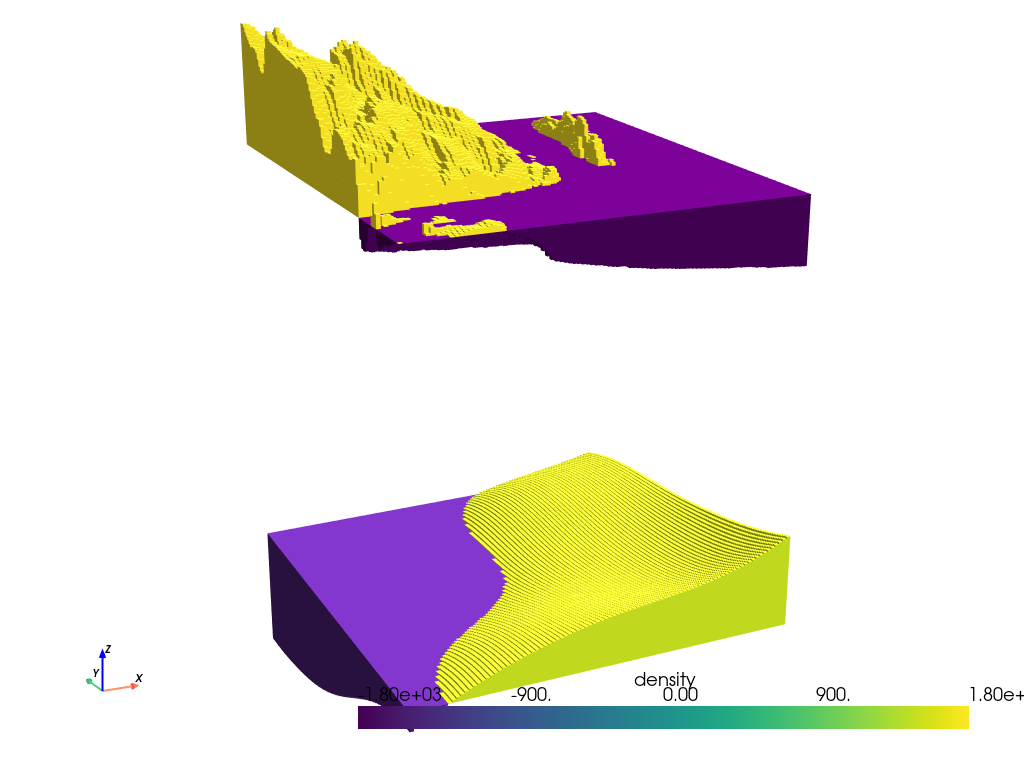

In [3]:
# the density contrast is between sediment (~2300 kg/m3) and air (~1 kg/m3)
basement_density_contrast = 1800

# prisms are created between the mean topography value and the height of the topography
basement_zref = grid.basement_topo.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    grid.basement_topo >= basement_zref,
    basement_density_contrast,
    -basement_density_contrast,
)

# create layer of prisms
basement_prisms = utils.grids_to_prisms(
    grid.basement_topo,
    basement_zref,
    density=density_grid,
)

# the density contrast is between mantle (~3300 kg/m3) and basement rock (~2700 kg/m3)
moho_density_contrast = 3300 - 1800

# prisms are created between the mean topography value and the height of the topography
moho_zref = grid.moho_topo.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    grid.moho_topo >= moho_zref, moho_density_contrast, -moho_density_contrast
)

# create layer of prisms
moho_prisms = utils.grids_to_prisms(
    grid.moho_topo,
    moho_zref,
    density=density_grid,
)

plotting.show_prism_layers(
    [basement_prisms, moho_prisms],
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# Forward gravity of prism layers

Calculate the gravity effect of each of these prism layers

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# forward gravity of basement prisms
grav_df["basement_grav"] = basement_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
# forward gravity of moho prisms
grav_df["moho_grav"] = moho_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["grav"] = grav_df.basement_grav + grav_df.moho_grav
grav_df

  0%|          | 0/7650 [00:00<?, ?it/s]

  0%|          | 0/7650 [00:00<?, ?it/s]

northing   easting  upward  basement_grav  moho_grav       grav
0     162900.0   23900.0  1000.0     -16.543707  -9.119718 -25.663425
1     162900.0   27900.0  1000.0     -13.614722  -7.634750 -21.249472
2     162900.0   31900.0  1000.0      -9.257724  -5.874007 -15.131731
3     162900.0   35900.0  1000.0      -5.663532  -3.888917  -9.552449
4     162900.0   39900.0  1000.0      -3.602270  -1.726167  -5.328437
...        ...       ...     ...            ...        ...        ...
7645  518900.0  343900.0  1000.0     -62.107591  46.462099 -15.645492
7646  518900.0  347900.0  1000.0     -70.813205  46.298935 -24.514270
7647  518900.0  351900.0  1000.0     -80.831179  45.881367 -34.949812
7648  518900.0  355900.0  1000.0     -90.459120  45.160785 -45.298335
7649  518900.0  359900.0  1000.0     -97.937804  44.083025 -53.854779

[7650 rows x 6 columns]

In [5]:
# contaminate gravity with 2 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=2,
    percent=False,
    seed=0,
)

# grid the contaminated gravity
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df

northing   easting  upward  basement_grav  moho_grav       grav  \
0     162900.0   23900.0  1000.0     -16.543707  -9.119718 -25.663425   
1     162900.0   27900.0  1000.0     -13.614722  -7.634750 -21.249472   
2     162900.0   31900.0  1000.0      -9.257724  -5.874007 -15.131731   
3     162900.0   35900.0  1000.0      -5.663532  -3.888917  -9.552449   
4     162900.0   39900.0  1000.0      -3.602270  -1.726167  -5.328437   
...        ...       ...     ...            ...        ...        ...   
7645  518900.0  343900.0  1000.0     -62.107591  46.462099 -15.645492   
7646  518900.0  347900.0  1000.0     -70.813205  46.298935 -24.514270   
7647  518900.0  351900.0  1000.0     -80.831179  45.881367 -34.949812   
7648  518900.0  355900.0  1000.0     -90.459120  45.160785 -45.298335   
7649  518900.0  359900.0  1000.0     -97.937804  44.083025 -53.854779   

      observed_grav  
0        -25.406052  
1        -21.507769  
2        -13.844972  
3         -9.336736  
4         -6.393863  
...             ...  
7645     -17.765391  
7646     -25.569356  
7647     -32.176914  
7648     -46.989264  
7649     -53.992856  

[7650 rows x 7 columns]

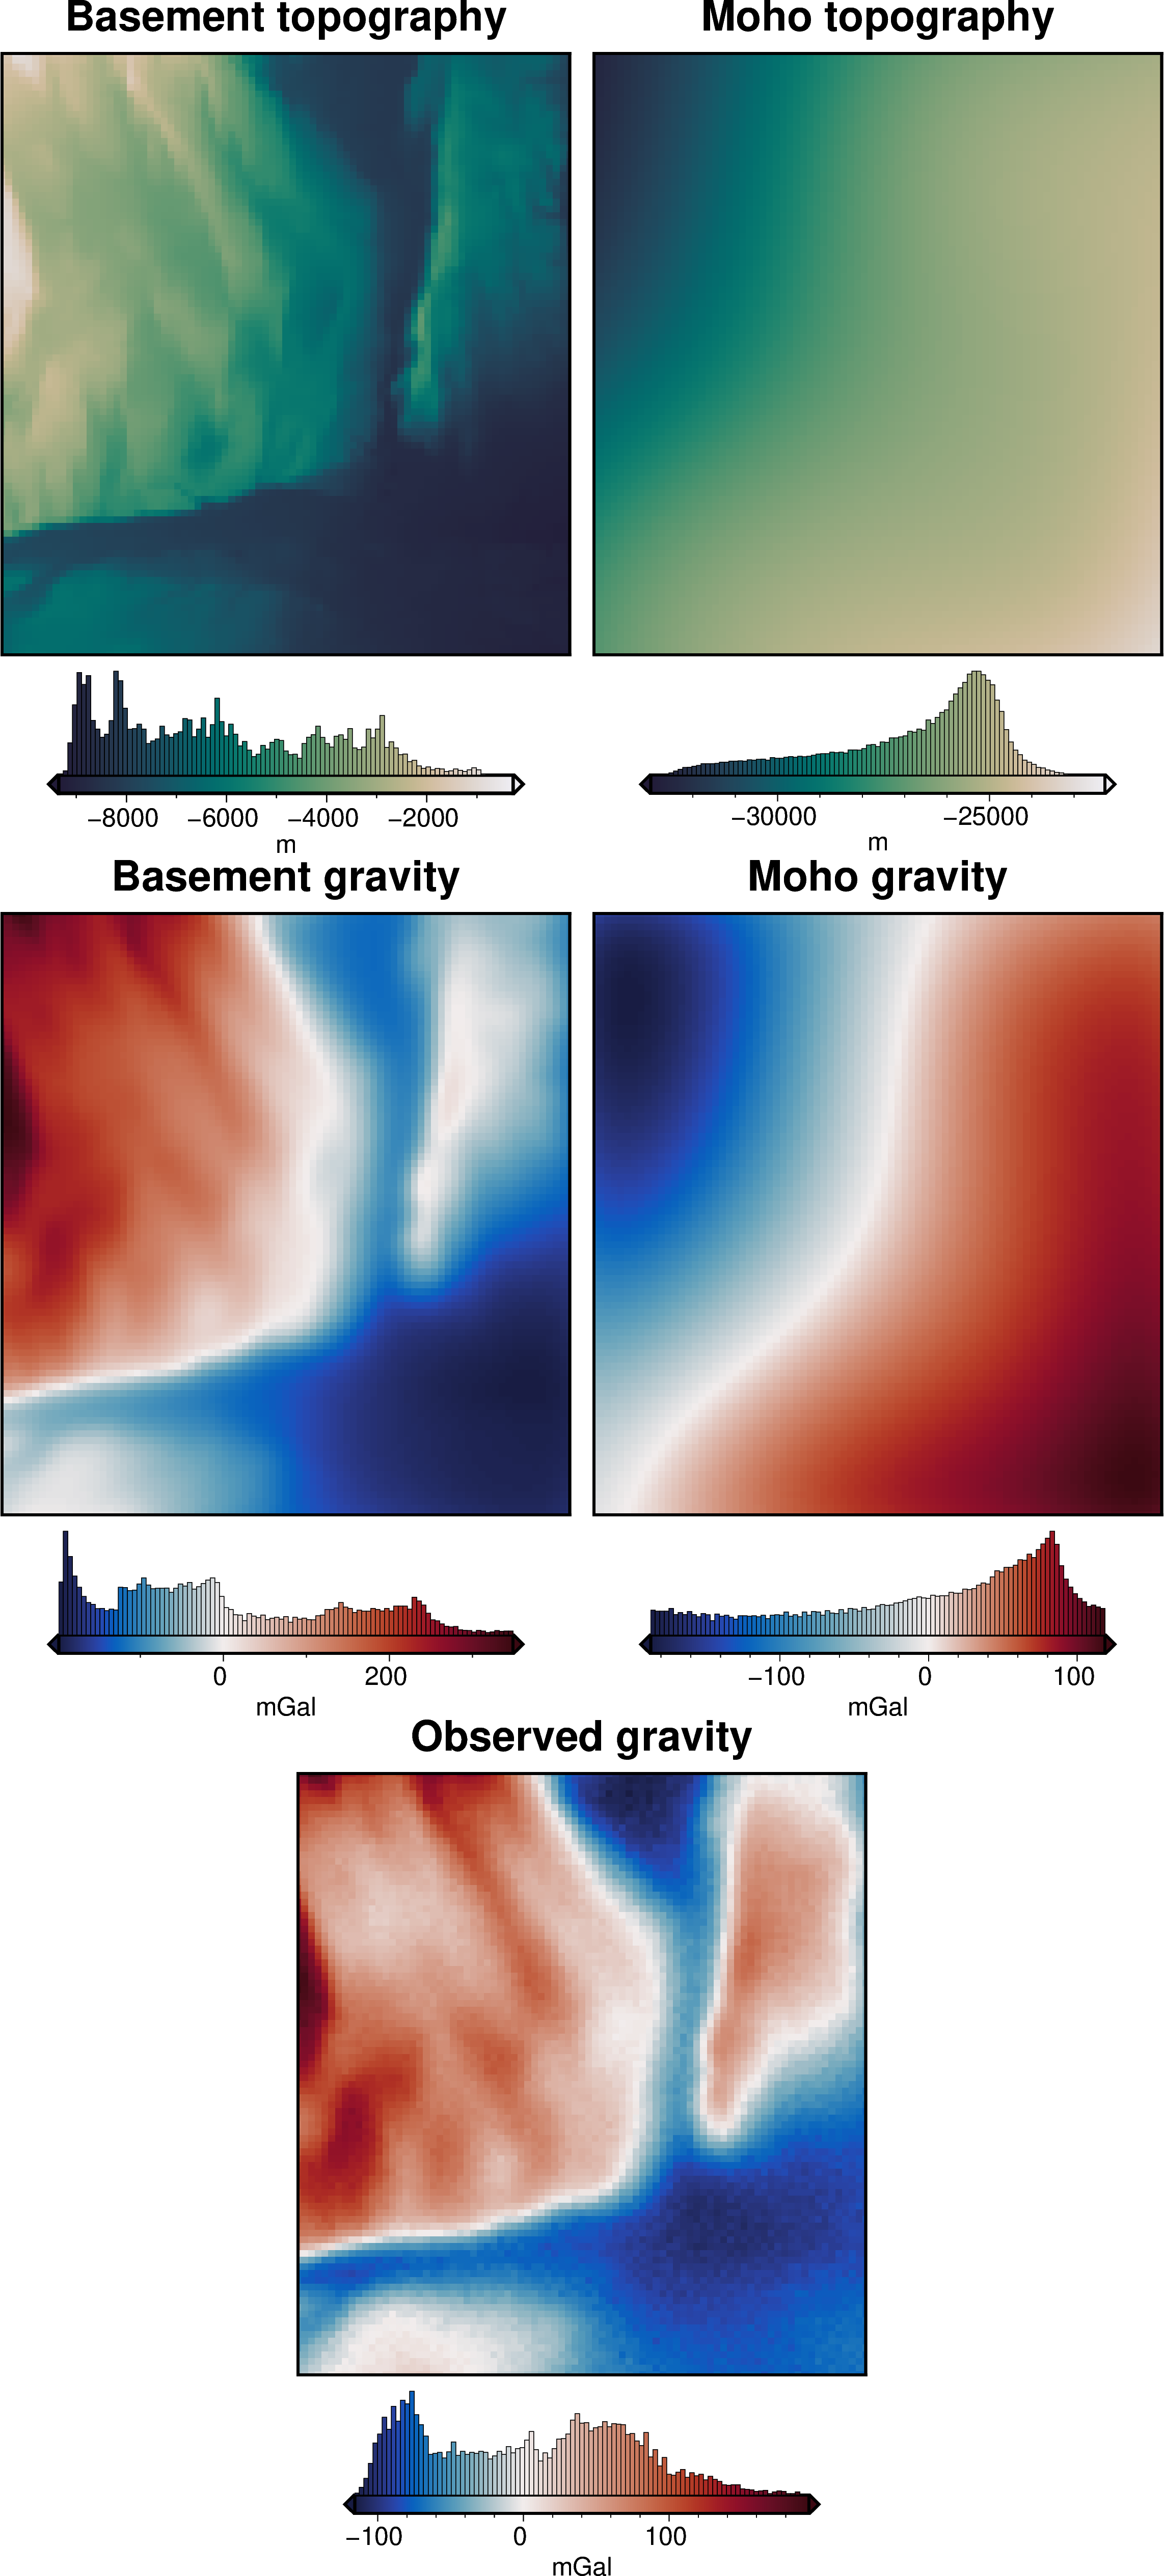

In [6]:
fig = maps.plot_grd(
    grid.basement_topo,
    region=region,
    fig_height=10,
    title="Basement topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    grid.moho_topo,
    region=region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Moho topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.basement_grav,
    fig=fig,
    origin_shift="both_shift",
    xshift_amount=-1,
    yshift_amount=-1.1,
    fig_height=10,
    title="Basement gravity",
    cmap="balance+h0",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Moho gravity",
    cmap="balance+h0",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.observed_grav,
    fig=fig,
    origin_shift="both_shift",
    xshift_amount=-0.5,
    yshift_amount=-1.1,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    cbar_label="mGal",
    hist=True,
)

fig.show()

# Create "a-priori" basement measurements
These points represent locations where we know the basement elevation, for example from drill holes, seismic surveys, or outcropping basement.

In [7]:
# create 10 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=region,
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, grid.basement_topo, "upward", coord_names=("easting", "northing")
)

# Create starting basement model

Here we interpolate the *a-priori* point measurements to create a starting model of basement topography. We then use this to create a starting prism model.

In [8]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    # dampings=[None, 1e-20],
    dampings=np.logspace(-20, 0, 100),
)

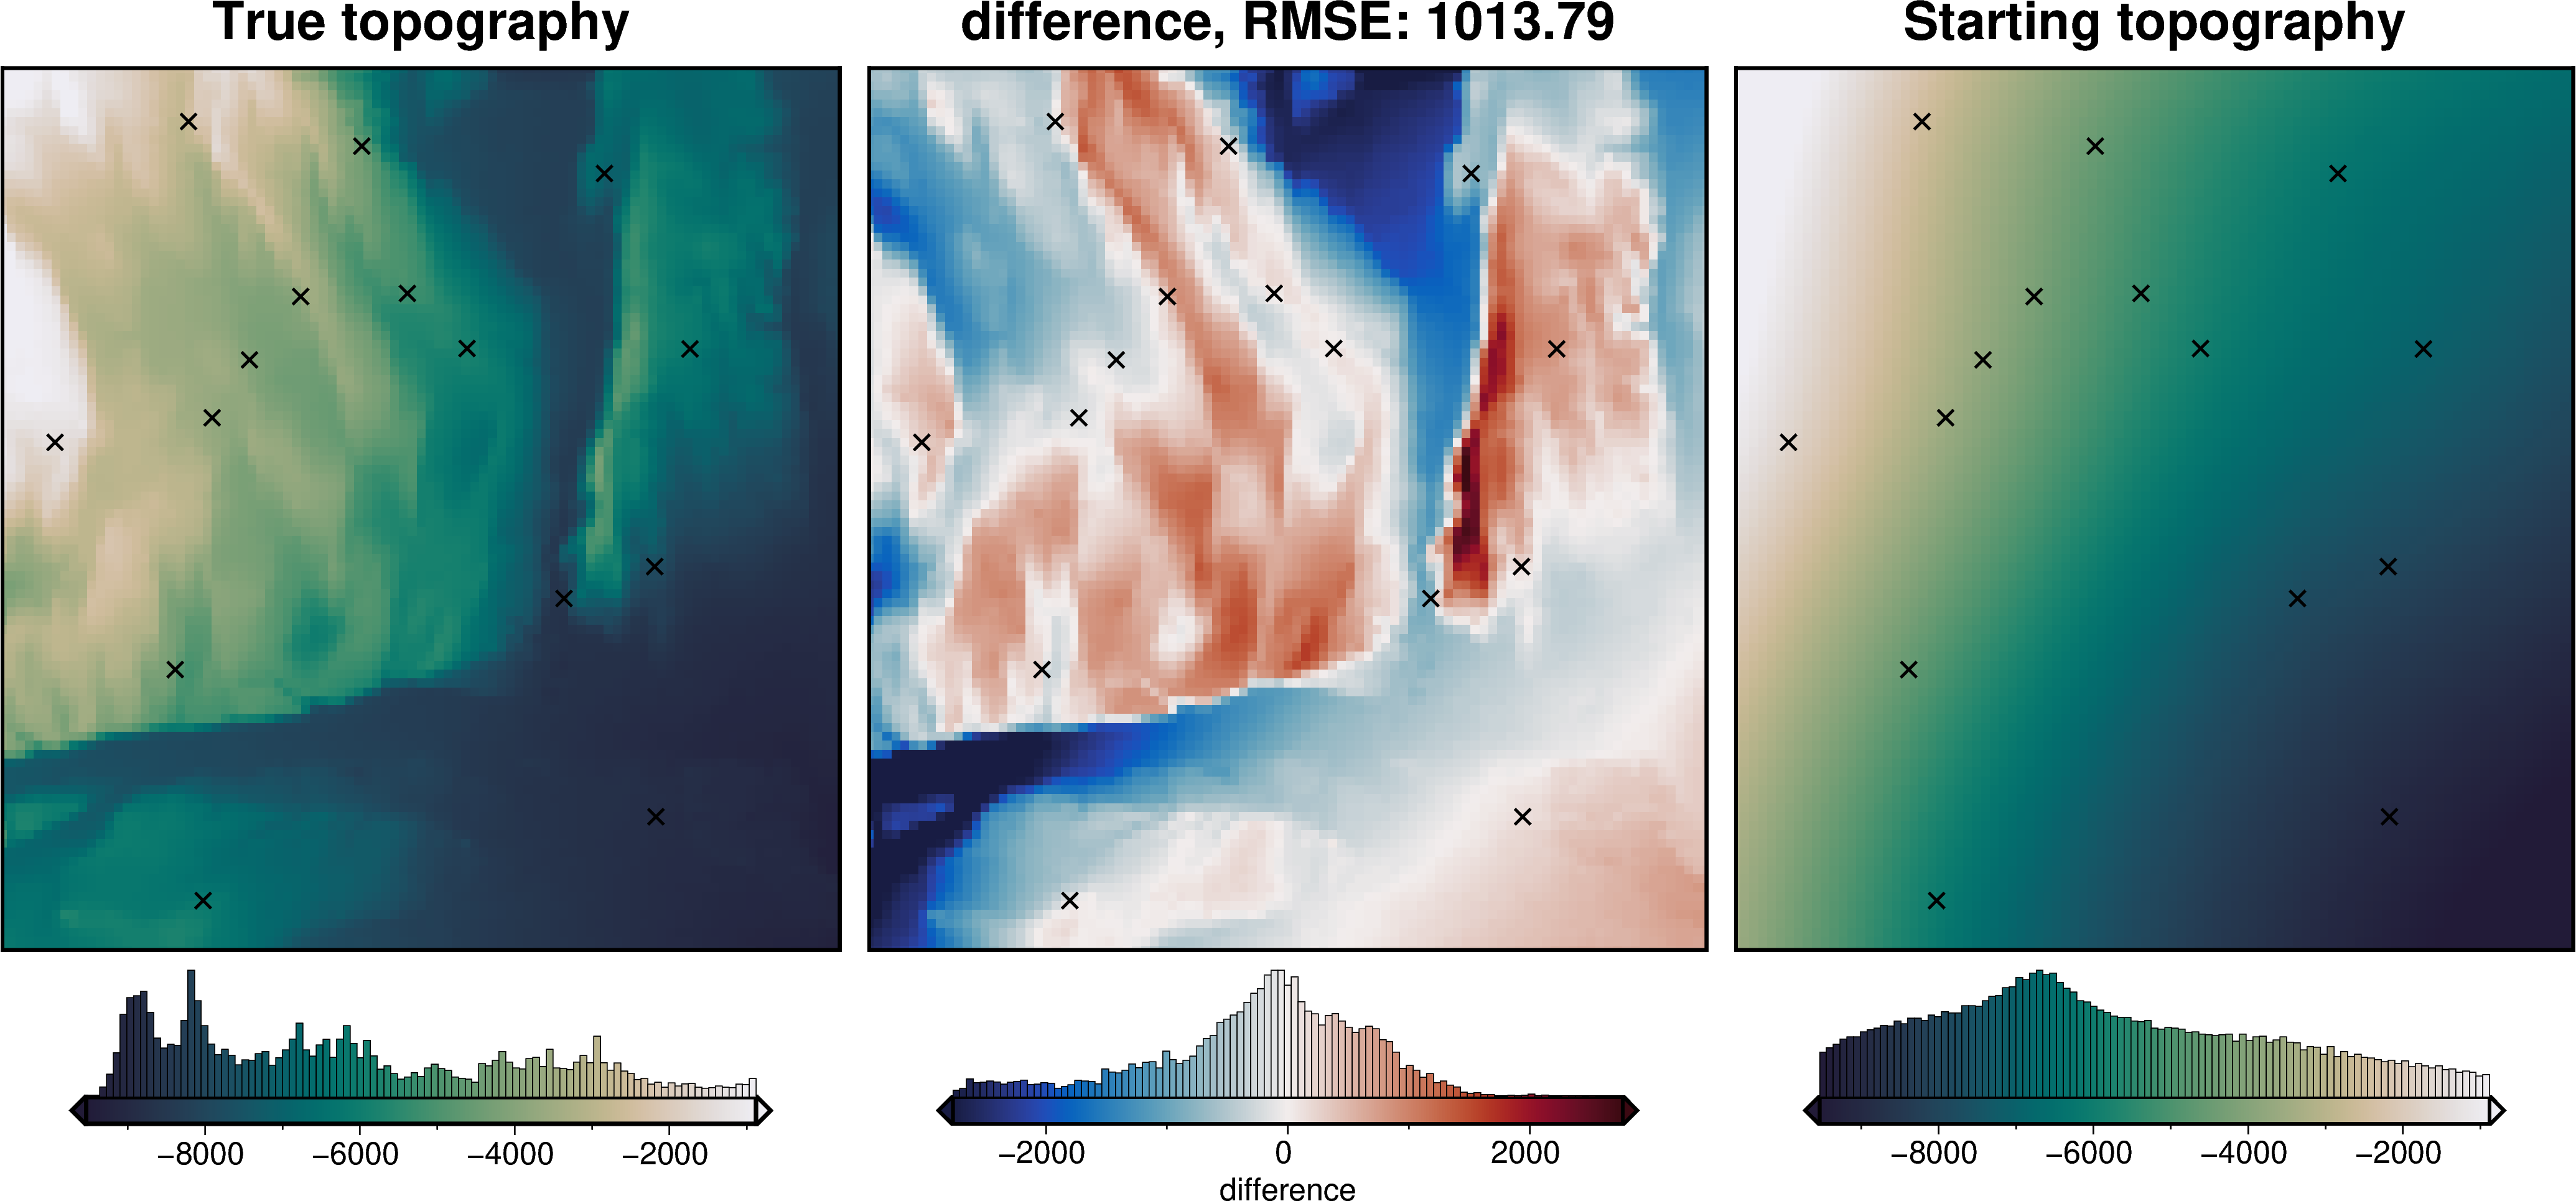

In [9]:
_ = polar_utils.grd_compare(
    grid.basement_topo,
    starting_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

zref: -6129.26 m


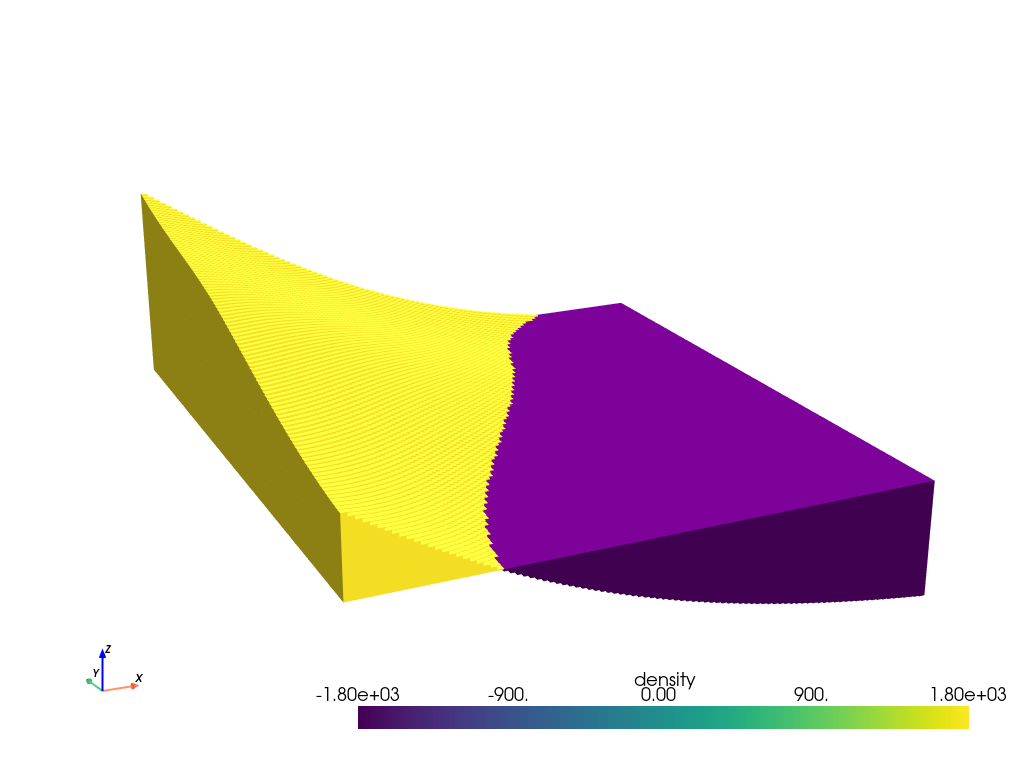

In [10]:
# pick a reference height for the basement
# zref = constraint_points.upward.mean()
zref = basement_zref
print(f"zref: {zref:.2f} m")

# pick a density contrast for the basement (crystalline basement - sedimentary rocks)
# density_contrast = 2300
density_contrast = basement_density_contrast

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

### Forward gravity of starting prism layer

In [11]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df.observed_grav - grav_df.starting_grav
grav_df

  0%|          | 0/7650 [00:00<?, ?it/s]

northing   easting  upward  basement_grav  moho_grav       grav  \
0     162900.0   23900.0  1000.0     -16.543707  -9.119718 -25.663425   
1     162900.0   27900.0  1000.0     -13.614722  -7.634750 -21.249472   
2     162900.0   31900.0  1000.0      -9.257724  -5.874007 -15.131731   
3     162900.0   35900.0  1000.0      -5.663532  -3.888917  -9.552449   
4     162900.0   39900.0  1000.0      -3.602270  -1.726167  -5.328437   
...        ...       ...     ...            ...        ...        ...   
7645  518900.0  343900.0  1000.0     -62.107591  46.462099 -15.645492   
7646  518900.0  347900.0  1000.0     -70.813205  46.298935 -24.514270   
7647  518900.0  351900.0  1000.0     -80.831179  45.881367 -34.949812   
7648  518900.0  355900.0  1000.0     -90.459120  45.160785 -45.298335   
7649  518900.0  359900.0  1000.0     -97.937804  44.083025 -53.854779   

      observed_grav  starting_grav      misfit  
0        -25.406052     125.681467 -151.087518  
1        -21.507769     119.809839 -141.317608  
2        -13.844972     113.383672 -127.228645  
3         -9.336736     106.625985 -115.962720  
4         -6.393863      99.669984 -106.063847  
...             ...            ...         ...  
7645     -17.765391     -30.453190   12.687799  
7646     -25.569356     -31.836073    6.266717  
7647     -32.176914     -33.098008    0.921094  
7648     -46.989264     -34.197671  -12.791593  
7649     -53.992856     -35.066784  -18.926072  

[7650 rows x 9 columns]

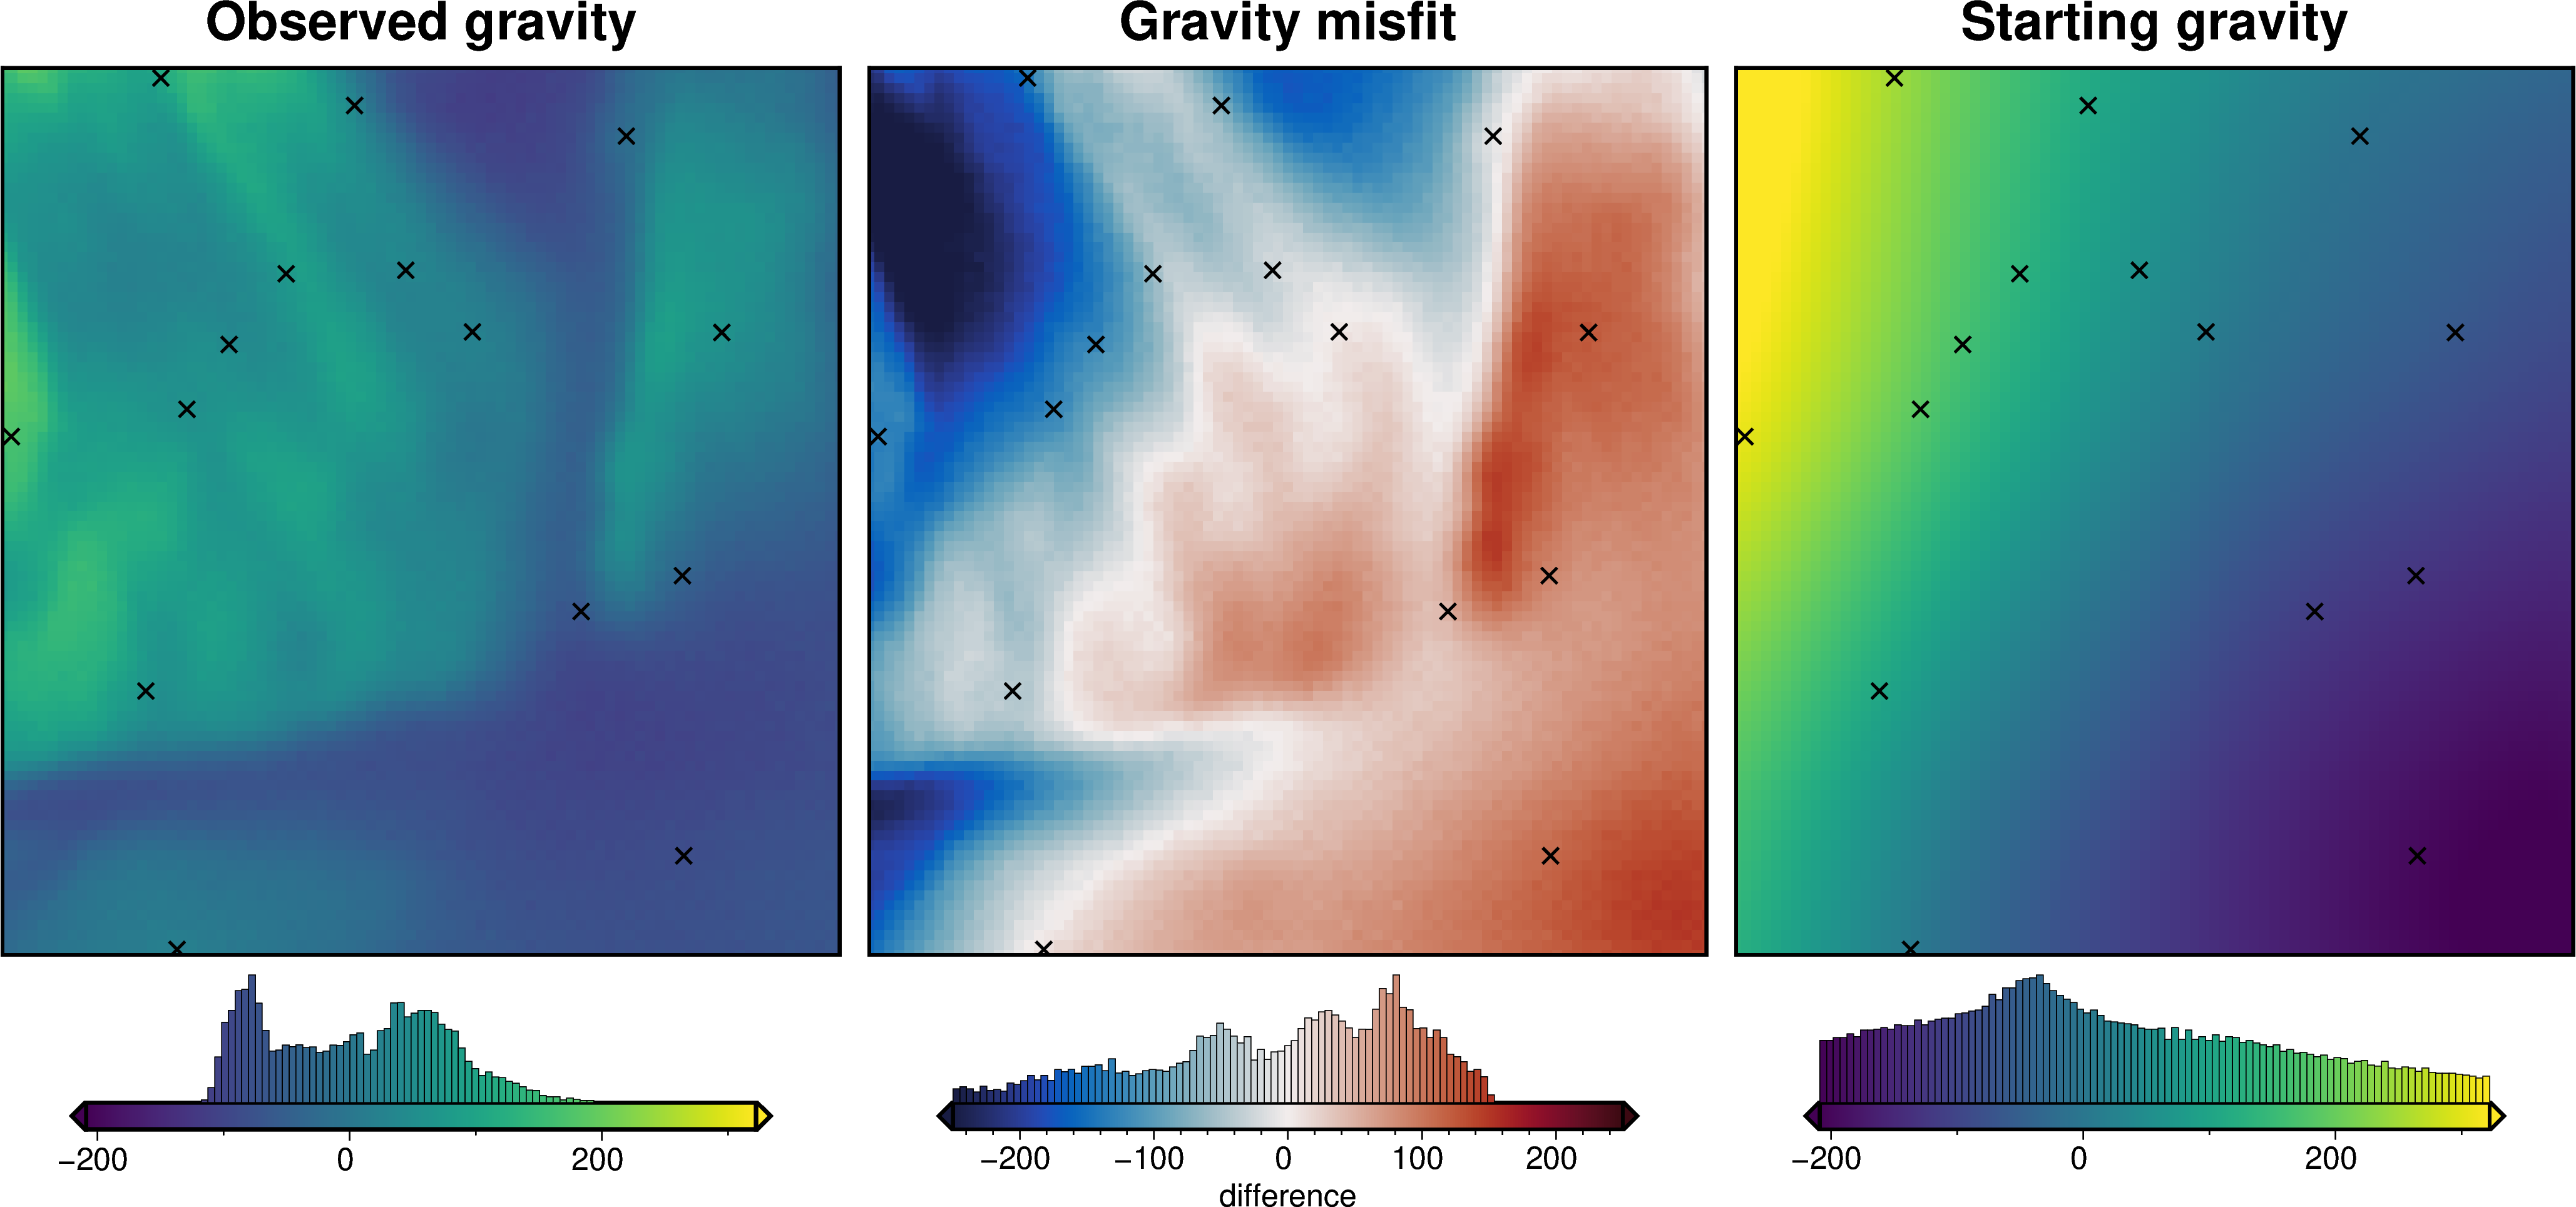

In [12]:
# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.observed_grav,
    grav_grid.starting_grav,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

# True-Estimated regional plotting function

In [13]:
def regional_comparison(df):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.moho_grav,
        grav_grid.reg,
        robust=True,
        plot=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

Each of these regional separation techniques requires the user input to pick the value of a certain parameter, each of which has a large effect on the outcome. Below these `hyperparameters` for each technique are explained:

**Filter technique**: the width of the gaussian filter

**Trend technique**: the degree-order of the trend fit to the data

**Equivalent Sources technique**: the source depth and optionally a damping parameter and cell-size for a block reduction

**Constraint Point Minimization technique**: the tension factor if using minimum curvature gridding, the damping value if using bi-harmonic spline gridding, or the source depth and damping parameters if using equivalent sources gridding.

# Hyperparameter estimation
In the [estimating a regional field](estimating_regional_field.ipynb) notebook we just picked these hyperparameter values arbitrarily. Below we show a more informed technique for choosing each of these hyperparameter values. These rely on have _a priori_ information on the topography of interest to the inversion, in this case the basement topography. Therefore, we need to know the elevation of the basement at some locations to use these hyperparameter estimation techniques. These are referred to as **constraints**, and they would typically come from outcrops, boreholes, or other geophysical techniques such as seismic surveys. At the top of this notebook we sampled the basement topography at a series of random locations to simulate this constraints. 

In theory, the optimal `regional misfit` should result in `residual misfit` which is 0 at constraint points (we know the topography at constraints, so the starting model is exactly equal to the true topography and therefore the `residual misfit` should be very small at these points). This is achieved with a `regional misfit` equal to the full `misfit` at the constraints. This can obviously be achieved by setting the `regional misfit` entirely equal to the `total misfit` (i.e. the `residual misfit` is 0), but this would result in no change in the topography during this inversion. Therefore, the optimal `regional misfit` is the model which 1) **minimizes** the `residual misfit` at constraint points, while **maximizing** the amplitude of the `residual misfit` away from constraint points. 

If we know the topography at some points, we can use the resulting `residual misfit` at these points to evaluate the effectiveness of the `regional misfit` estimation. This hyperparameter estimation technique is relatively ineffective for the  **filter** and **trend** methods, so here we will show how it works for just the **equivalent sources** method. 

## Report the scores for the equivalent source techniques
Choose hyperparameter values and report the scores. There are two scores; 
1) the root mean or median square (RMS) of the residual misfit values at constraint points
2) the RMS of the entire grid of residual misfit values.

We want a low value for the first score and a high value for the second score.

In [14]:
# values needed in all the regional separation techniques
kwargs = {
    "testing_df": constraint_points,
    "grav_df": grav_df,
    "grav_data_column": "misfit",
    "regional_column": "reg",
    # "score_as_median":True,
    "true_regional": grav_grid.moho_grav,
}

In [15]:
constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="eq_sources",
        source_depth=4000e3,
        eq_damping=None,
        block_size=spacing * 20,
        **kwargs,
    )
)
print(
    "Scores for equivalent Source technique:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

Scores for equivalent Source technique:
	RMS of residual at constraint points: 35.5905131096447
 	RMS of residual everywhere: 37.45028841863267


Finding the optimal values for each of these hyperparameters can be accomplished with a mult-objective hyperparameter optimization. Here we use optimization Python package *Optuna* to find the parameter values which minimizes **score 1** while maximizing **score 2**.

In [16]:
logger = logging.getLogger().setLevel(logging.INFO)

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 20
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 1
INFO:root:	parameter: {'filter_width': 21731.1974100421}
INFO:root:	scores: [2.6714612901777746, 7.7088808780579186]


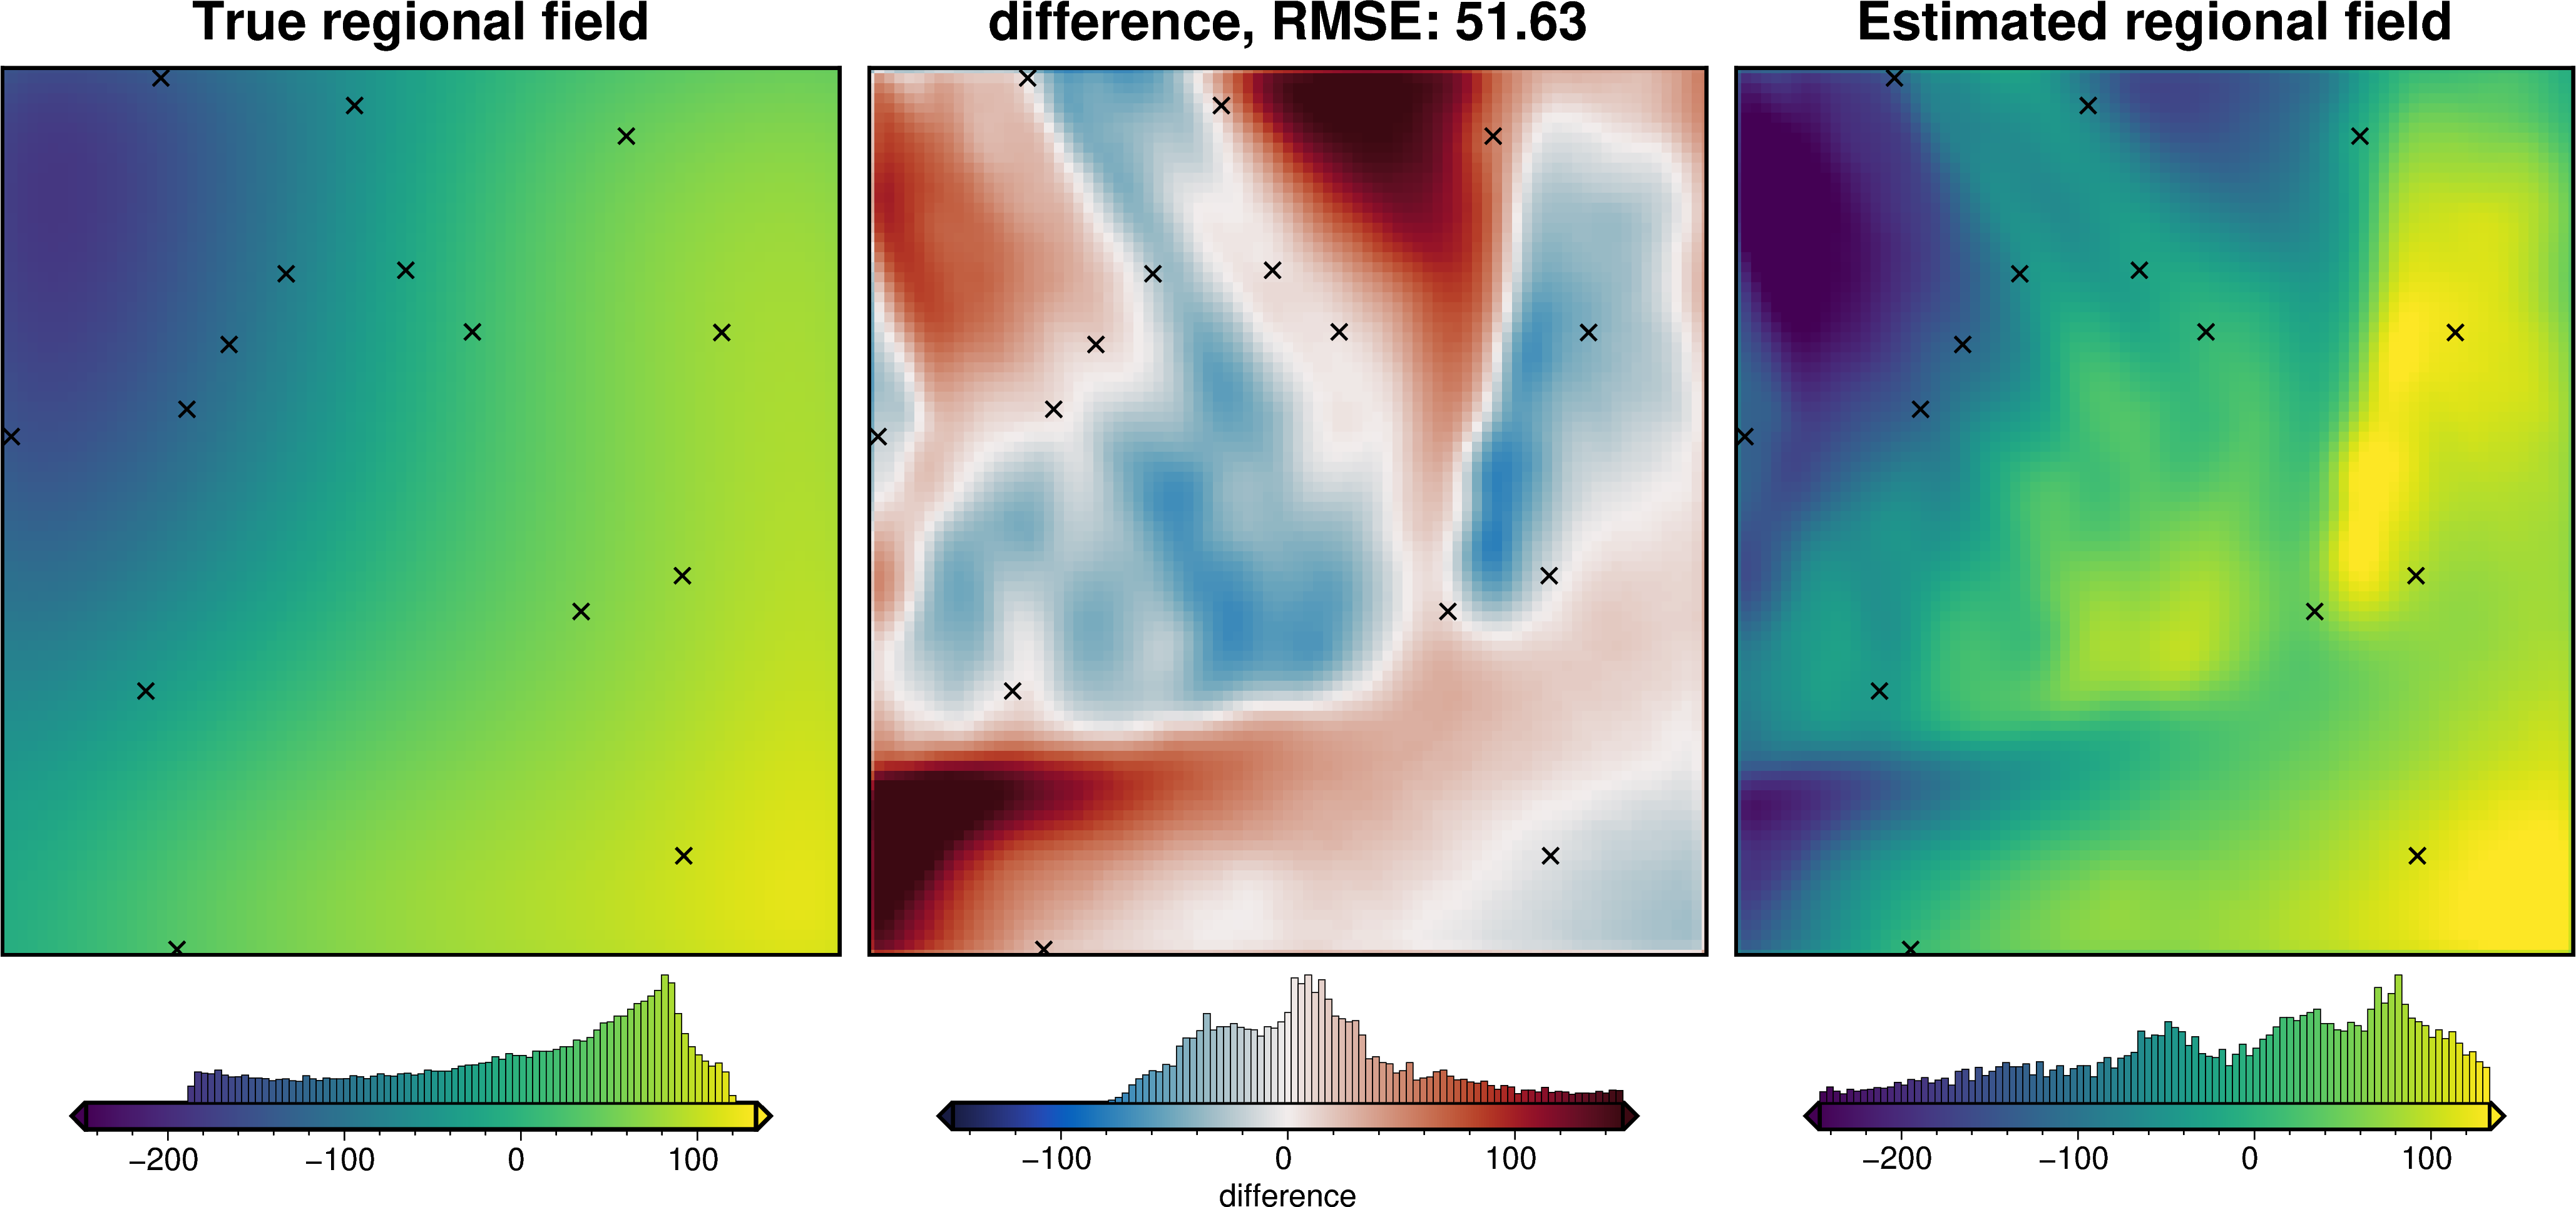

In [17]:
filter_study, grav_df, best_trial = optimization.optimize_regional_filter(
    filter_width_limits=[1e3, 1000e3],
    n_trials=20,
    plot=True,
    plot_grid=False,
    # optimize_on_true_regional_misfit=True,
    **kwargs,
)

regional_comparison(grav_df)

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/optuna/progress_bar.py:51: UserWarning:

Progress bar won't be displayed because n_trials and timeout are None.

INFO:root:Number of trials on the Pareto front: 11
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 9
INFO:root:	parameter: {'trend': 15}
INFO:root:	scores: [8.613955384089724, 10.553919731027118]


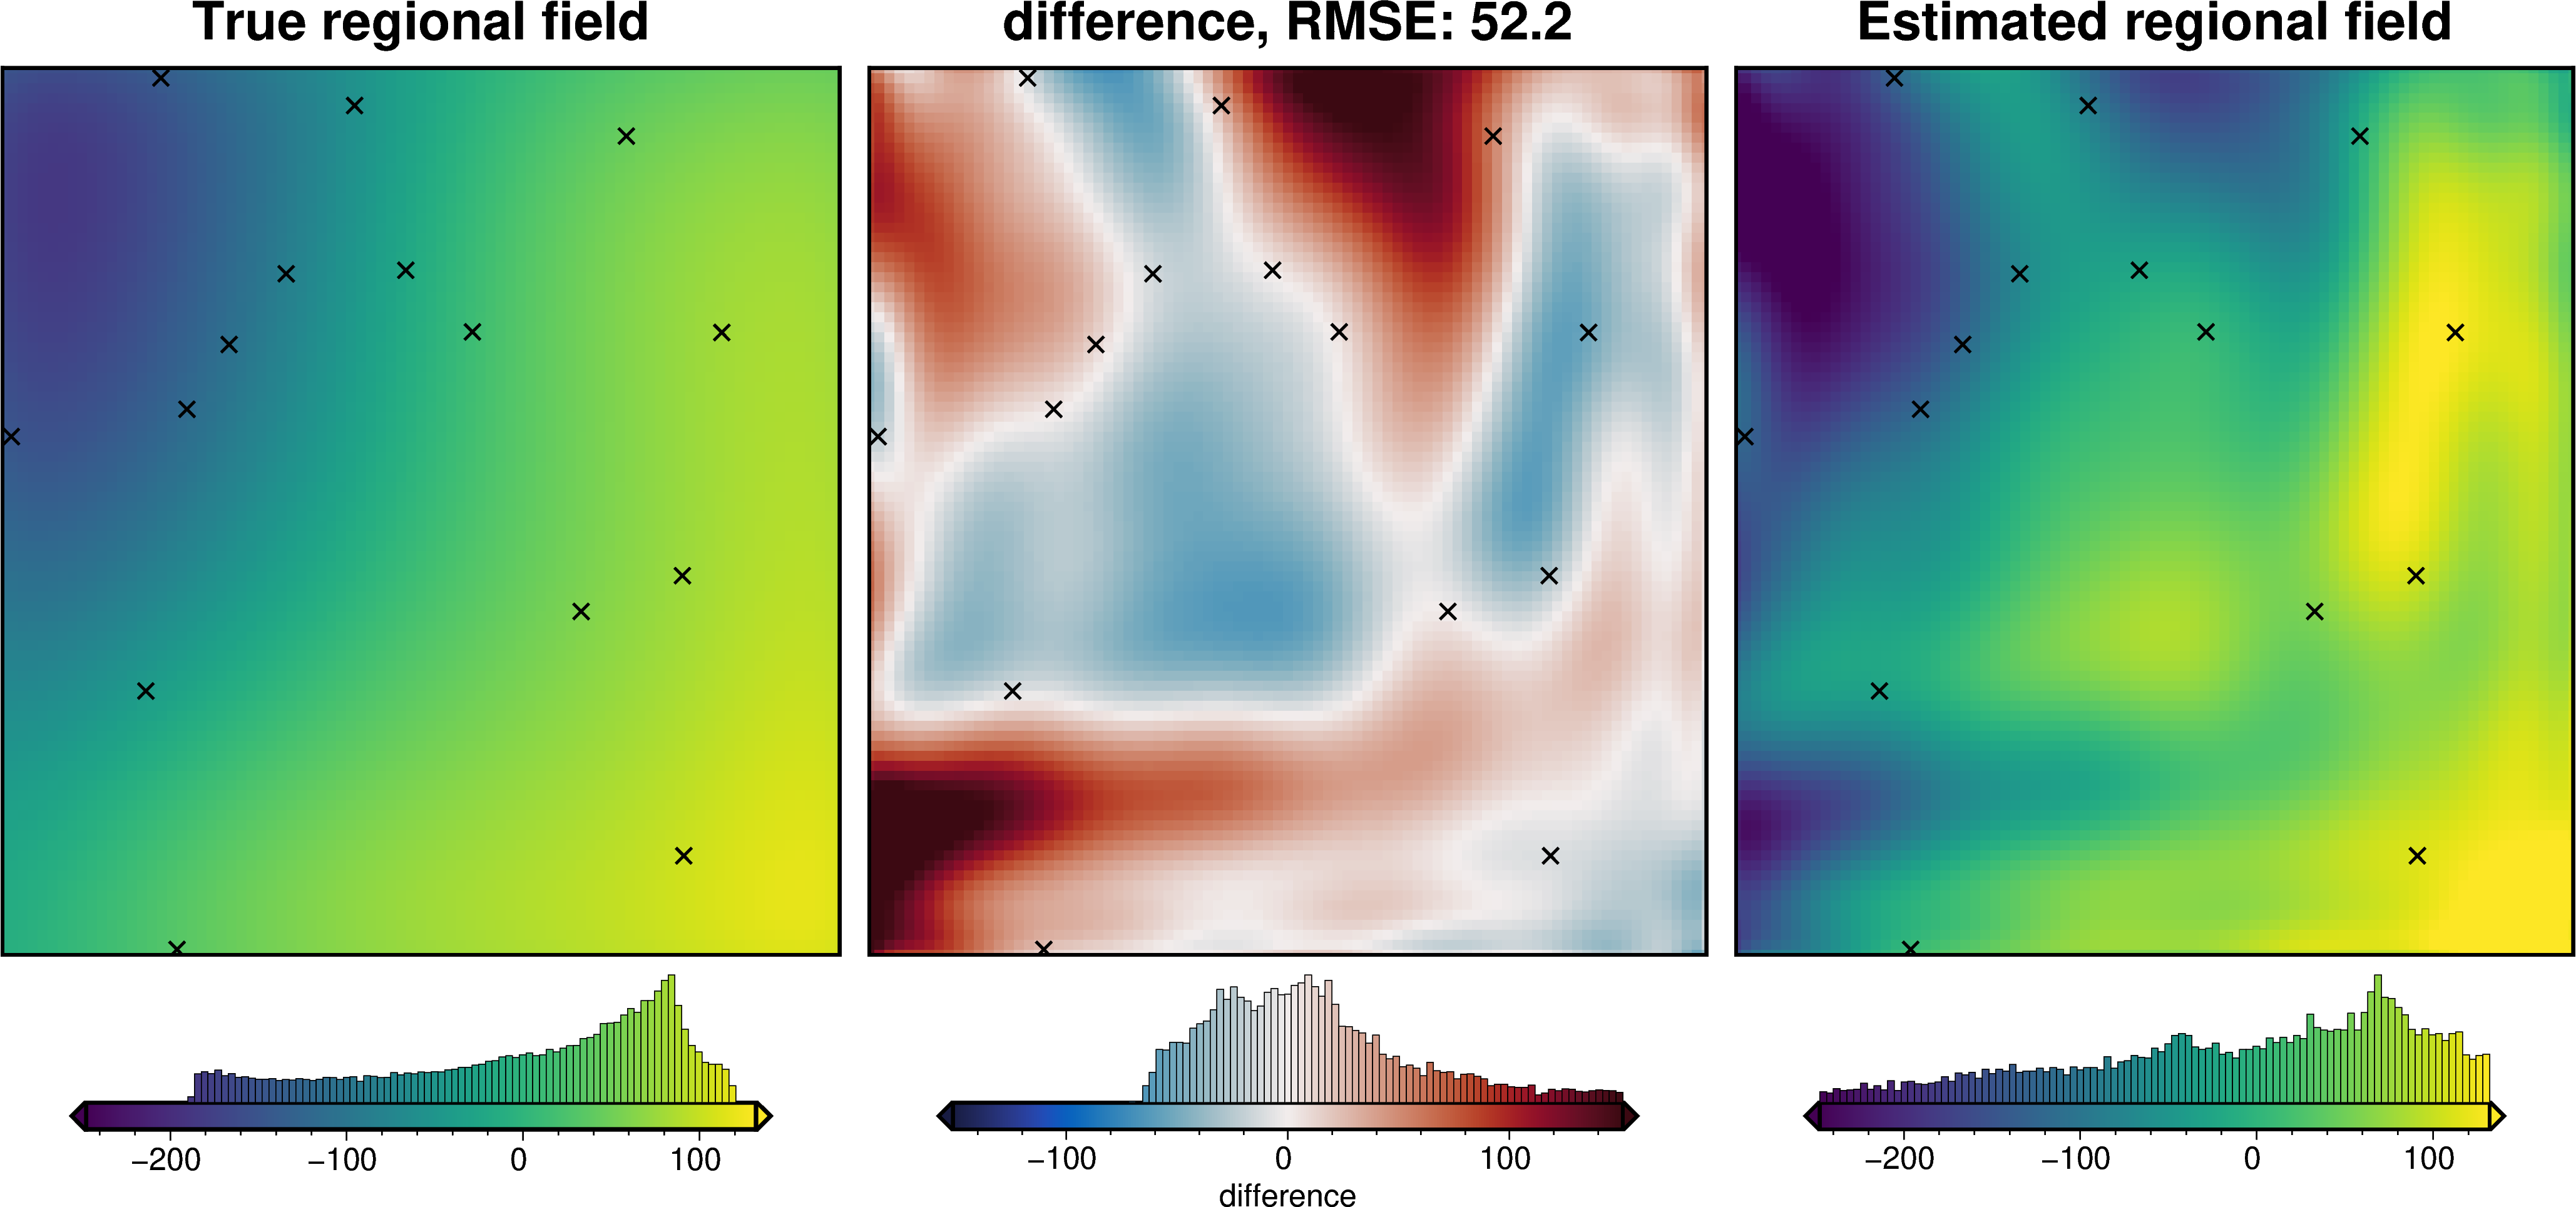

In [18]:
trend_study, grav_df, best_trial = optimization.optimize_regional_trend(
    trend_limits=[1, 15],
    plot=True,
    plot_grid=False,
    # optimize_on_true_regional_misfit=True,
    **kwargs,
)

regional_comparison(grav_df)

  0%|          | 0/60 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 47
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 0
INFO:root:	parameter: {'source_depth': 254264.1286533492, 'block_size': 44150.3898718803, 'eq_damping': 0.00021701130033392337}
INFO:root:	scores: [12.525878778369881, 19.9364200832868]


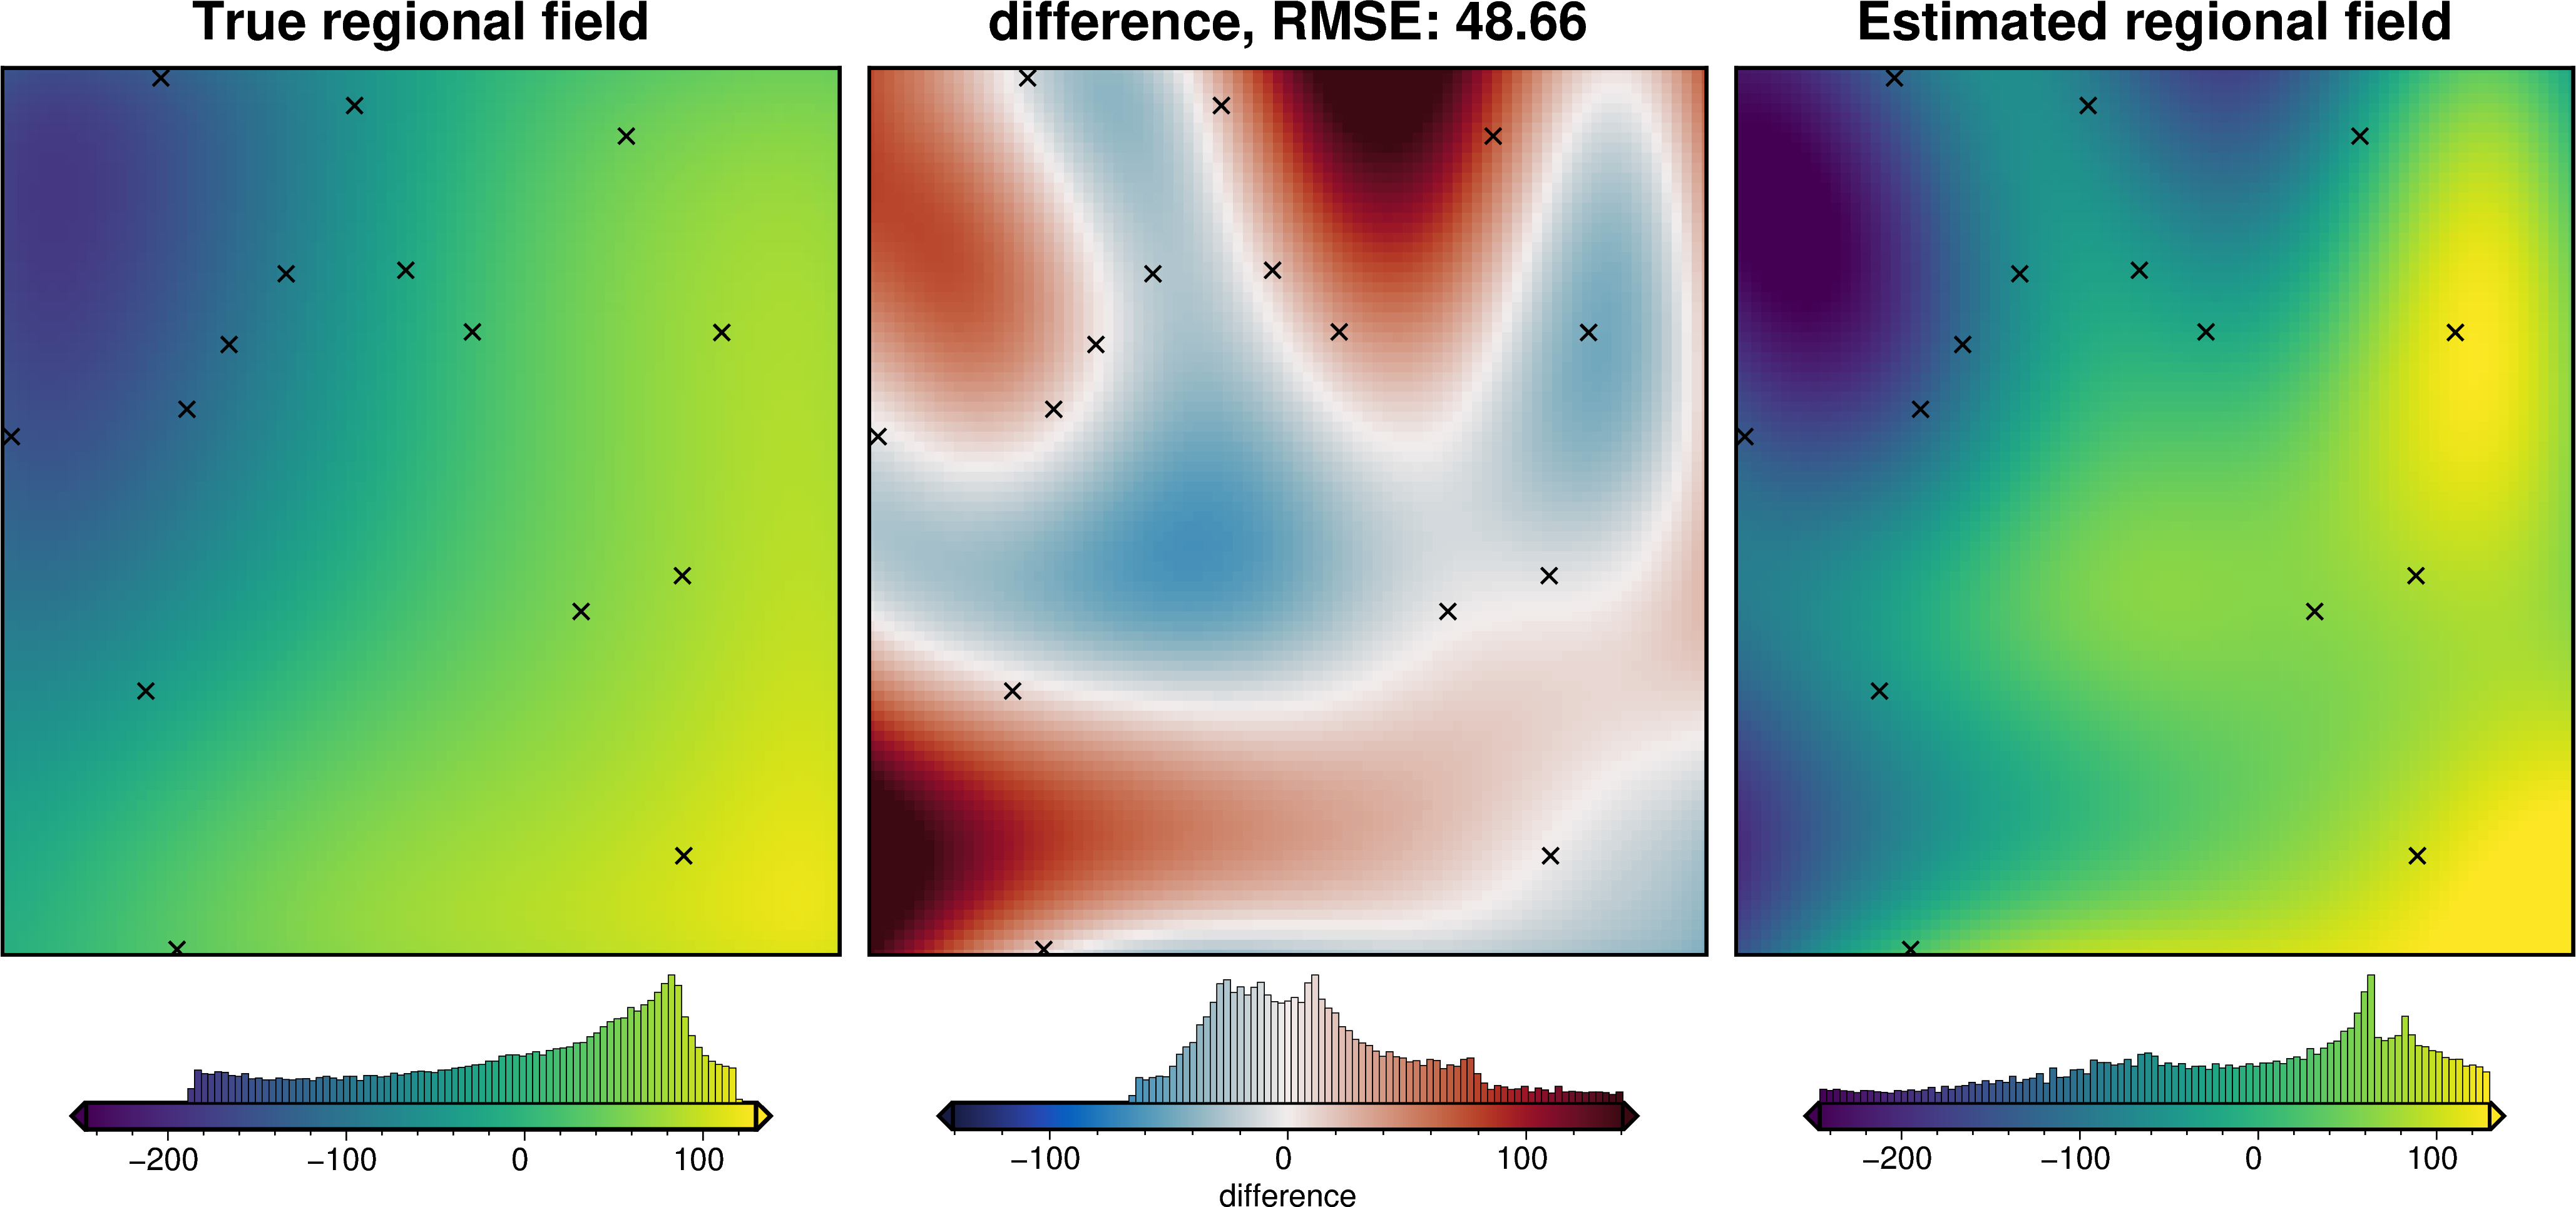

In [19]:
eq_sources_study, grav_df, best_trial = optimization.optimize_regional_eq_sources(
    source_depth_limits=[100e3, 300e3],
    block_size_limits=[spacing * 10, spacing * 60],
    eq_damping_limits=[1e-10, 1],
    n_trials=60,  # more trials needed since more parameters
    plot=True,
    plot_grid=False,
    # optimize_on_true_regional_misfit=True,
    **kwargs,
)

regional_comparison(grav_df)

## Constraint point minimization hyperparameters

The remaining technique, **constraint point minimization**, uses the **constraints** to estimate the regional field, and therefore we can't use the constraint points to determine the optimal hyperparameter values. For this, we must use a cross-validation scheme, where some of the constraint points are omitted, and these are used to evaluate the effectiveness of the regional estimation. This works by 1) splitting the constraints into _testing_ and _training_ sets, 2) using only the _testing_ set to performing the **constraint point minimization** regional estimation for a range of possible hyperparameter values, and 3) assigning **scores** to each hyperparameter value. These scores are the same as in the above methods, one score for the RMS of the residual at the constraint points (just the _training_ points) and one score for the RMS of the entire residual grid. The hyperparameter value which produces the lowest value for the first score, and the highest values for the second score is the optimal one.

### Split constraint points into testing and training sets
There are a few methods we can use to split the constraints into testing and training sets:

#### 1) Random Splitting
We can randomly split the constraints into testing and training, but certain constraints are likely very important and greatly effect the **constraint point minimization** technique. This is normally not the optimal technique.

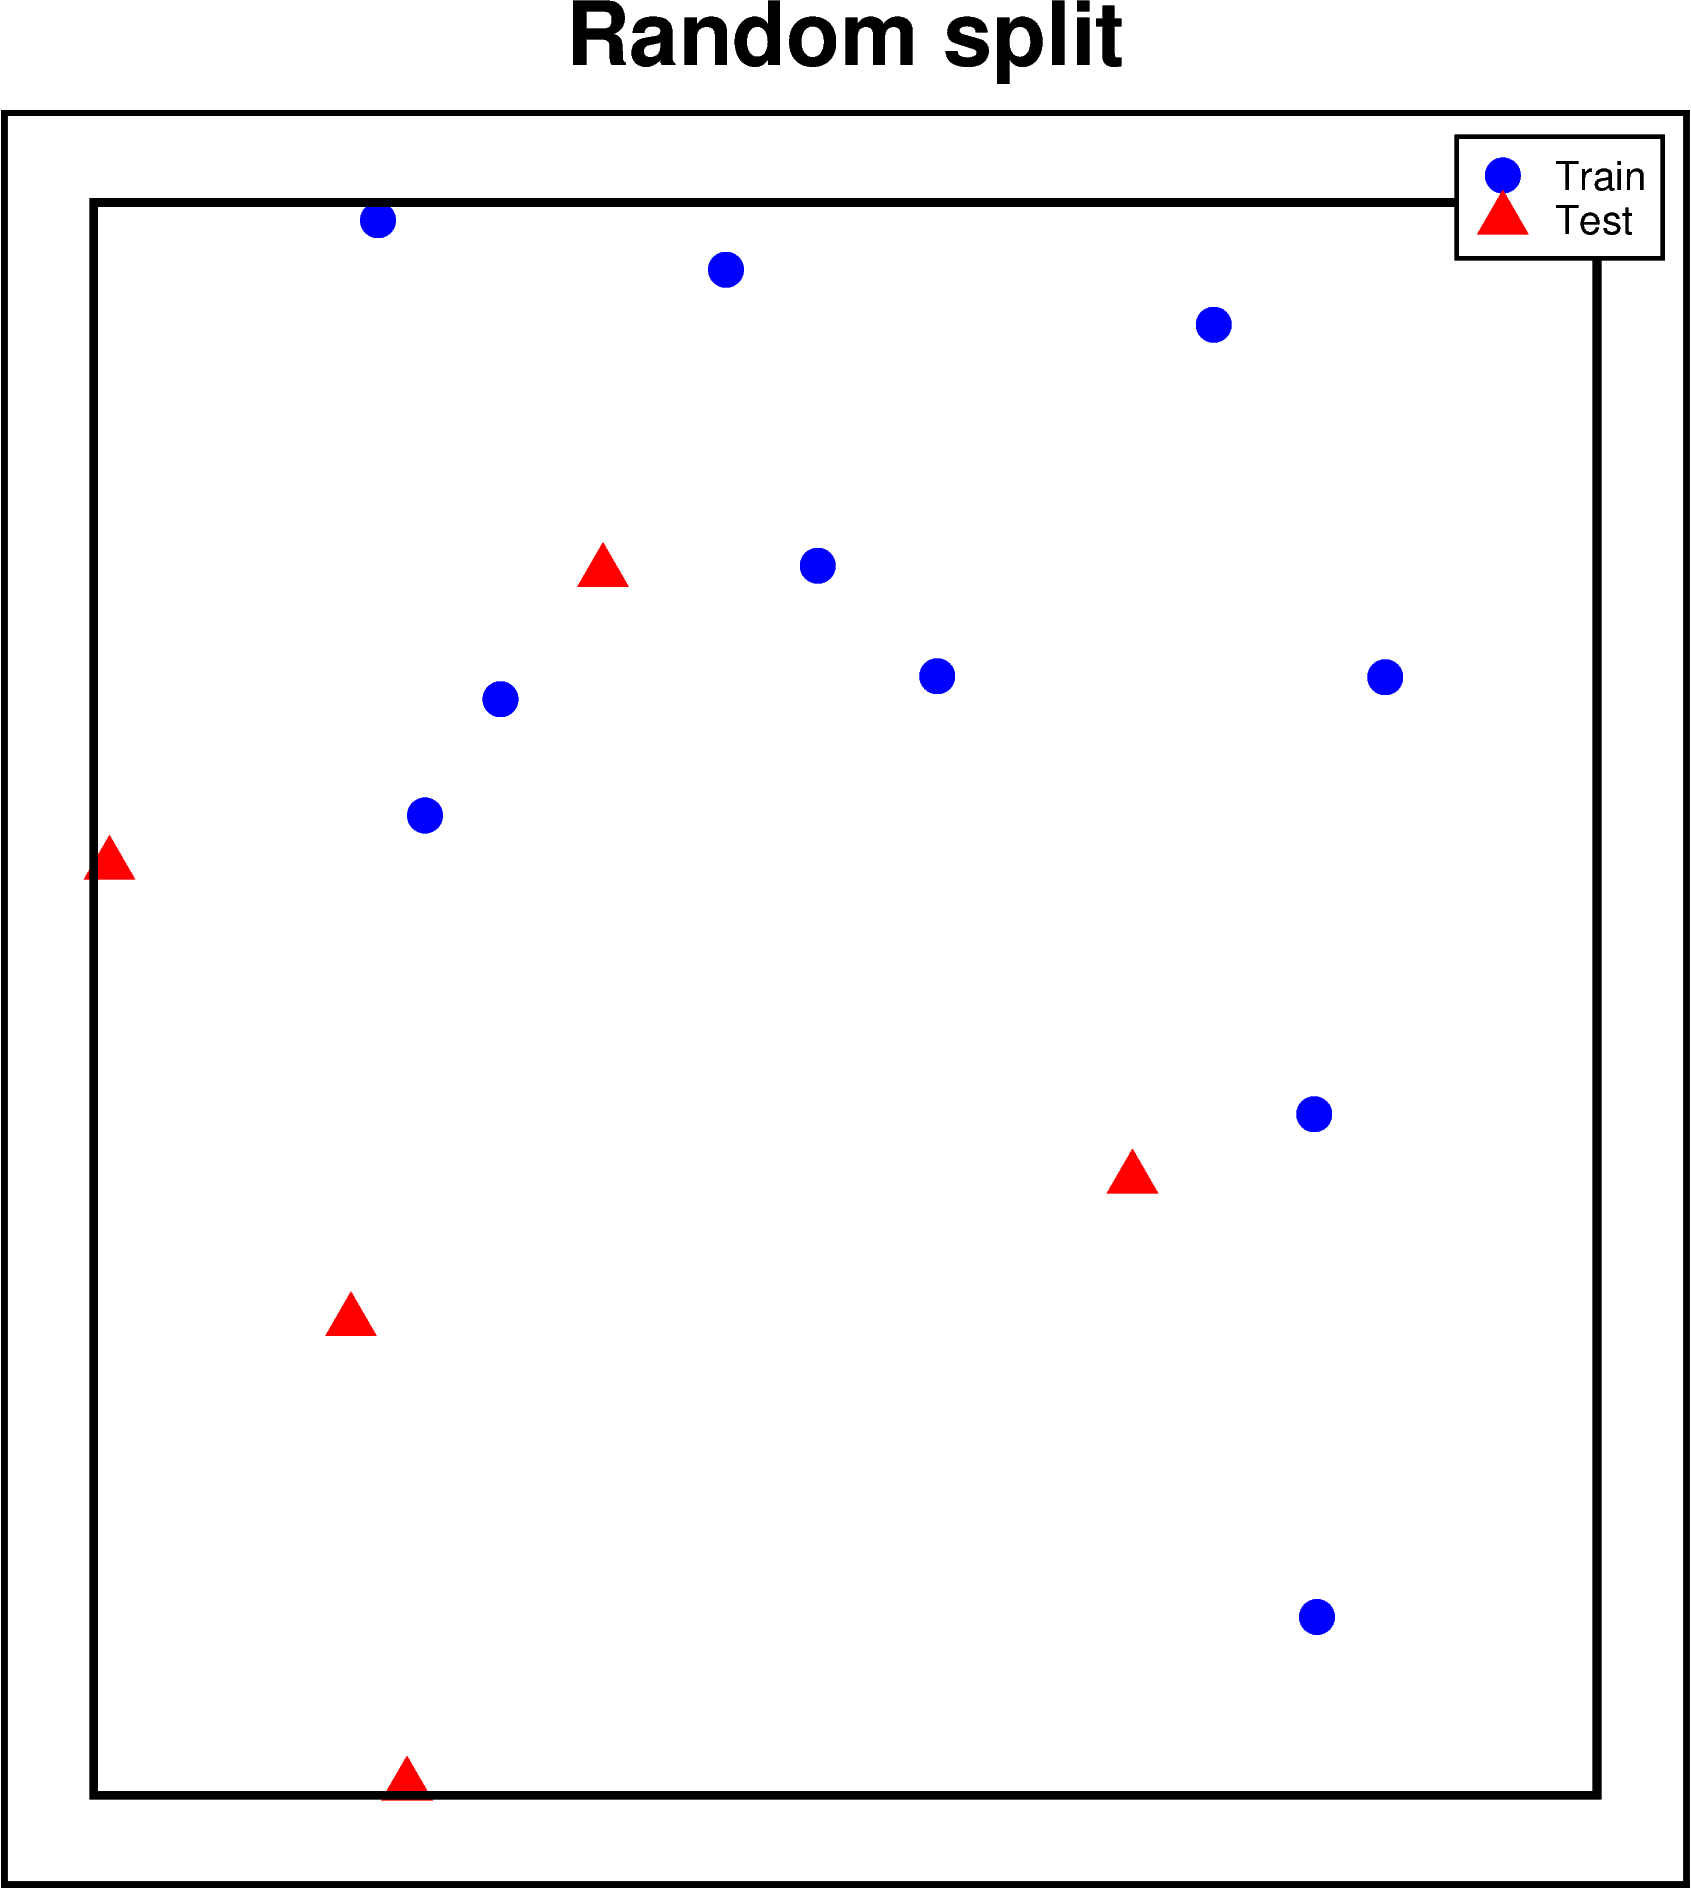

easting       northing       upward  train
0  296715.509301  315109.665385 -7771.865470   True
1   97955.917590  381913.273733 -3696.069980   True
2  212464.442079  413038.244716 -5835.762415   True
3  312585.151503  412789.886738 -6178.090981   True
4  185744.836752  437747.618234 -5230.910817   True
5  114799.031988  407905.723662 -4037.824297   True
6  297311.998972  202734.681191 -8882.480862   True
7  165200.779866  503888.251841 -4551.466895   True
8  274253.699476  491584.093601 -7000.722903   True
9   87441.415368  514943.513495 -2611.977474   True
0  256089.893751  300737.319016 -8556.923537  False
1   27437.029770  370907.112964 -1383.763355  False
2   81410.282014  268837.863004 -4562.000830  False
3   93942.740553  165086.148419 -6166.691339  False
4  137758.290763  436305.416136 -3739.300871  False

In [20]:
train, test = vd.train_test_split(
    (constraint_points.easting, constraint_points.northing),
    constraint_points.upward,
    test_size=0.3,
    random_state=123,
)
train_df = pd.DataFrame(
    data={
        "easting": train[0][0],
        "northing": train[0][1],
        "upward": train[1][0],
        "train": True,
    }
)
test_df = pd.DataFrame(
    data={
        "easting": test[0][0],
        "northing": test[0][1],
        "upward": test[1][0],
        "train": False,
    }
)
random_split_df = pd.concat([train_df, test_df])

df_train = random_split_df[random_split_df.train == True]  # noqa: E712
df_test = random_split_df[random_split_df.train == False]  # noqa: E712

fig = maps.basemap(
    region=buffer_region,
    title="Random split",
)
fig.plot(
    x=df_train.easting,
    y=df_train.northing,
    style="c.3c",
    fill="blue",
    label="Train",
)
fig.plot(
    x=df_test.easting,
    y=df_test.northing,
    style="t.5c",
    fill="red",
    label="Test",
)
maps.add_box(fig, box=region)
fig.legend()
fig.show()
random_split_df

#### 2) Leave One Out
Instead of a single split, we can perform many sets of splits, each called a **Fold**. A simple technique for this is to create 1 fold per number of constraint points, where each fold leaves one point out of the training set to make up the testing set. If you have many points, this results in a lot of folds which can be very computationally demanding since we will need to perform a hyperparameter cross-validation for each fold.

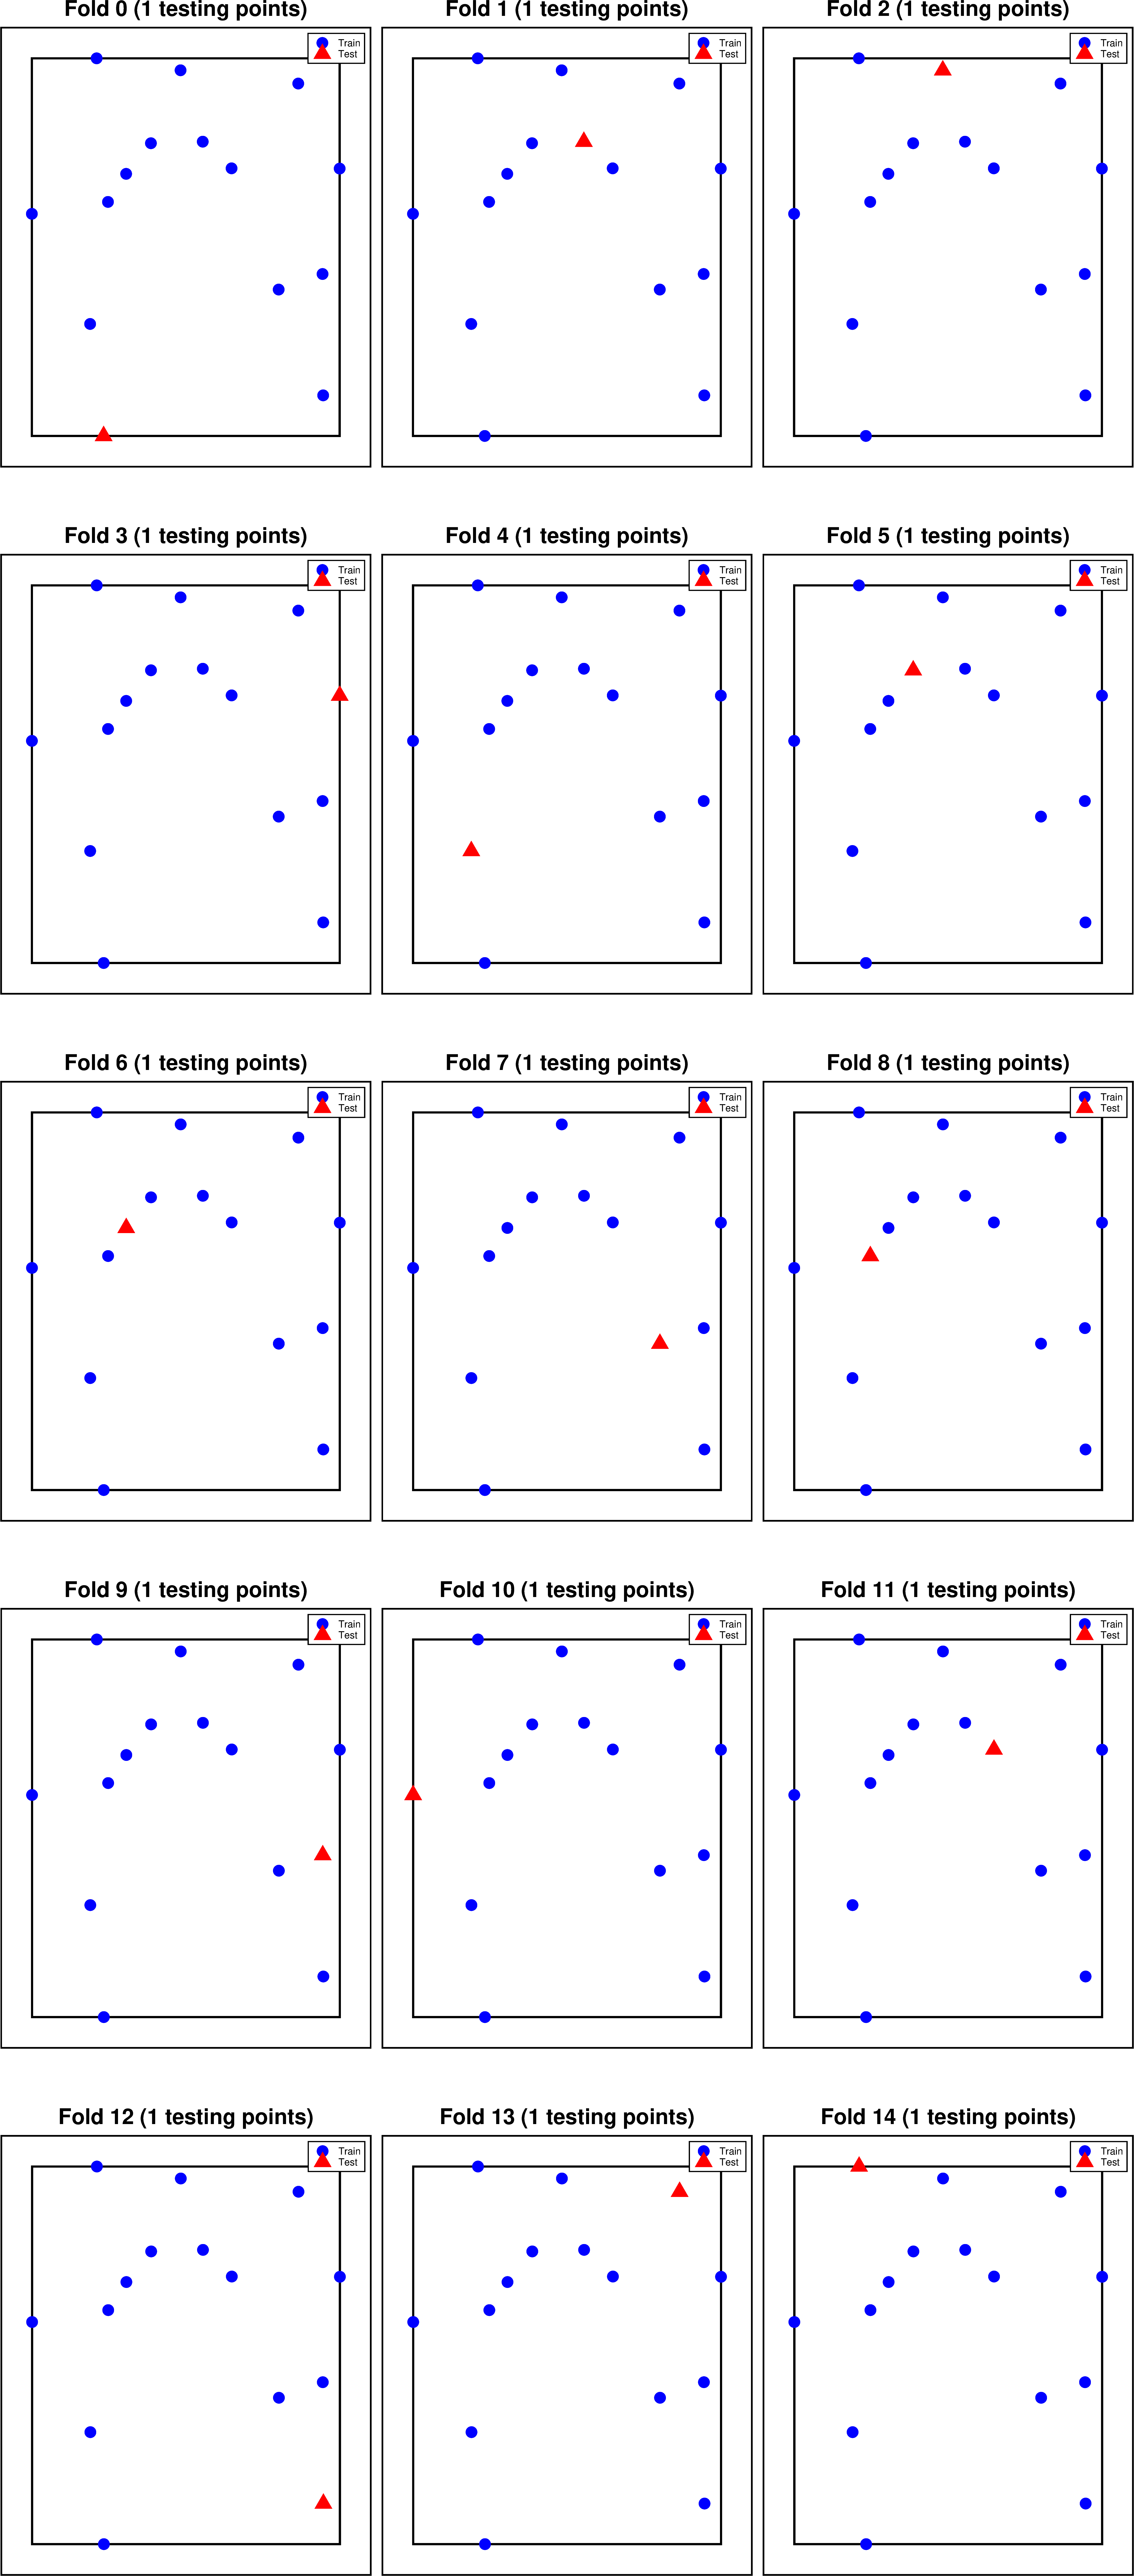

easting       northing       upward fold_0 fold_1 fold_2 fold_3  \
0    93942.740553  165086.148419 -6166.691339   test  train  train  train   
1   185744.836752  437747.618234 -5230.910817  train   test  train  train   
2   165200.779866  503888.251841 -4551.466895  train  train   test  train   
3   312585.151503  412789.886738 -6178.090981  train  train  train   test   
4    81410.282014  268837.863004 -4562.000830  train  train  train  train   
5   137758.290763  436305.416136 -3739.300871  train  train  train  train   
6   114799.031988  407905.723662 -4037.824297  train  train  train  train   
7   256089.893751  300737.319016 -8556.923537  train  train  train  train   
8    97955.917590  381913.273733 -3696.069980  train  train  train  train   
9   296715.509301  315109.665385 -7771.865470  train  train  train  train   
10   27437.029770  370907.112964 -1383.763355  train  train  train  train   
11  212464.442079  413038.244716 -5835.762415  train  train  train  train   
12  297311.998972  202734.681191 -8882.480862  train  train  train  train   
13  274253.699476  491584.093601 -7000.722903  train  train  train  train   
14   87441.415368  514943.513495 -2611.977474  train  train  train  train   

   fold_4 fold_5 fold_6 fold_7 fold_8 fold_9 fold_10 fold_11 fold_12 fold_13  \
0   train  train  train  train  train  train   train   train   train   train   
1   train  train  train  train  train  train   train   train   train   train   
2   train  train  train  train  train  train   train   train   train   train   
3   train  train  train  train  train  train   train   train   train   train   
4    test  train  train  train  train  train   train   train   train   train   
5   train   test  train  train  train  train   train   train   train   train   
6   train  train   test  train  train  train   train   train   train   train   
7   train  train  train   test  train  train   train   train   train   train   
8   train  train  train  train   test  train   train   train   train   train   
9   train  train  train  train  train   test   train   train   train   train   
10  train  train  train  train  train  train    test   train   train   train   
11  train  train  train  train  train  train   train    test   train   train   
12  train  train  train  train  train  train   train   train    test   train   
13  train  train  train  train  train  train   train   train   train    test   
14  train  train  train  train  train  train   train   train   train   train   

   fold_14  
0    train  
1    train  
2    train  
3    train  
4    train  
5    train  
6    train  
7    train  
8    train  
9    train  
10   train  
11   train  
12   train  
13   train  
14    test

In [21]:
leave_one_out_split_df = cross_validation.split_test_train(
    constraint_points,
    method="LeaveOneOut",
    plot=True,
)
leave_one_out_split_df

#### 3) Block K-Fold 
The third, and in most circumstances best approach is a **Block K-Fold**. For this the constraints are split into testing and training sets **K** times, and the cross-validation is performed for each of these **K** folds. Since spatial data is common auto-correlated (nearby points have similar values), to ensure we don't overestimate cross-validation scores, it is best to split the data into spatial blocks, then split the data within these blocks into the *training* and *testing* sets. 

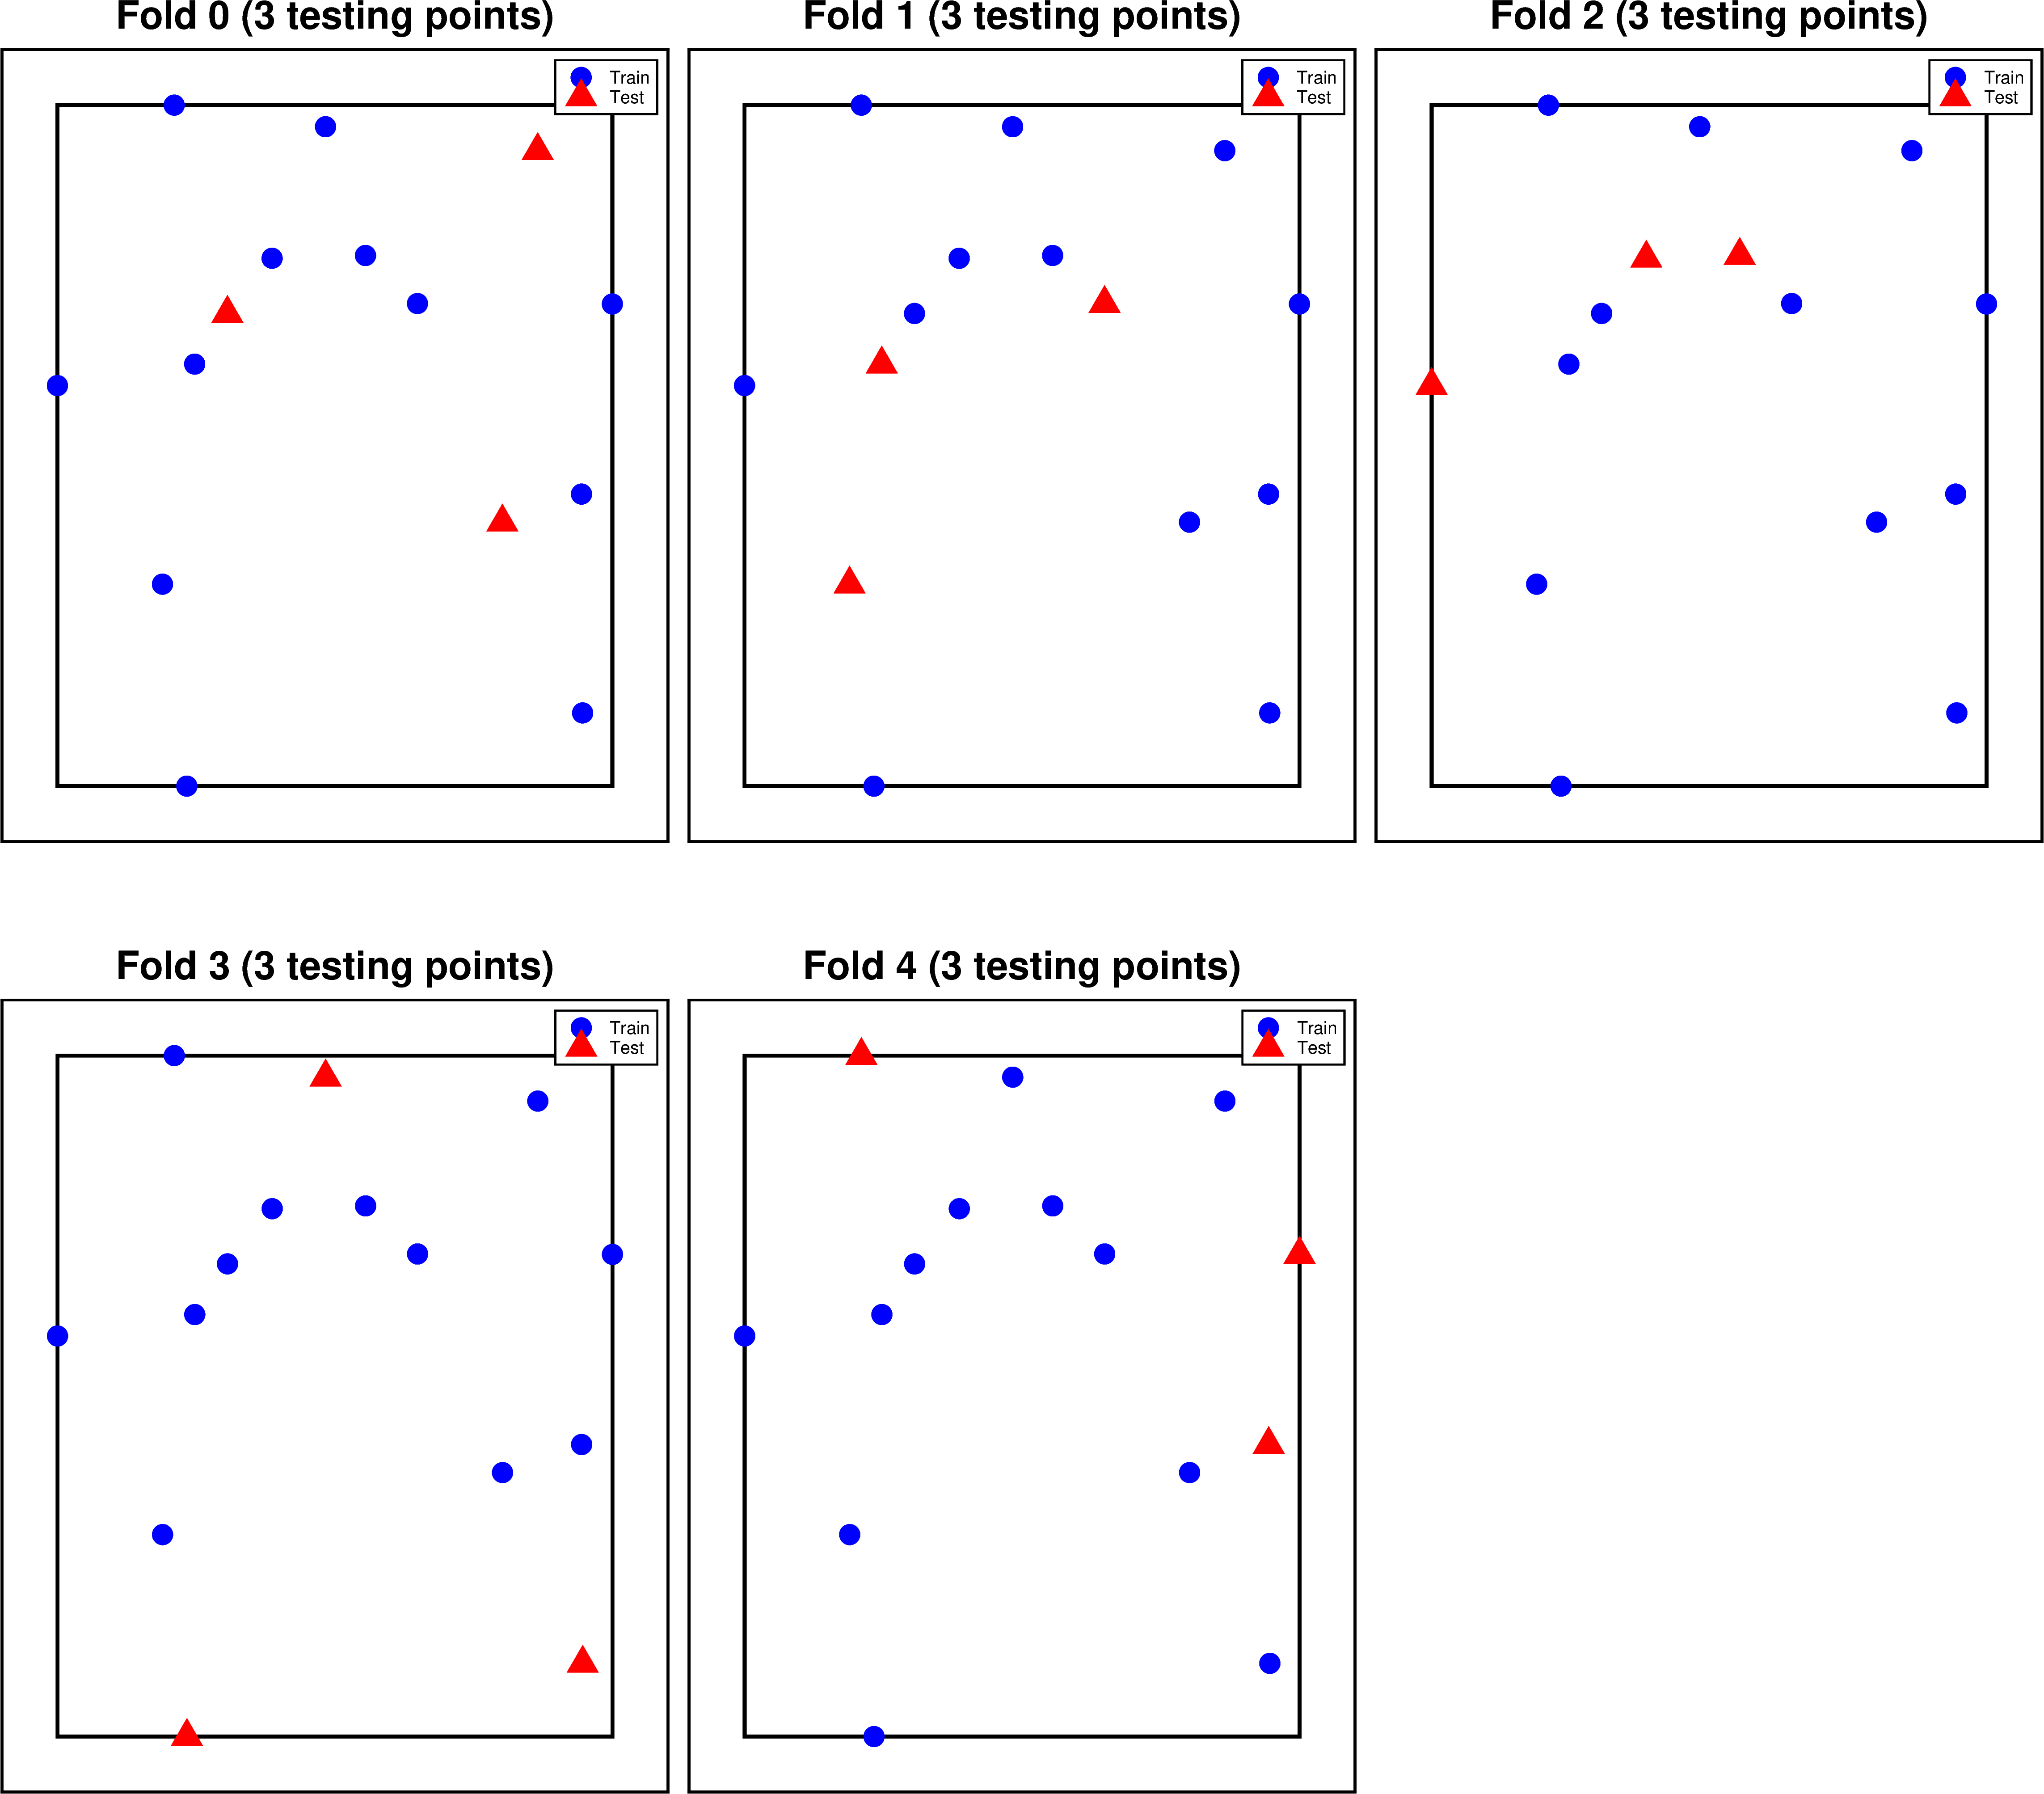

easting       northing       upward fold_0 fold_1 fold_2 fold_3  \
0    93942.740553  165086.148419 -6166.691339  train  train  train   test   
1   185744.836752  437747.618234 -5230.910817  train  train   test  train   
2   165200.779866  503888.251841 -4551.466895  train  train  train   test   
3   312585.151503  412789.886738 -6178.090981  train  train  train  train   
4    81410.282014  268837.863004 -4562.000830  train   test  train  train   
5   137758.290763  436305.416136 -3739.300871  train  train   test  train   
6   114799.031988  407905.723662 -4037.824297   test  train  train  train   
7   256089.893751  300737.319016 -8556.923537   test  train  train  train   
8    97955.917590  381913.273733 -3696.069980  train   test  train  train   
9   296715.509301  315109.665385 -7771.865470  train  train  train  train   
10   27437.029770  370907.112964 -1383.763355  train  train   test  train   
11  212464.442079  413038.244716 -5835.762415  train   test  train  train   
12  297311.998972  202734.681191 -8882.480862  train  train  train   test   
13  274253.699476  491584.093601 -7000.722903   test  train  train  train   
14   87441.415368  514943.513495 -2611.977474  train  train  train  train   

   fold_4  
0   train  
1   train  
2   train  
3    test  
4   train  
5   train  
6   train  
7   train  
8   train  
9    test  
10  train  
11  train  
12  train  
13  train  
14   test

In [22]:
block_kfold_split_df = cross_validation.split_test_train(
    constraint_points,
    method="KFold",
    # spacing=spacing,
    shape=(20, 20),
    plot=True,
)
block_kfold_split_df

### Report the scores for constraint point minimization

Now that the constraint points are split into *testing* and *training* sets, we can perform a constrain point minimization regional field estimation and calculate the scores for how well it performed.

The constraint point minimization technique works by sampling the gravity misfit values at the constraints points, interpolating across the entire grid region with just the points to create the regional misfit grid, then subtracting this from the total misfit grid to get the residual misfit grid. 

Once the gravity misfit values are sampled, there are 3 methods for how to perform the interpolation: 
1) gridding with **tensioned minimum curvature** using PyGMT. This includes a hyperparameter of the tension factor (0-1).
2) gridding with **bi-harmonic splines** using Verde. This includes the hyperparameter of the damping factor. 
3) gridding with **equivalent sources** using Harmonica. This includes several hyperparameters; source depth, damping factor, block size, and synthetic gravity observation elevation.

In the `regional_separation_score` function, the argument `constraints_df` is used for the constraint point minimization, while the argument `testing_df` is used for calculating the scores.

In [23]:
# values needed in all the regional separation techniques
kwargs = {
    "grav_df": grav_df,
    "grav_data_column": "misfit",
    "regional_column": "reg",
    # "score_as_median":True,
    "true_regional": grav_grid.moho_grav,
}

In [24]:
constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="constraints",
        grid_method="pygmt",
        tension_factor=0.3,
        constraints_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        **kwargs,
    )
)
print(
    "Scores with tensioned minimum curvature gridding:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="constraints",
        grid_method="verde",
        spline_damping=0.1,
        constraints_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        **kwargs,
    )
)
print(
    "Scores with bi-harmonic splines gridding:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

constraint_RMS_score, residual_RMS_score, _, _ = (
    cross_validation.regional_separation_score(
        method="constraints",
        grid_method="eq_sources",
        eq_damping=10,
        block_size=10e3,
        source_depth=10e3,
        grav_obs_height=1e3,
        constraints_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        **kwargs,
    )
)
print(
    "Scores with equivalent sources gridding:\n"
    f"\tRMS of residual at constraint points: {constraint_RMS_score}\n",
    f"\tRMS of residual everywhere: {residual_RMS_score}",
)

Scores with tensioned minimum curvature gridding:
	RMS of residual at constraint points: 65.92560501274508
 	RMS of residual everywhere: 53.35238306770418
Scores with bi-harmonic splines gridding:
	RMS of residual at constraint points: 69.74501103572513
 	RMS of residual everywhere: 54.635976368486226
Scores with equivalent sources gridding:
	RMS of residual at constraint points: 55.52707410181841
 	RMS of residual everywhere: 88.71247792477403


### Optimization for hyperparameter values
Now we can repeat this regional estimation for a range of hyperparameter values and see which value gives the best set of scores.

To start, we will use the *testing* and *training* constraint splits from the **random split** method.

#### Random Split Optimization

##### Tensioned Minimum Curvature with PyGMT

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 9
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 6
INFO:root:	parameter: {'tension_factor': 0.9770922524005171}
INFO:root:	scores: [60.23489738805612, 52.9042274023589]


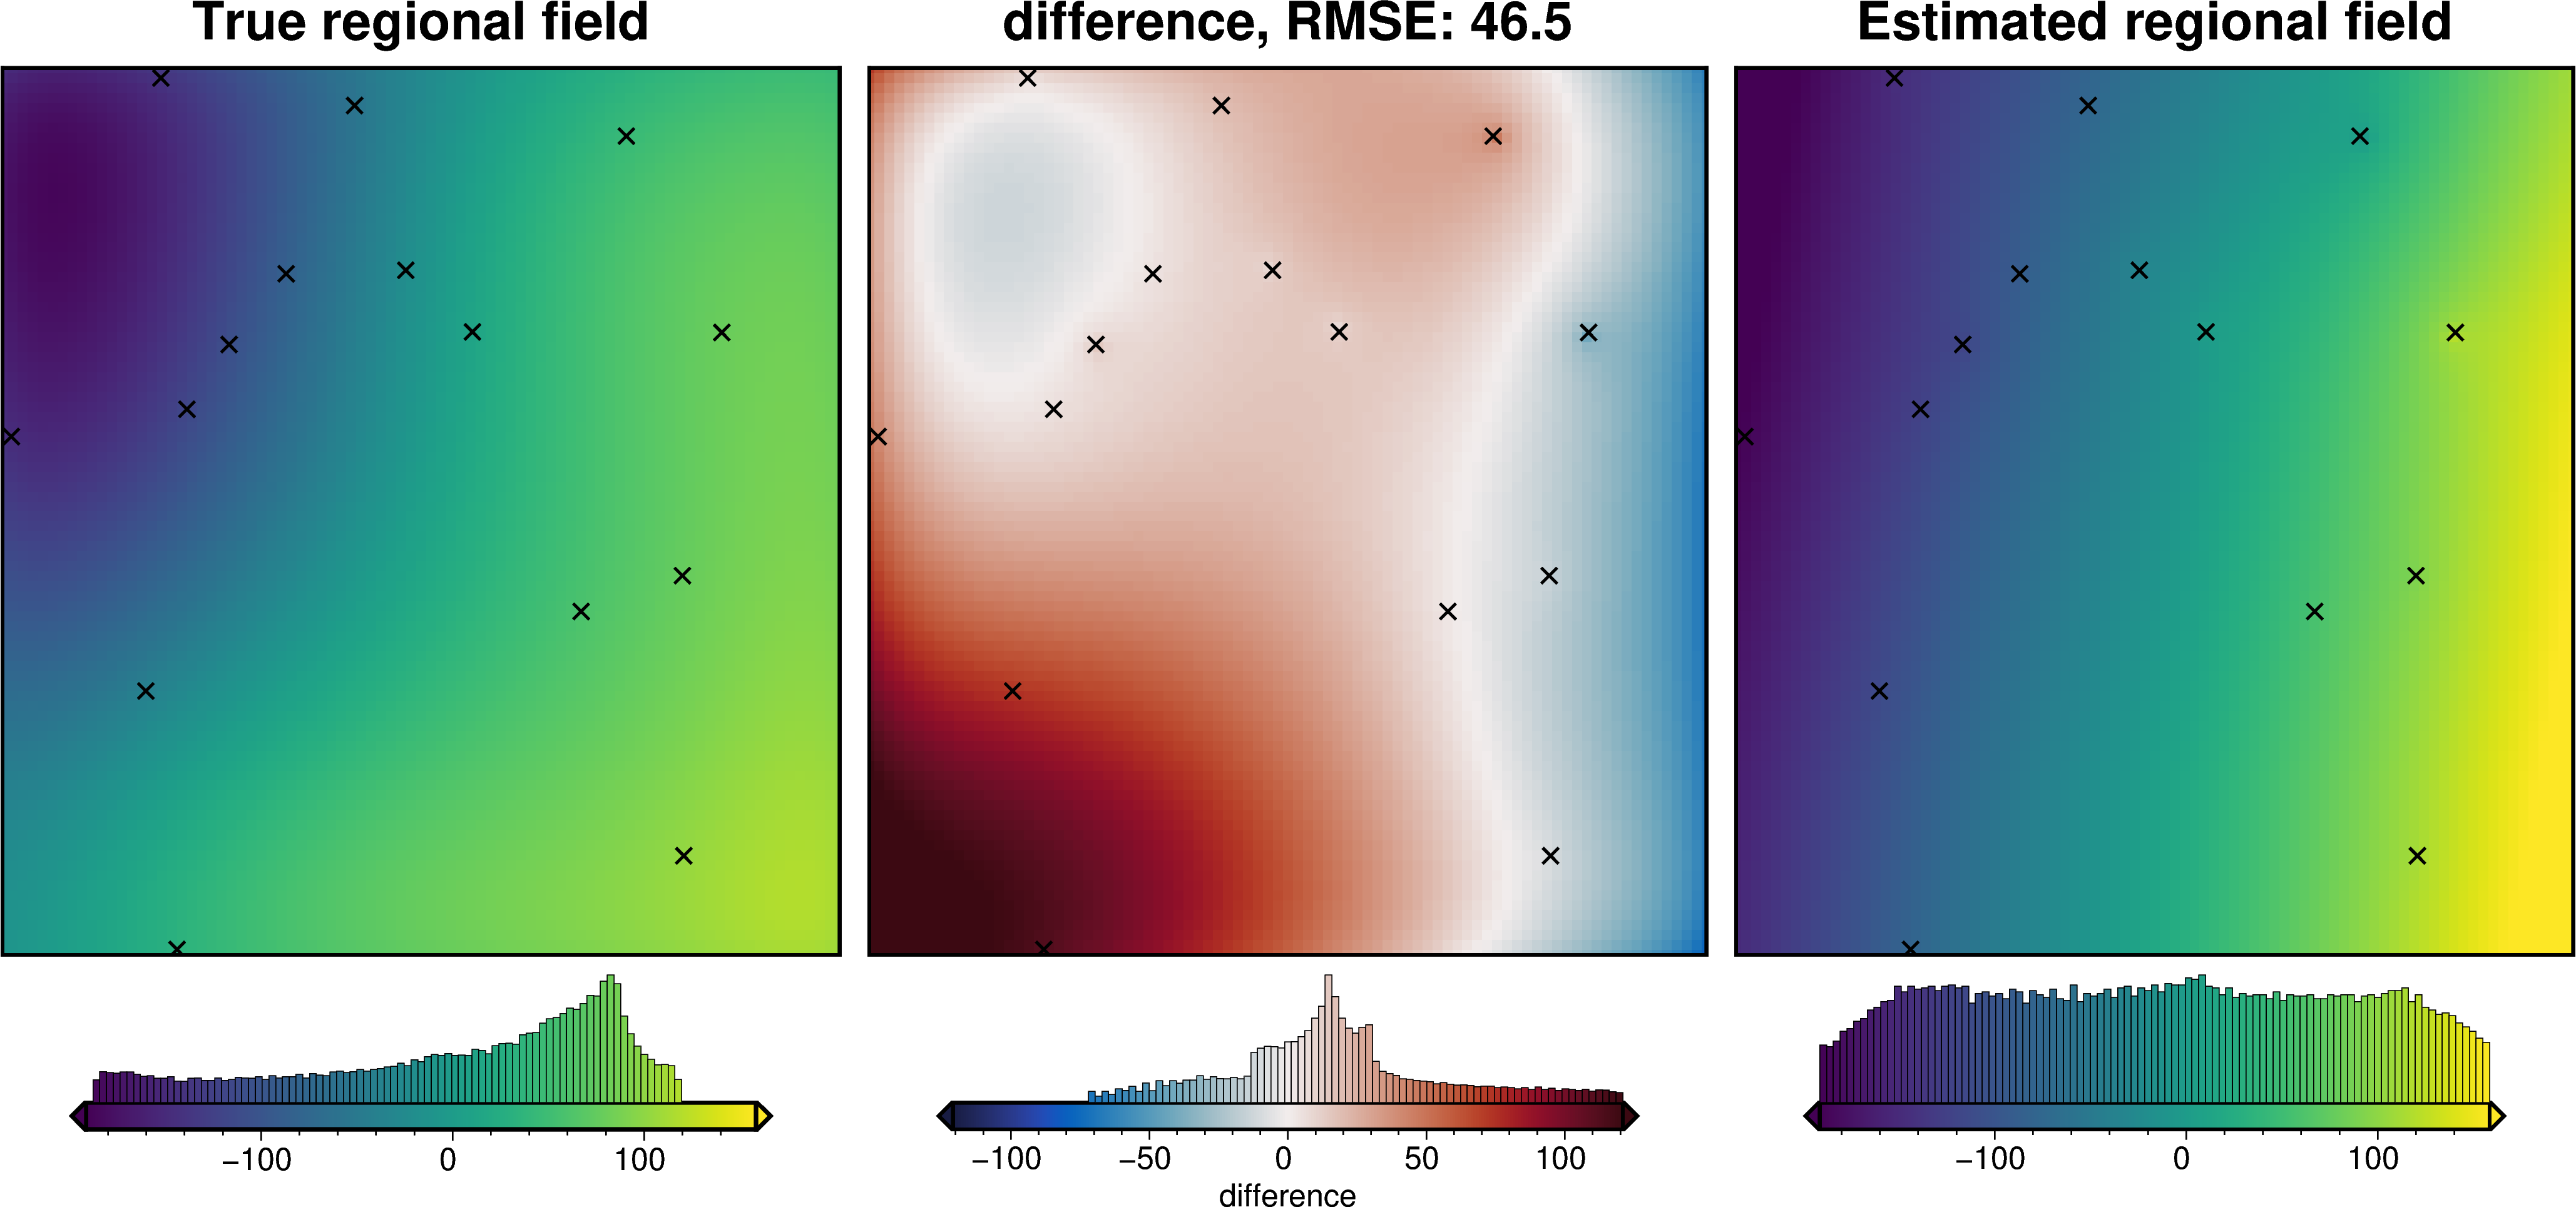

In [25]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        training_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        grid_method="pygmt",
        tension_factor_limits=[0, 1],
        n_trials=20,
        plot=True,
        plot_grid=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

##### Bi-Harmonic Splines with Verde

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 5
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 19
INFO:root:	parameter: {'spline_damping': 26.49486785254378}
INFO:root:	scores: [16.686285438300654, 56.24906483618217]


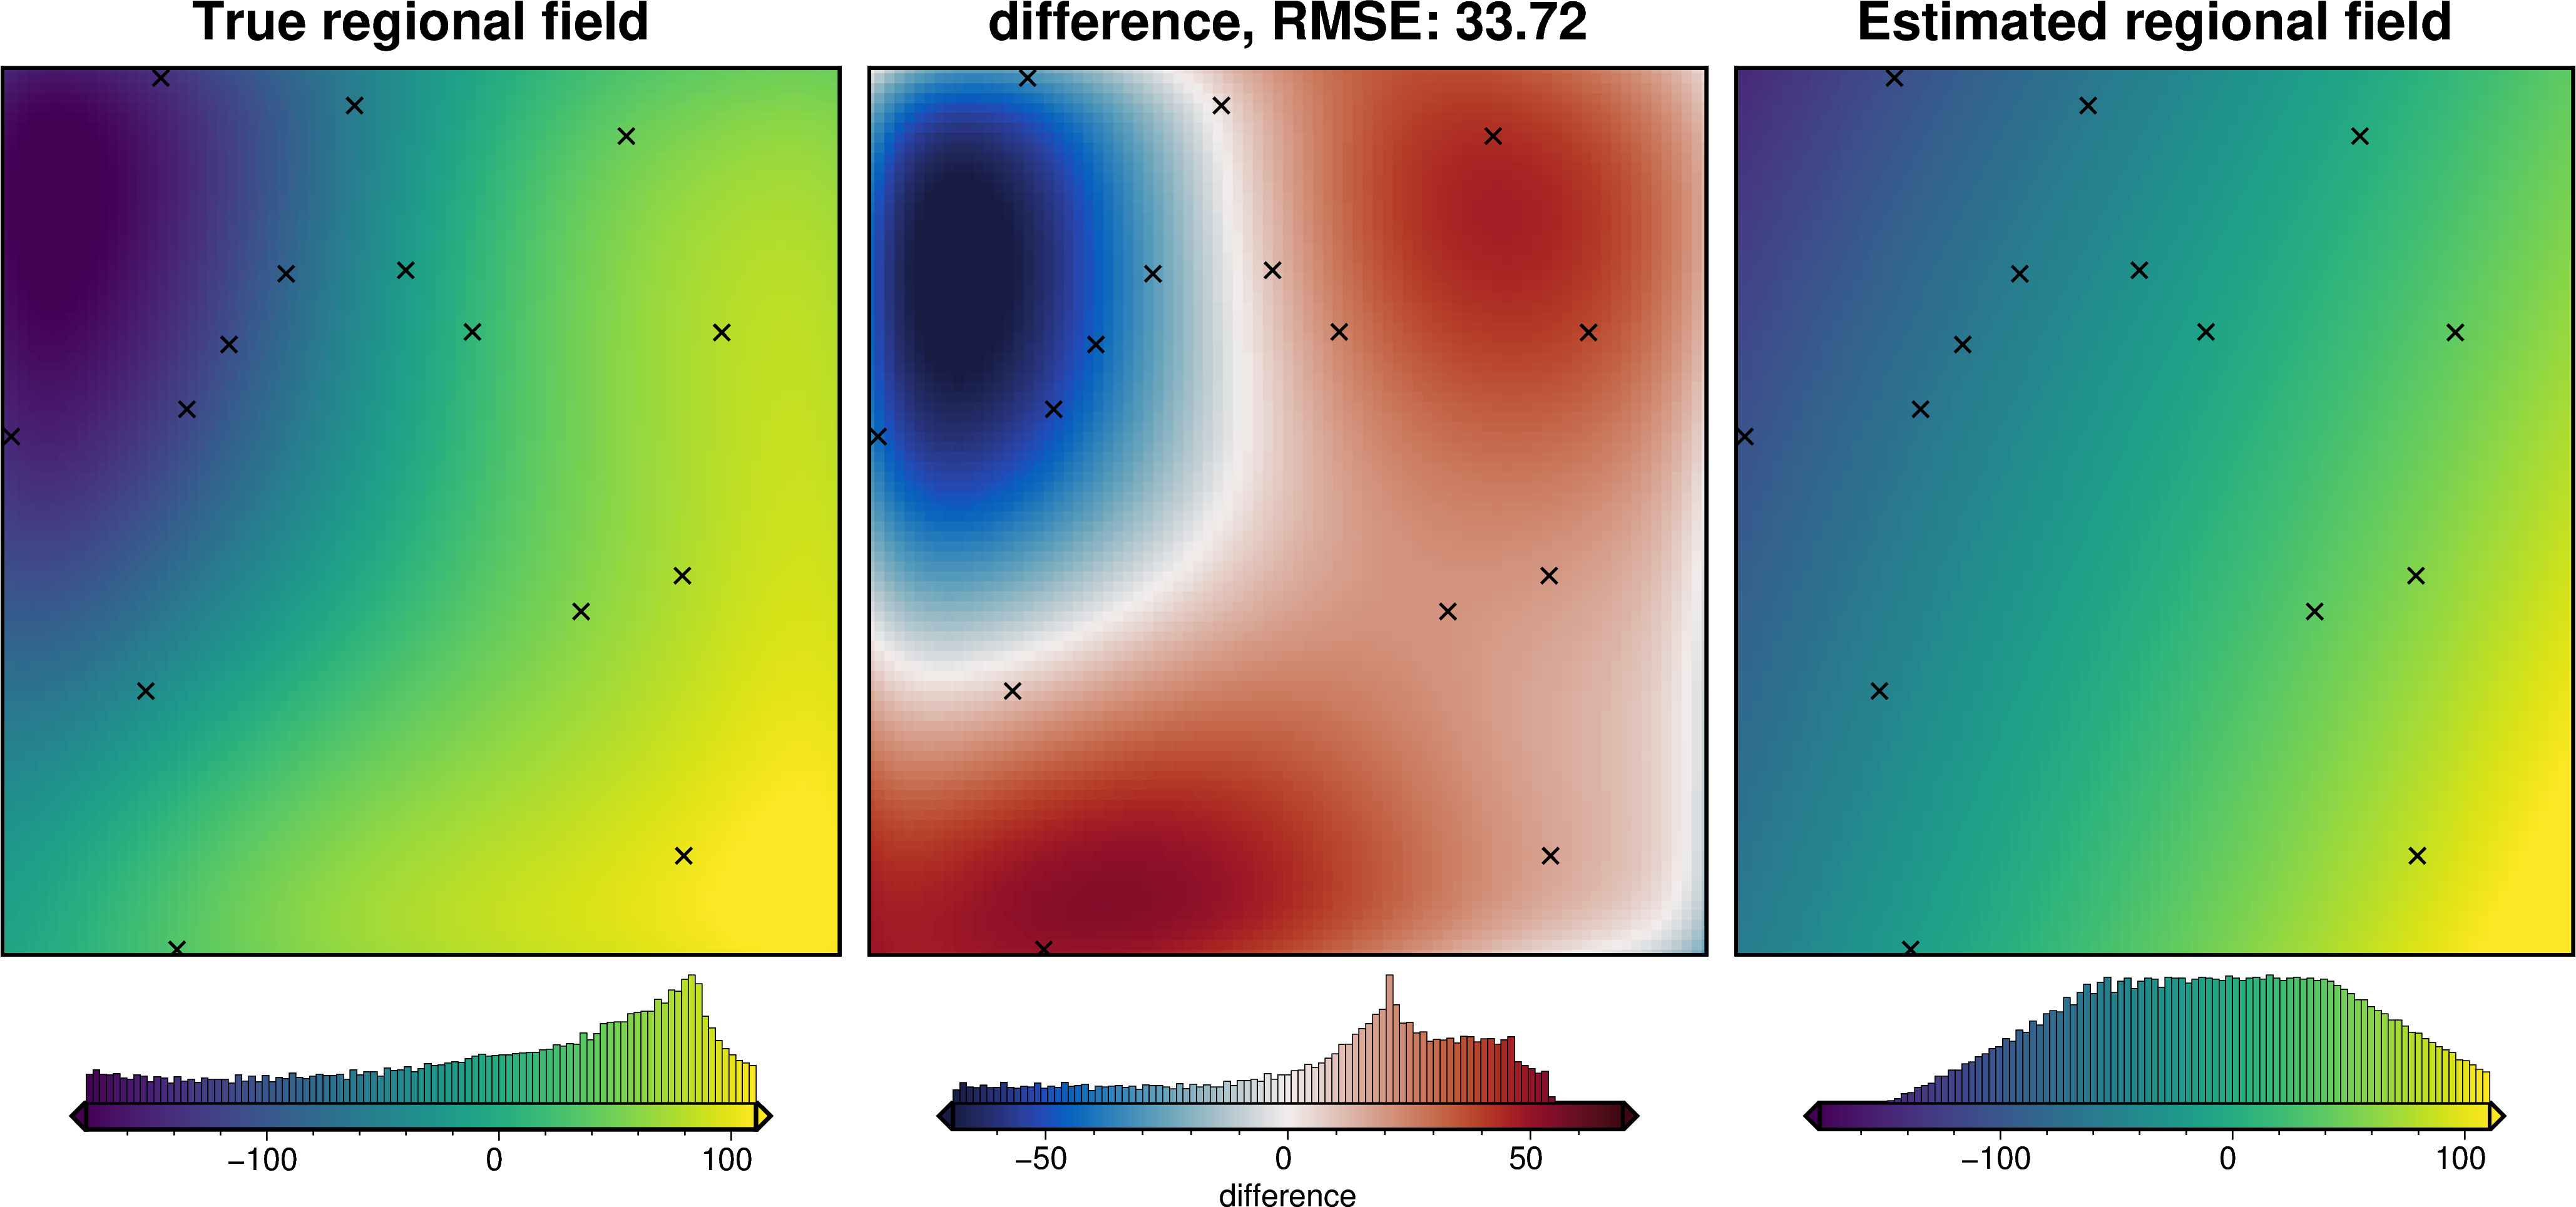

In [26]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        training_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        grid_method="verde",
        spline_damping_limits=[1e-10, 1e3],
        n_trials=20,
        plot=True,
        plot_grid=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

##### Equivalent Sources with Harmonica
This gridding method has 4 parameters which can be tuned during the gridding. In this synthetic example we know the true regional gravity component, which is the forward gravity of the Moho model. With this, we can run the optimization based on minimizing the difference between the calculated regional and the true regional. This should give us a sense of which of these four hyperparameters are important, and which can be omitted. 

As you can see below, the *block_size* and *grav_obs_height* parameters are not very important to accurately estimating the regional field in this example. So in the next optimization where we are not using the true regional as the objective, we can use a constant value for the block size and greatly reduce the parameter space we need to explore. 

  0%|          | 0/80 [00:00<?, ?it/s]

INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 47
INFO:root:	parameter: {'source_depth': 157801.89880393702, 'block_size': 50590.663761435535, 'eq_damping': 0.647743755480883, 'grav_obs_height': 28424.154483458617}
INFO:root:	scores: [21.28128030926115]


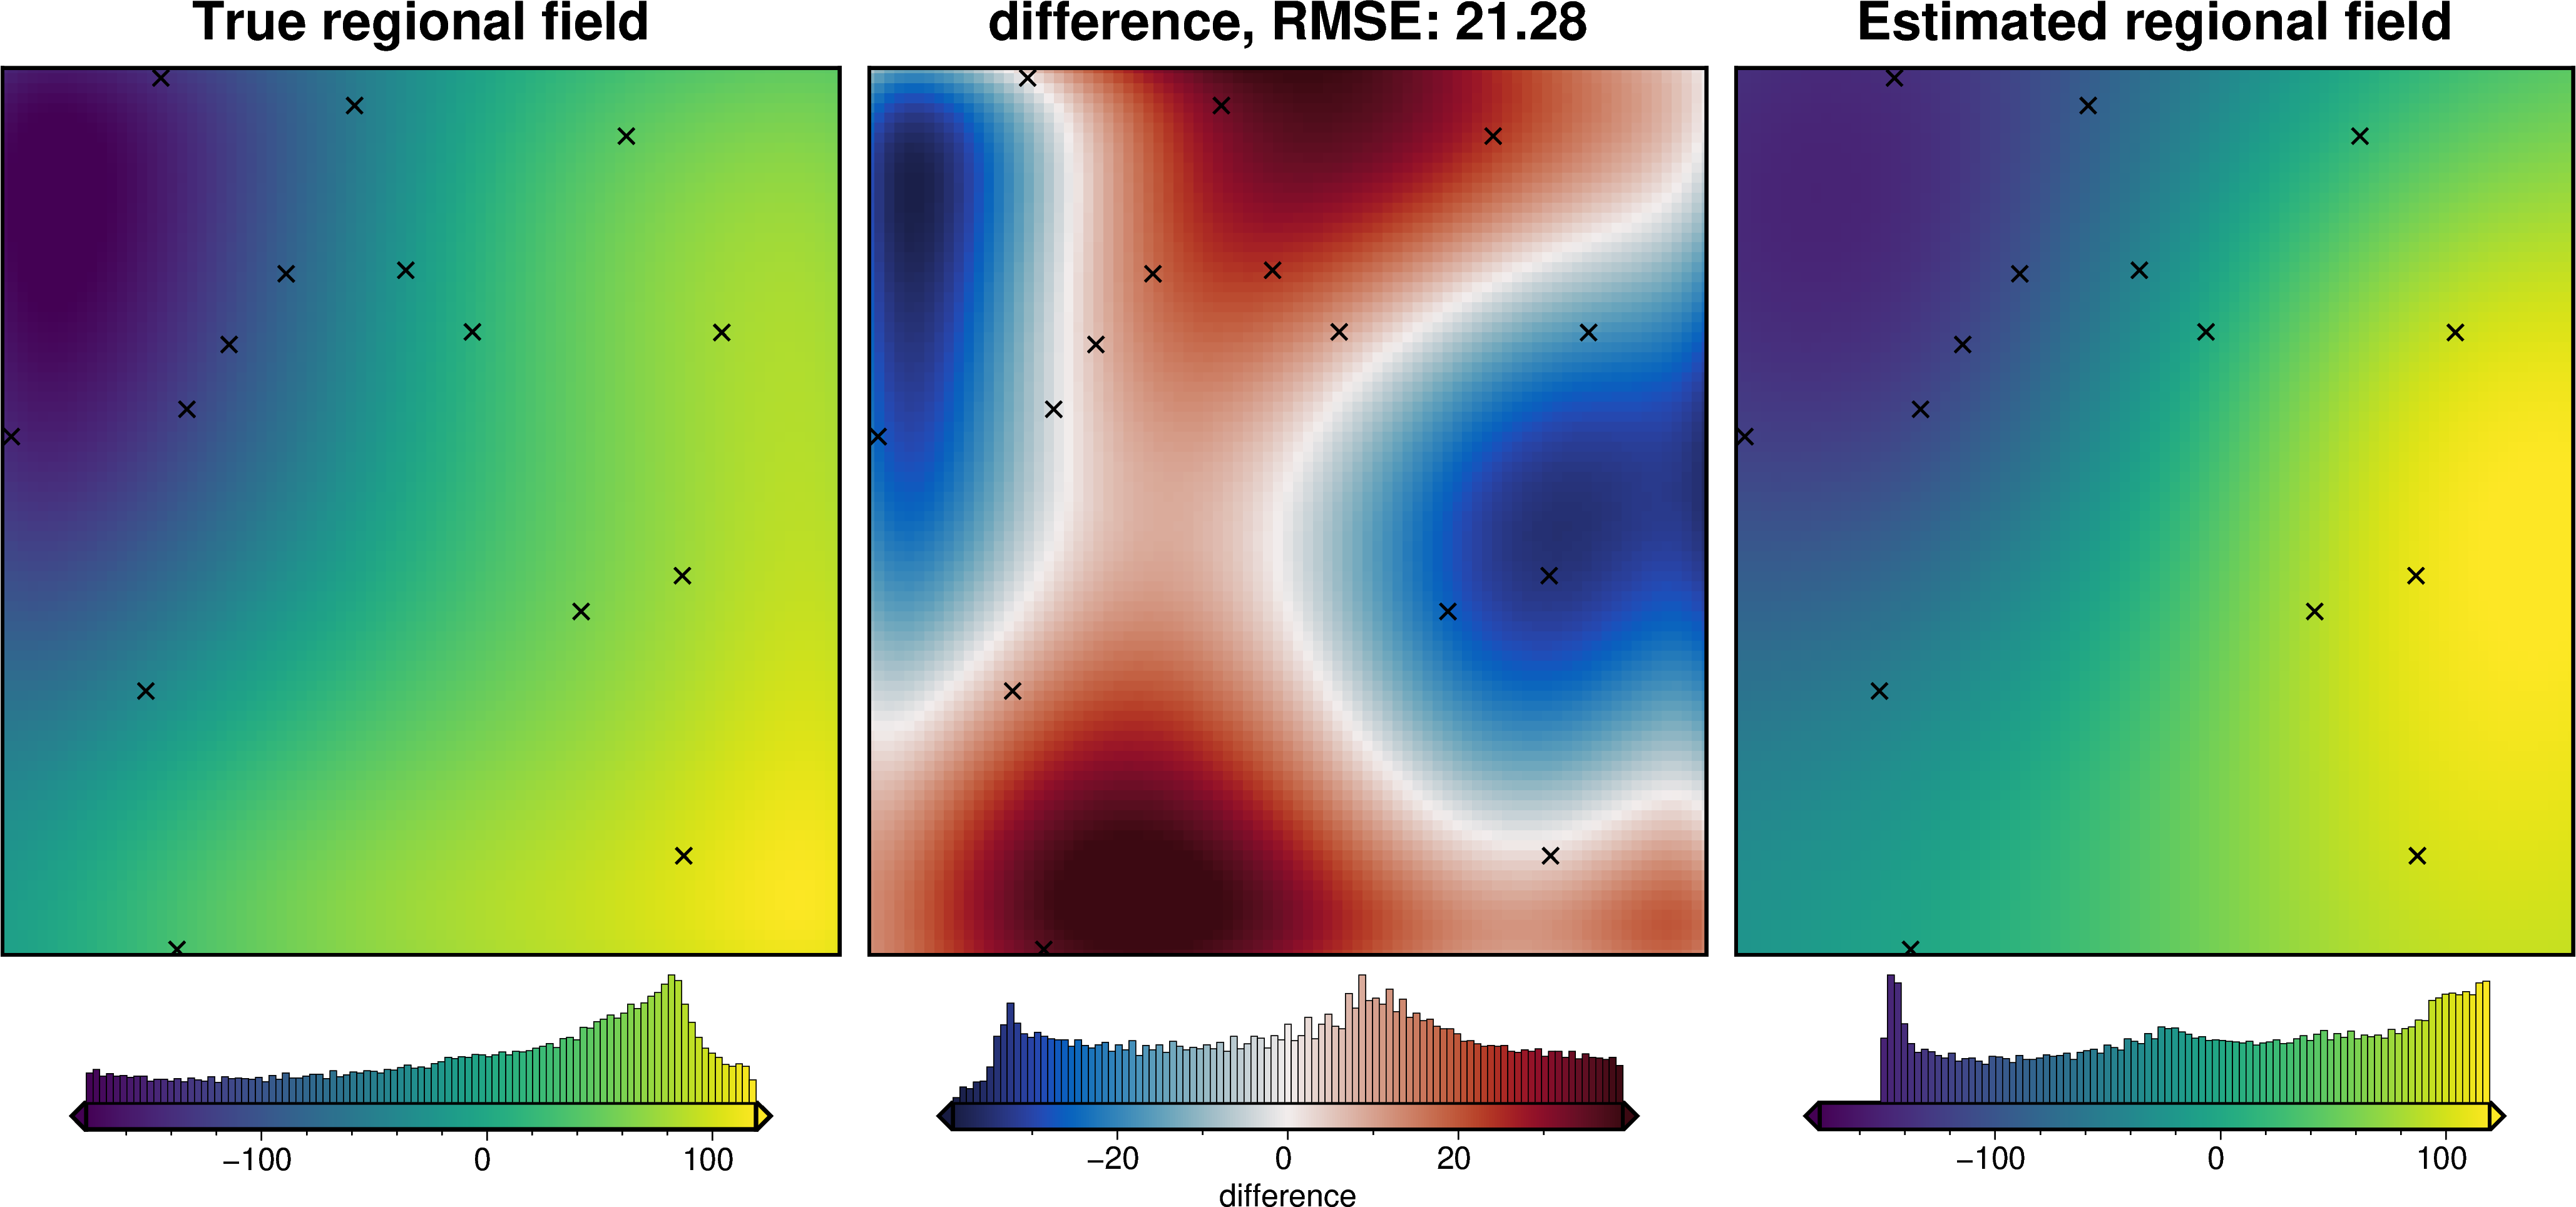

In [27]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        training_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        grid_method="eq_sources",
        source_depth_limits=[spacing * 20, spacing * 60],
        block_size_limits=[spacing * 10, spacing * 20],
        eq_damping_limits=[1e-10, 100],
        grav_obs_height_limits=[0, 50e3],
        n_trials=80,  # more trials needed since more parameters
        plot=True,
        plot_grid=False,
        optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

  0%|          | 0/80 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 47
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 46
INFO:root:	parameter: {'source_depth': 193971.04288644434, 'eq_damping': 0.0001546178290464412}
INFO:root:	scores: [18.172193433288523, 51.67841030799497]


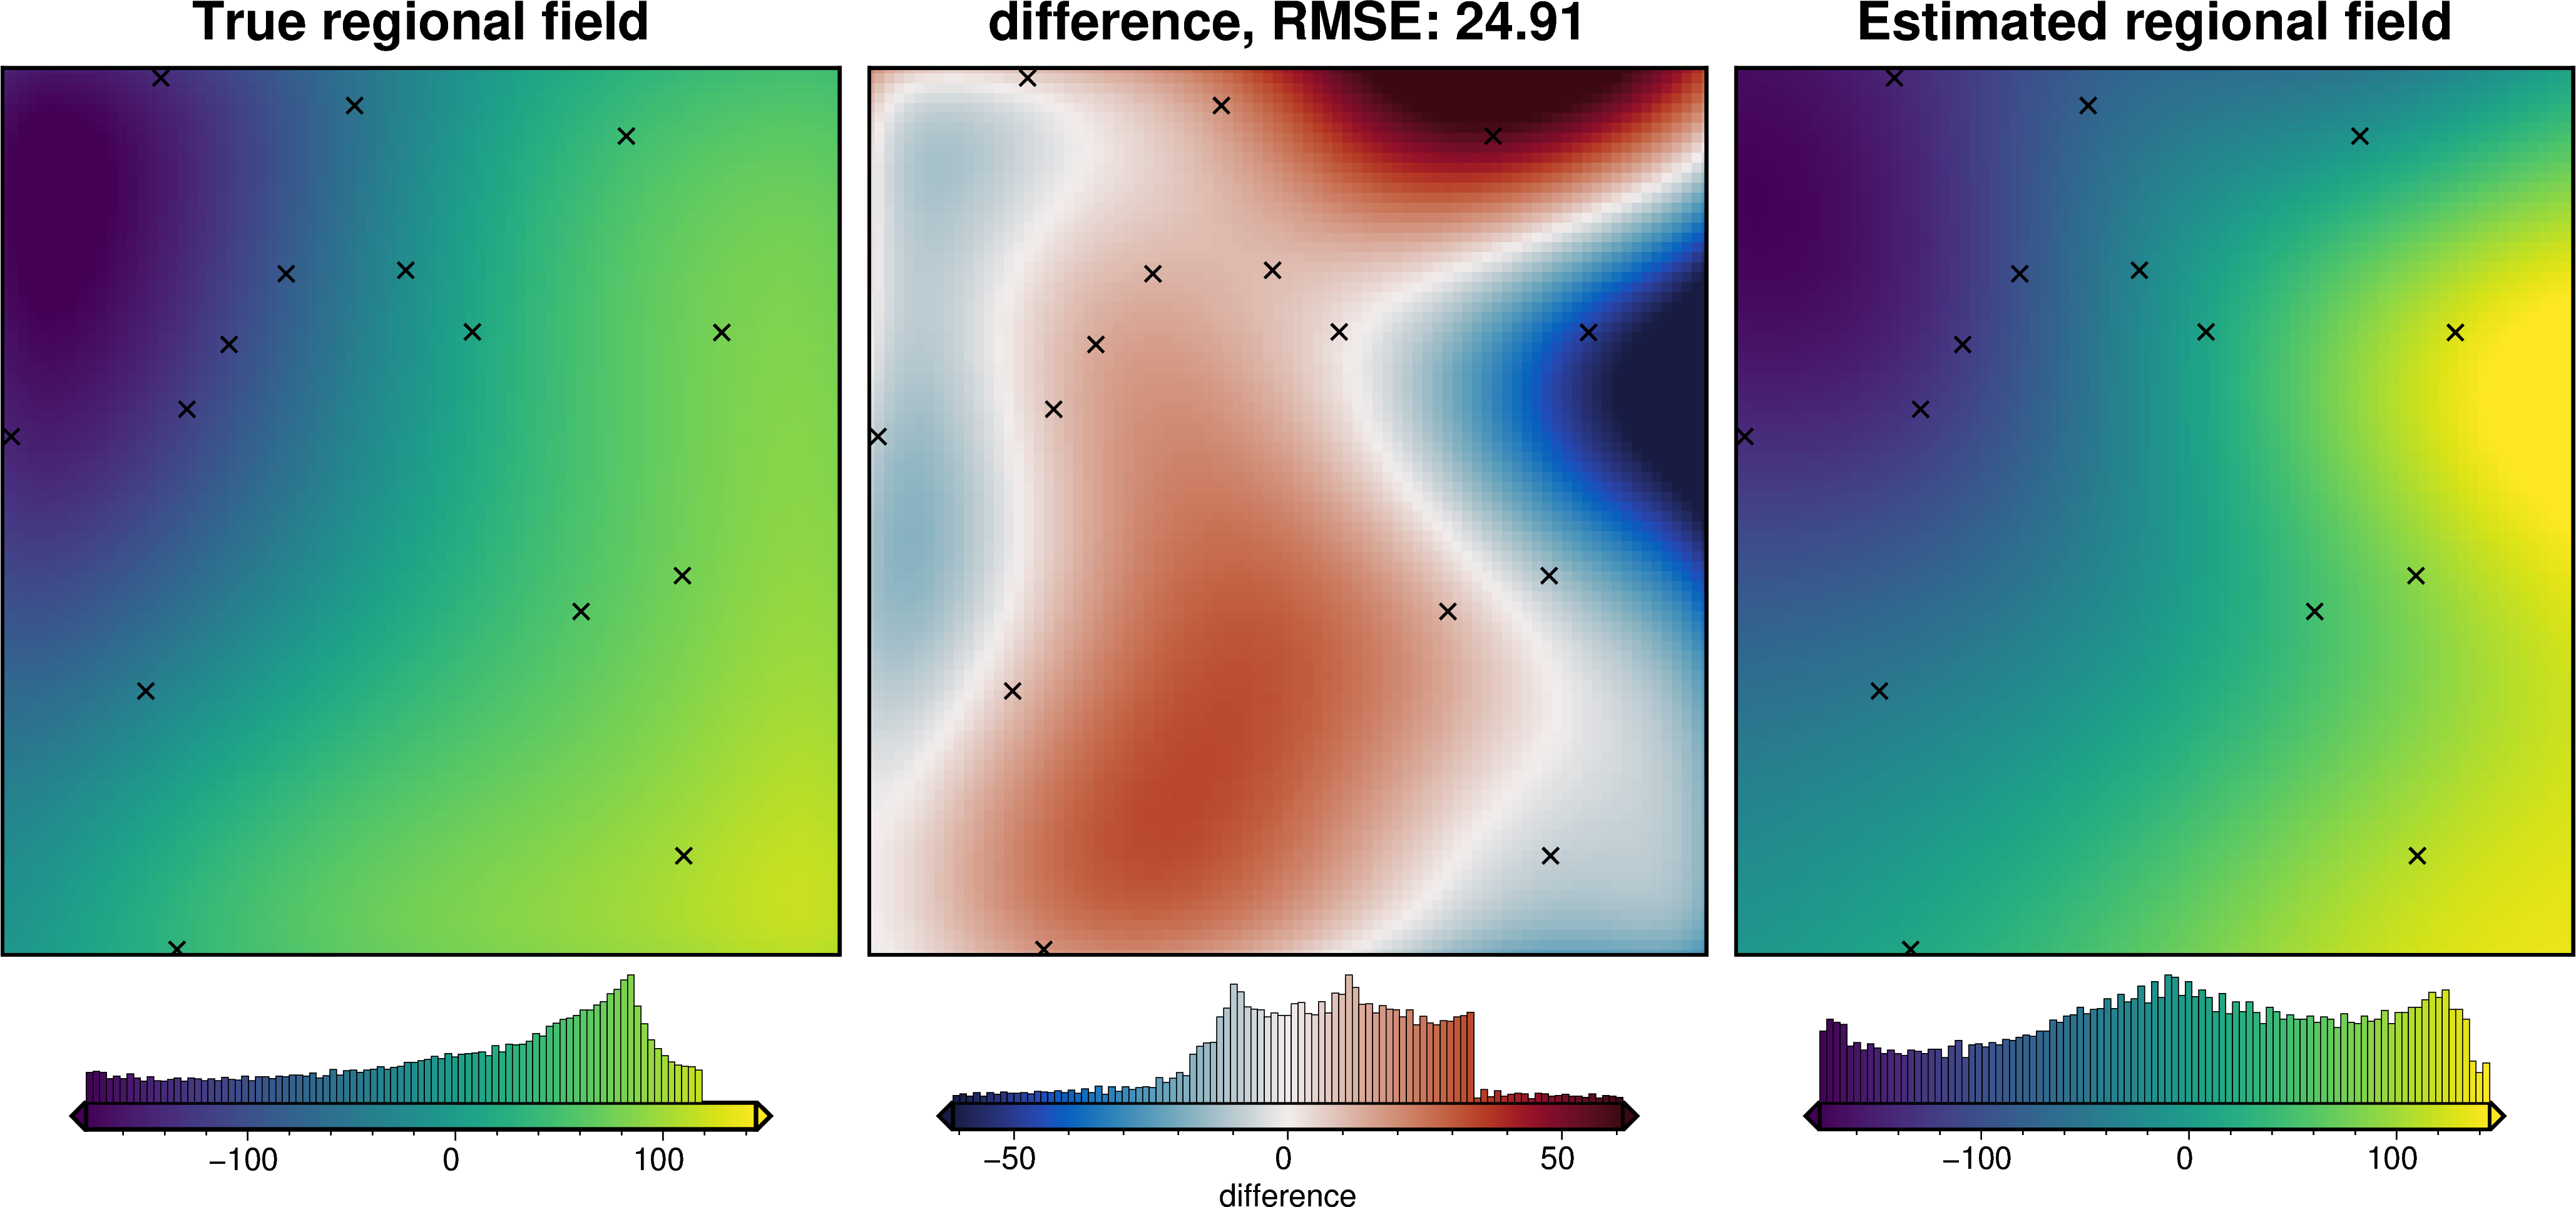

In [28]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization(
        training_df=random_split_df[random_split_df.train == True],  # noqa: E712
        testing_df=random_split_df[random_split_df.train == False],  # noqa: E712
        grid_method="eq_sources",
        source_depth_limits=[spacing * 20, spacing * 60],
        eq_damping_limits=[1e-10, 10],
        # if limits are omitted, must provide constant values
        block_size=spacing * 10,
        grav_obs_height=1e3,
        n_trials=80,  # more trials needed since more parameters
        plot=True,
        plot_grid=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

#### Leave-one-out Optimization

In [29]:
leave_one_out_split_df.head()

easting       northing       upward fold_0 fold_1 fold_2 fold_3  \
0   93942.740553  165086.148419 -6166.691339   test  train  train  train   
1  185744.836752  437747.618234 -5230.910817  train   test  train  train   
2  165200.779866  503888.251841 -4551.466895  train  train   test  train   
3  312585.151503  412789.886738 -6178.090981  train  train  train   test   
4   81410.282014  268837.863004 -4562.000830  train  train  train  train   

  fold_4 fold_5 fold_6 fold_7 fold_8 fold_9 fold_10 fold_11 fold_12 fold_13  \
0  train  train  train  train  train  train   train   train   train   train   
1  train  train  train  train  train  train   train   train   train   train   
2  train  train  train  train  train  train   train   train   train   train   
3  train  train  train  train  train  train   train   train   train   train   
4   test  train  train  train  train  train   train   train   train   train   

  fold_14  
0   train  
1   train  
2   train  
3   train  
4   train

##### Tensioned Minimum Curvature with PyGMT

INFO:root:training and testing data supplied as lists of dataframe, using them for a K-Folds cross validation


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 4
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 16
INFO:root:	parameter: {'tension_factor': 0.10265267582144938}
INFO:root:	scores: [23.389646643892018, 49.687802155462094]


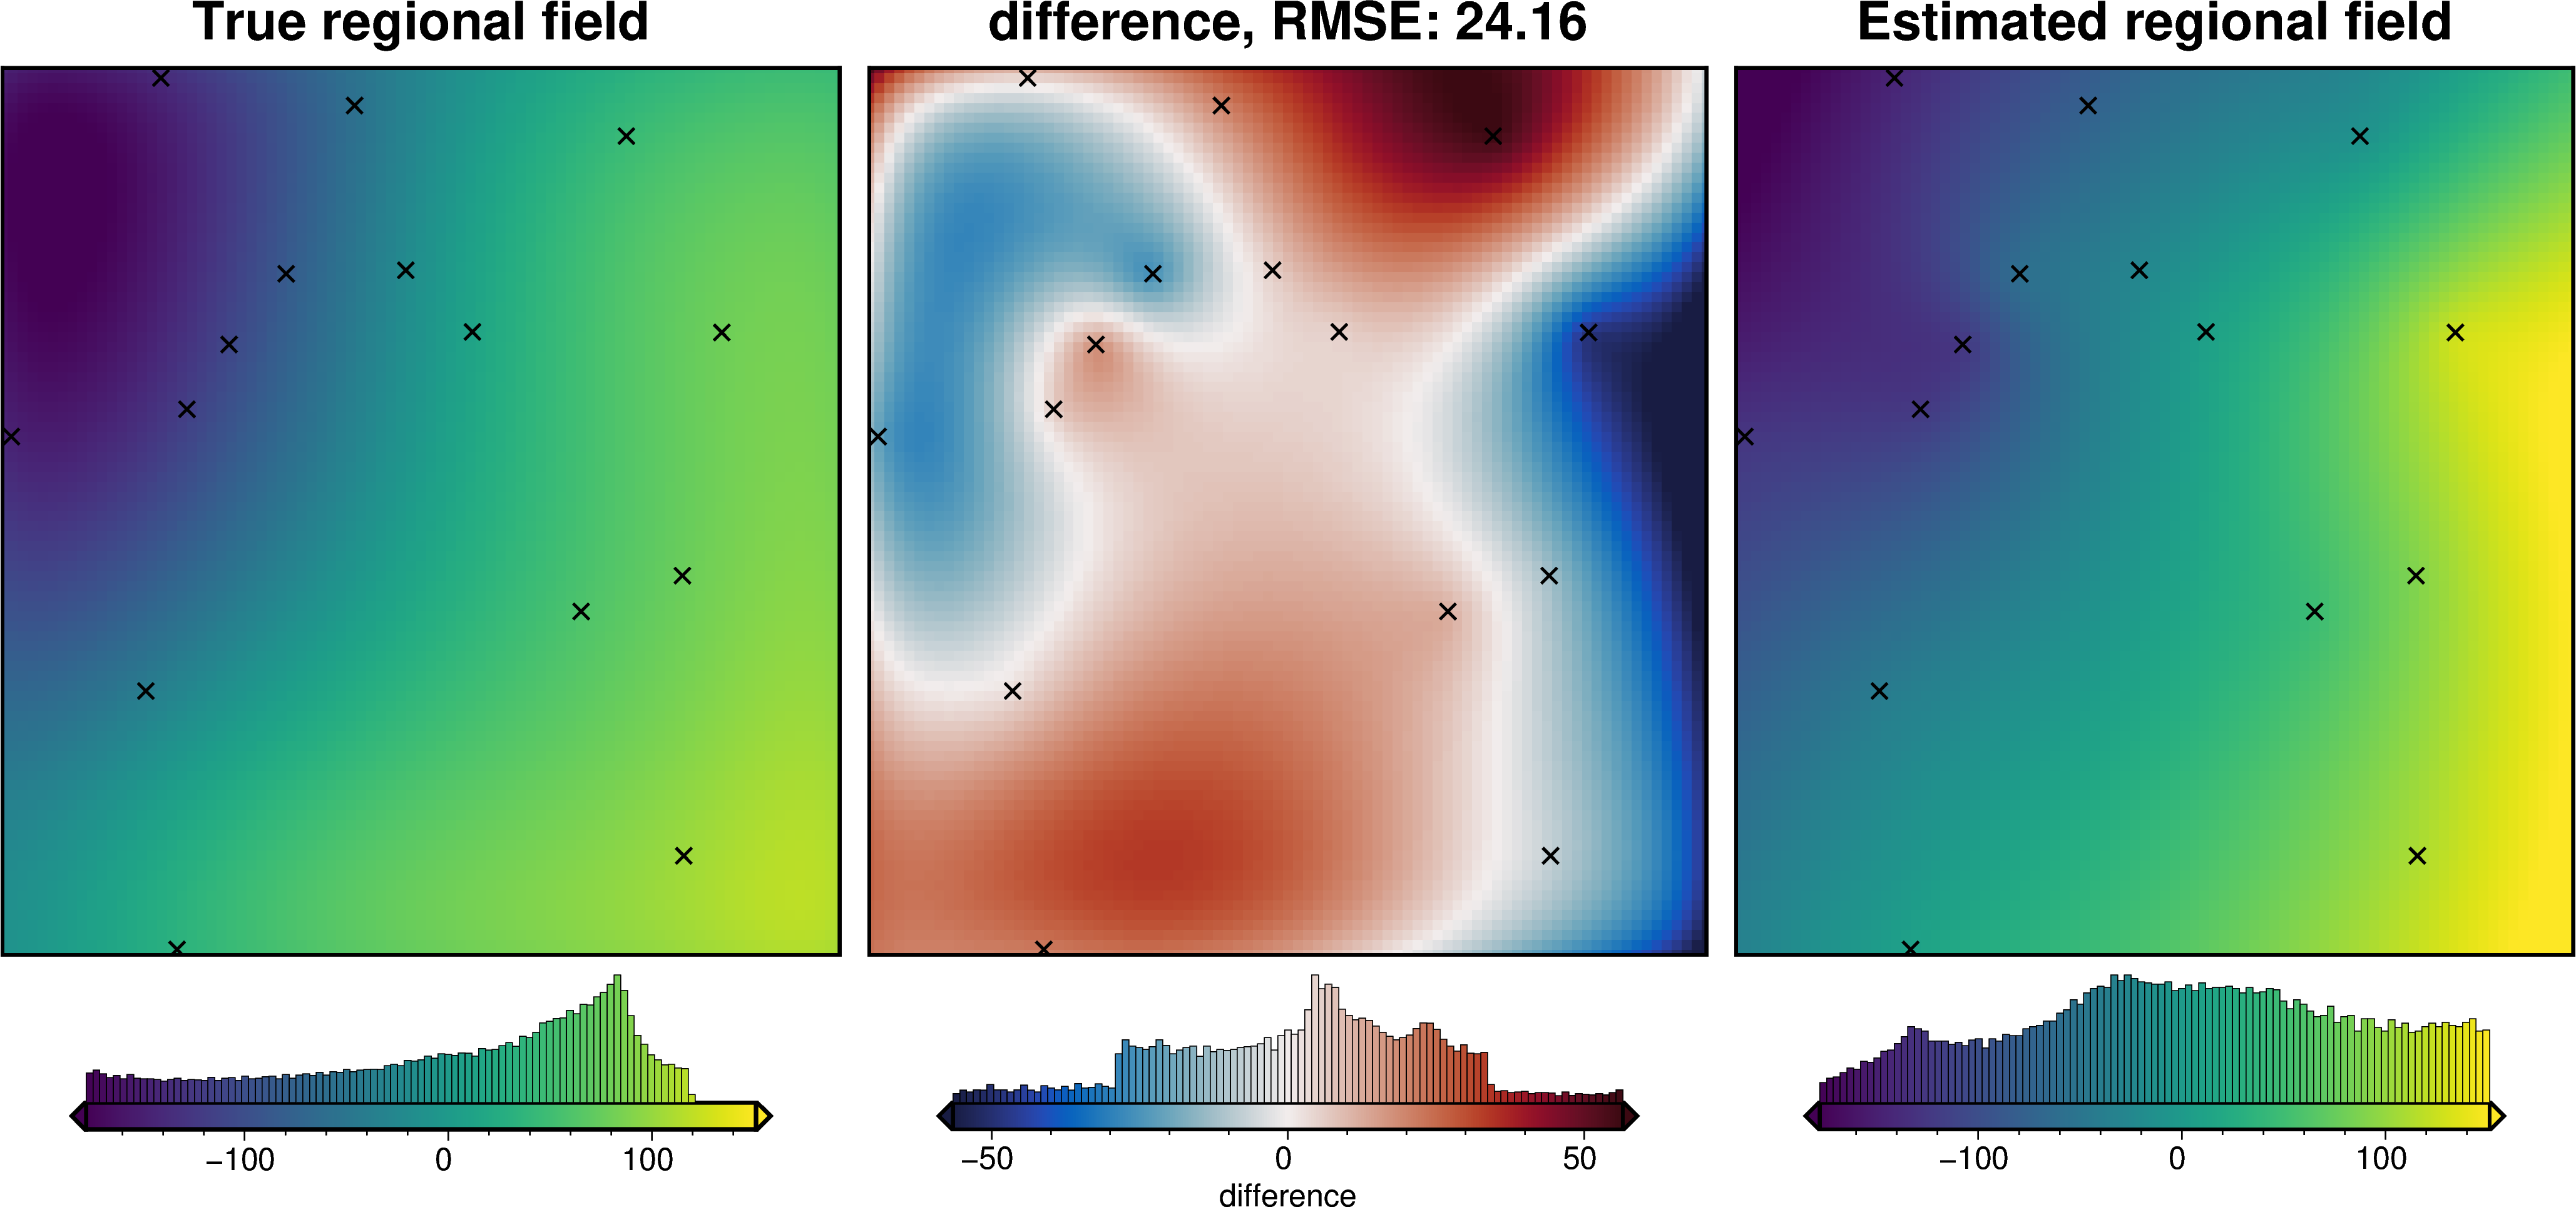

In [30]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization_kfolds(
        testing_training_df=leave_one_out_split_df,
        grid_method="pygmt",
        tension_factor_limits=[0, 1],
        n_trials=20,
        plot=True,
        plot_grid=False,
        fold_progressbar=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

##### Bi-Harmonic Splines with Verde

INFO:root:training and testing data supplied as lists of dataframe, using them for a K-Folds cross validation


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 12
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 1
INFO:root:	parameter: {'spline_damping': 1.8611241375516165e-10}
INFO:root:	scores: [20.698597282577087, 52.44694947641198]


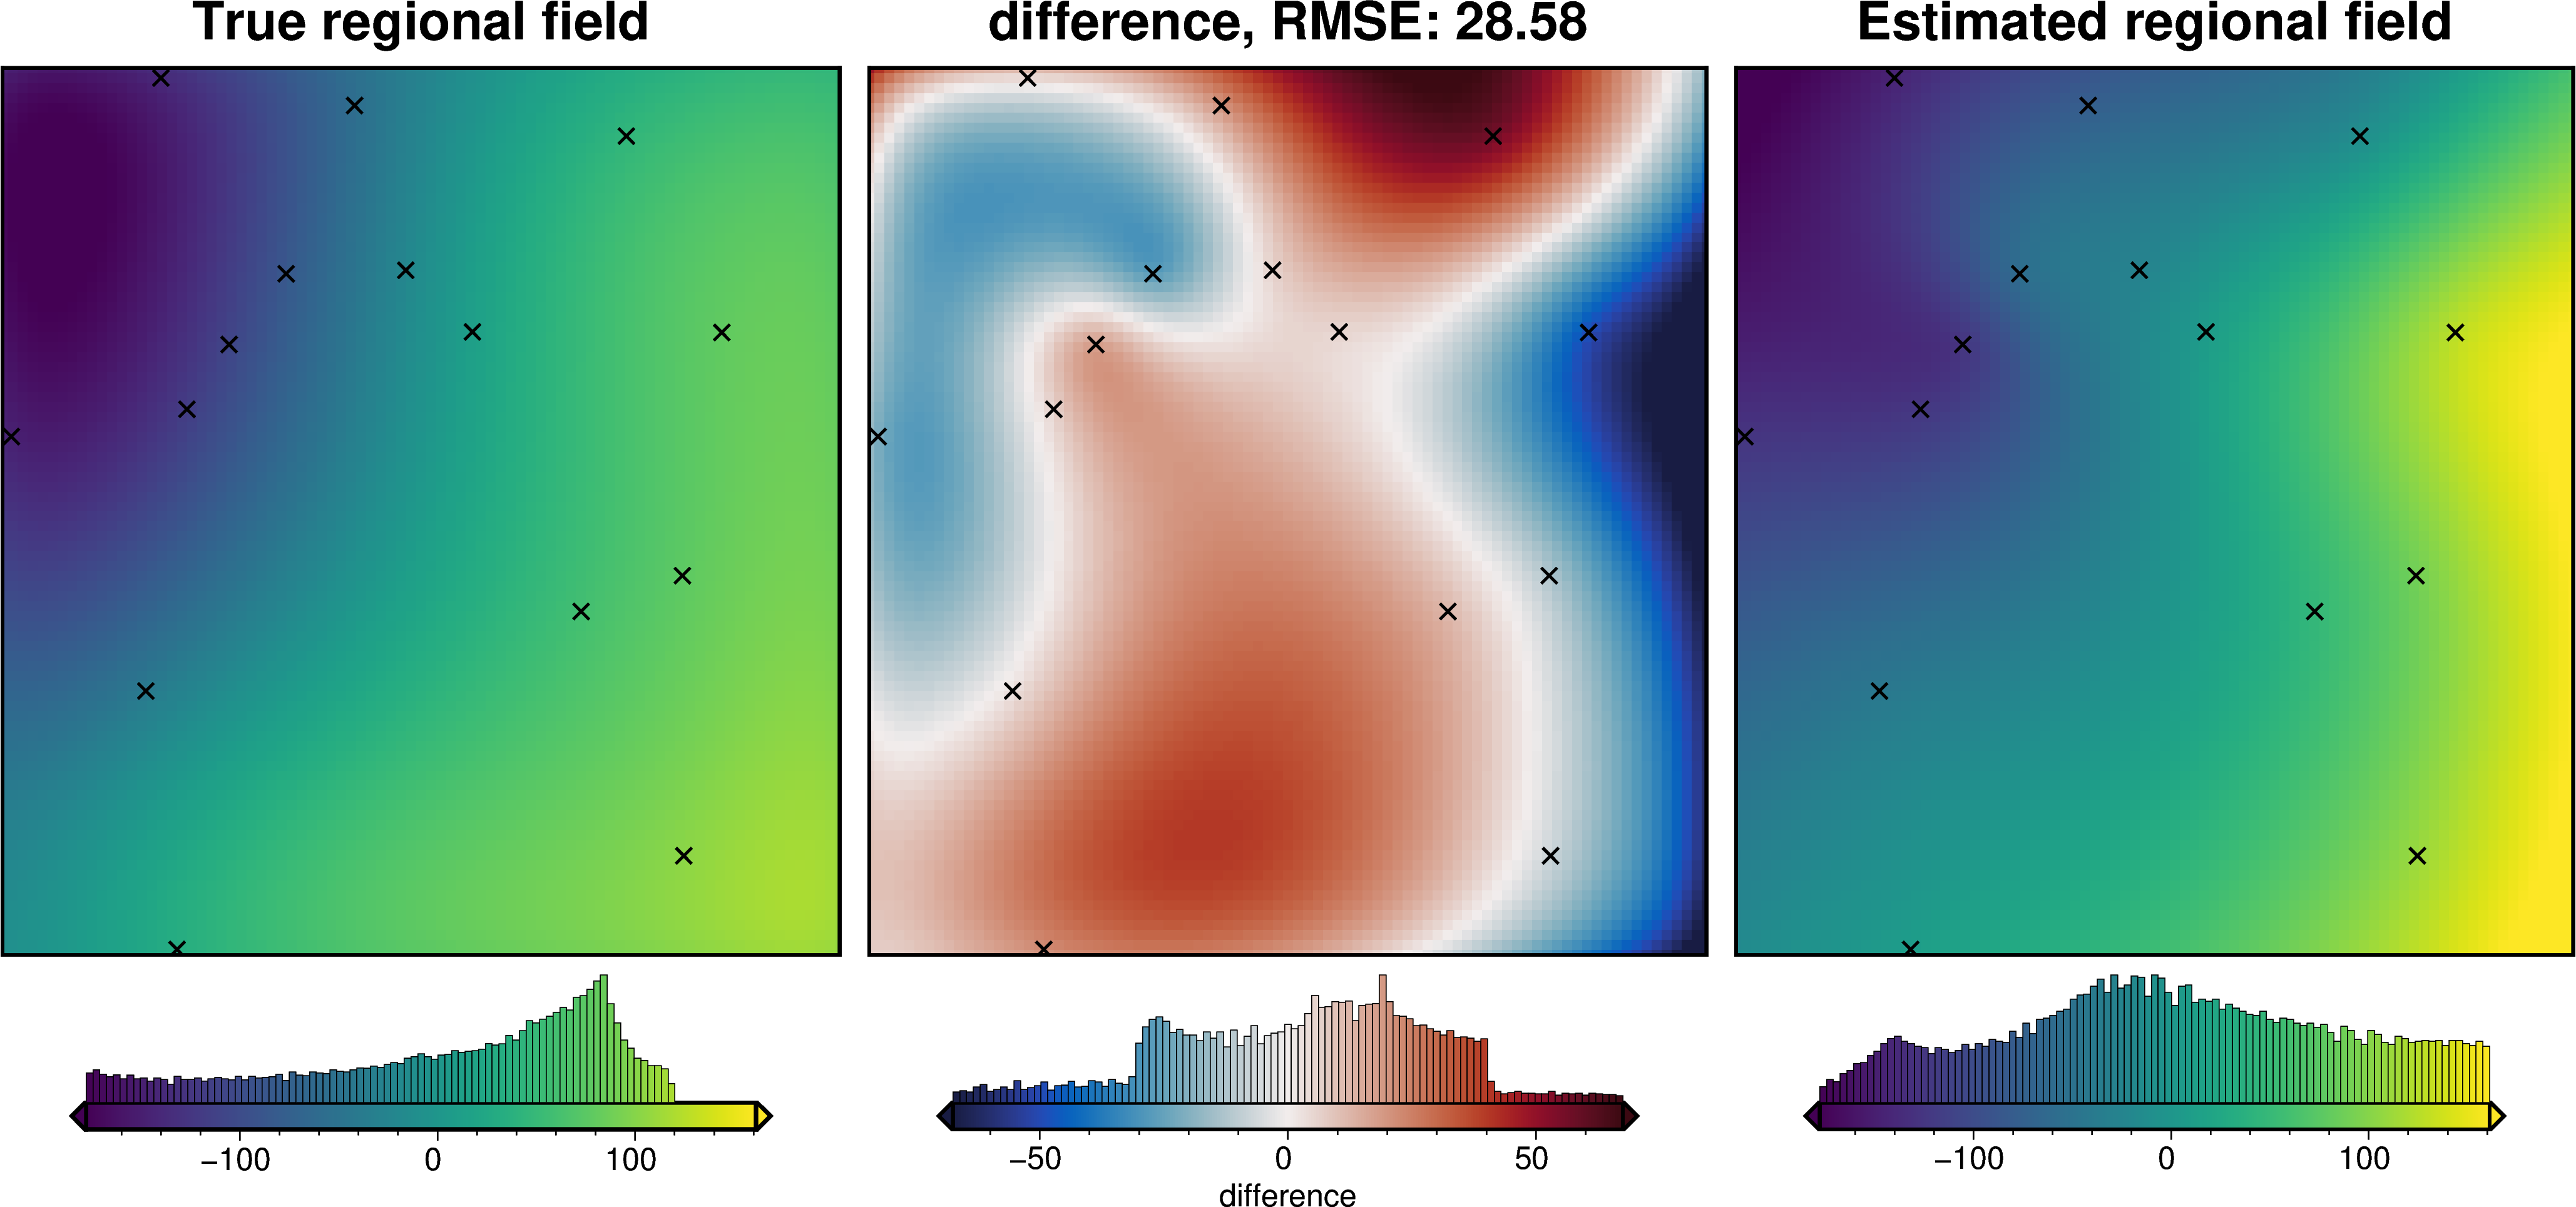

In [31]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization_kfolds(
        testing_training_df=leave_one_out_split_df,
        grid_method="verde",
        spline_damping_limits=[1e-10, 1e3],
        n_trials=20,
        plot=True,
        plot_grid=False,
        fold_progressbar=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

##### Equivalent Sources with Harmonica

INFO:root:training and testing data supplied as lists of dataframe, using them for a K-Folds cross validation


  0%|          | 0/60 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 11
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 3
INFO:root:	parameter: {'source_depth': 111690.05836153984, 'eq_damping': 0.023218696469971635}
INFO:root:	scores: [26.652147895875355, 54.96052818999554]


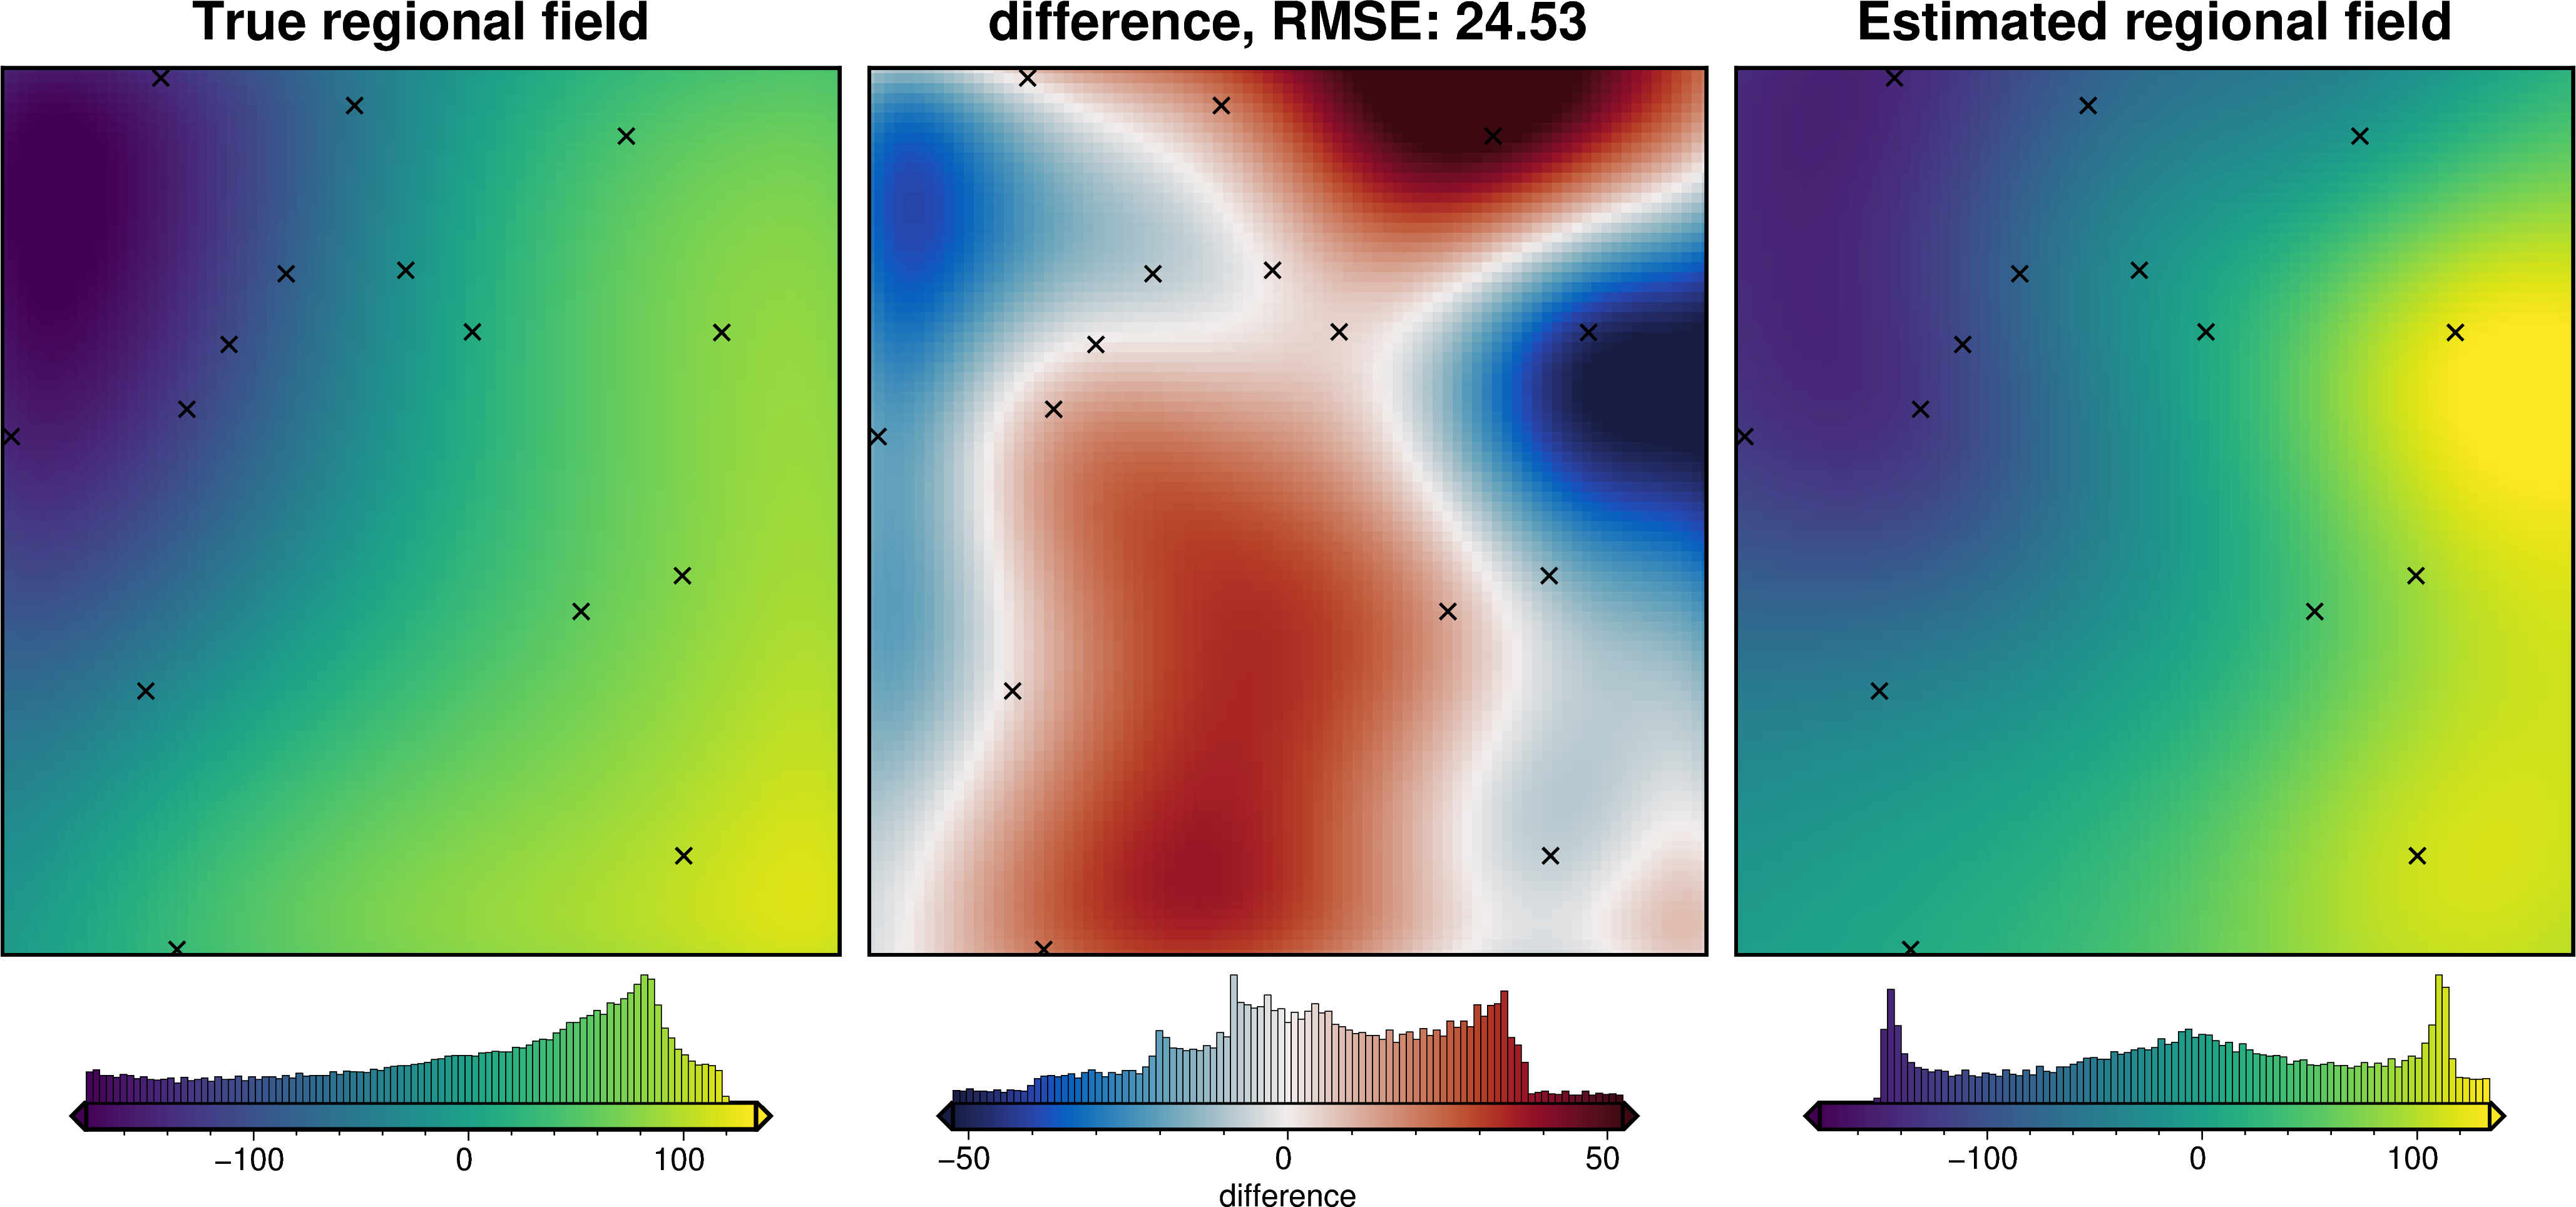

In [32]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization_kfolds(
        testing_training_df=leave_one_out_split_df,
        grid_method="eq_sources",
        source_depth_limits=[spacing * 20, spacing * 60],
        eq_damping_limits=[1e-10, 10],
        # if limits are omitted, must provide constant values
        block_size=spacing * 10,
        grav_obs_height=1e3,
        n_trials=60,  # more trials needed since more parameters
        plot=True,
        plot_grid=False,
        fold_progressbar=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

#### K-Folds Optimization

We can also run the optimization on the constraints which have been split into several folds of *testing* and *training* data. Each fold will require it's own optimization, and the results from each fold will be merged to see which hyperparameter values are optimal across all the folds.

In [33]:
block_kfold_split_df.head()

easting       northing       upward fold_0 fold_1 fold_2 fold_3  \
0   93942.740553  165086.148419 -6166.691339  train  train  train   test   
1  185744.836752  437747.618234 -5230.910817  train  train   test  train   
2  165200.779866  503888.251841 -4551.466895  train  train  train   test   
3  312585.151503  412789.886738 -6178.090981  train  train  train  train   
4   81410.282014  268837.863004 -4562.000830  train   test  train  train   

  fold_4  
0  train  
1  train  
2  train  
3   test  
4  train

##### Tensioned Minimum Curvature with PyGMT

INFO:root:training and testing data supplied as lists of dataframe, using them for a K-Folds cross validation


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 5
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 15
INFO:root:	parameter: {'tension_factor': 0.13101483065911554}
INFO:root:	scores: [29.330041701152737, 50.164431538679864]


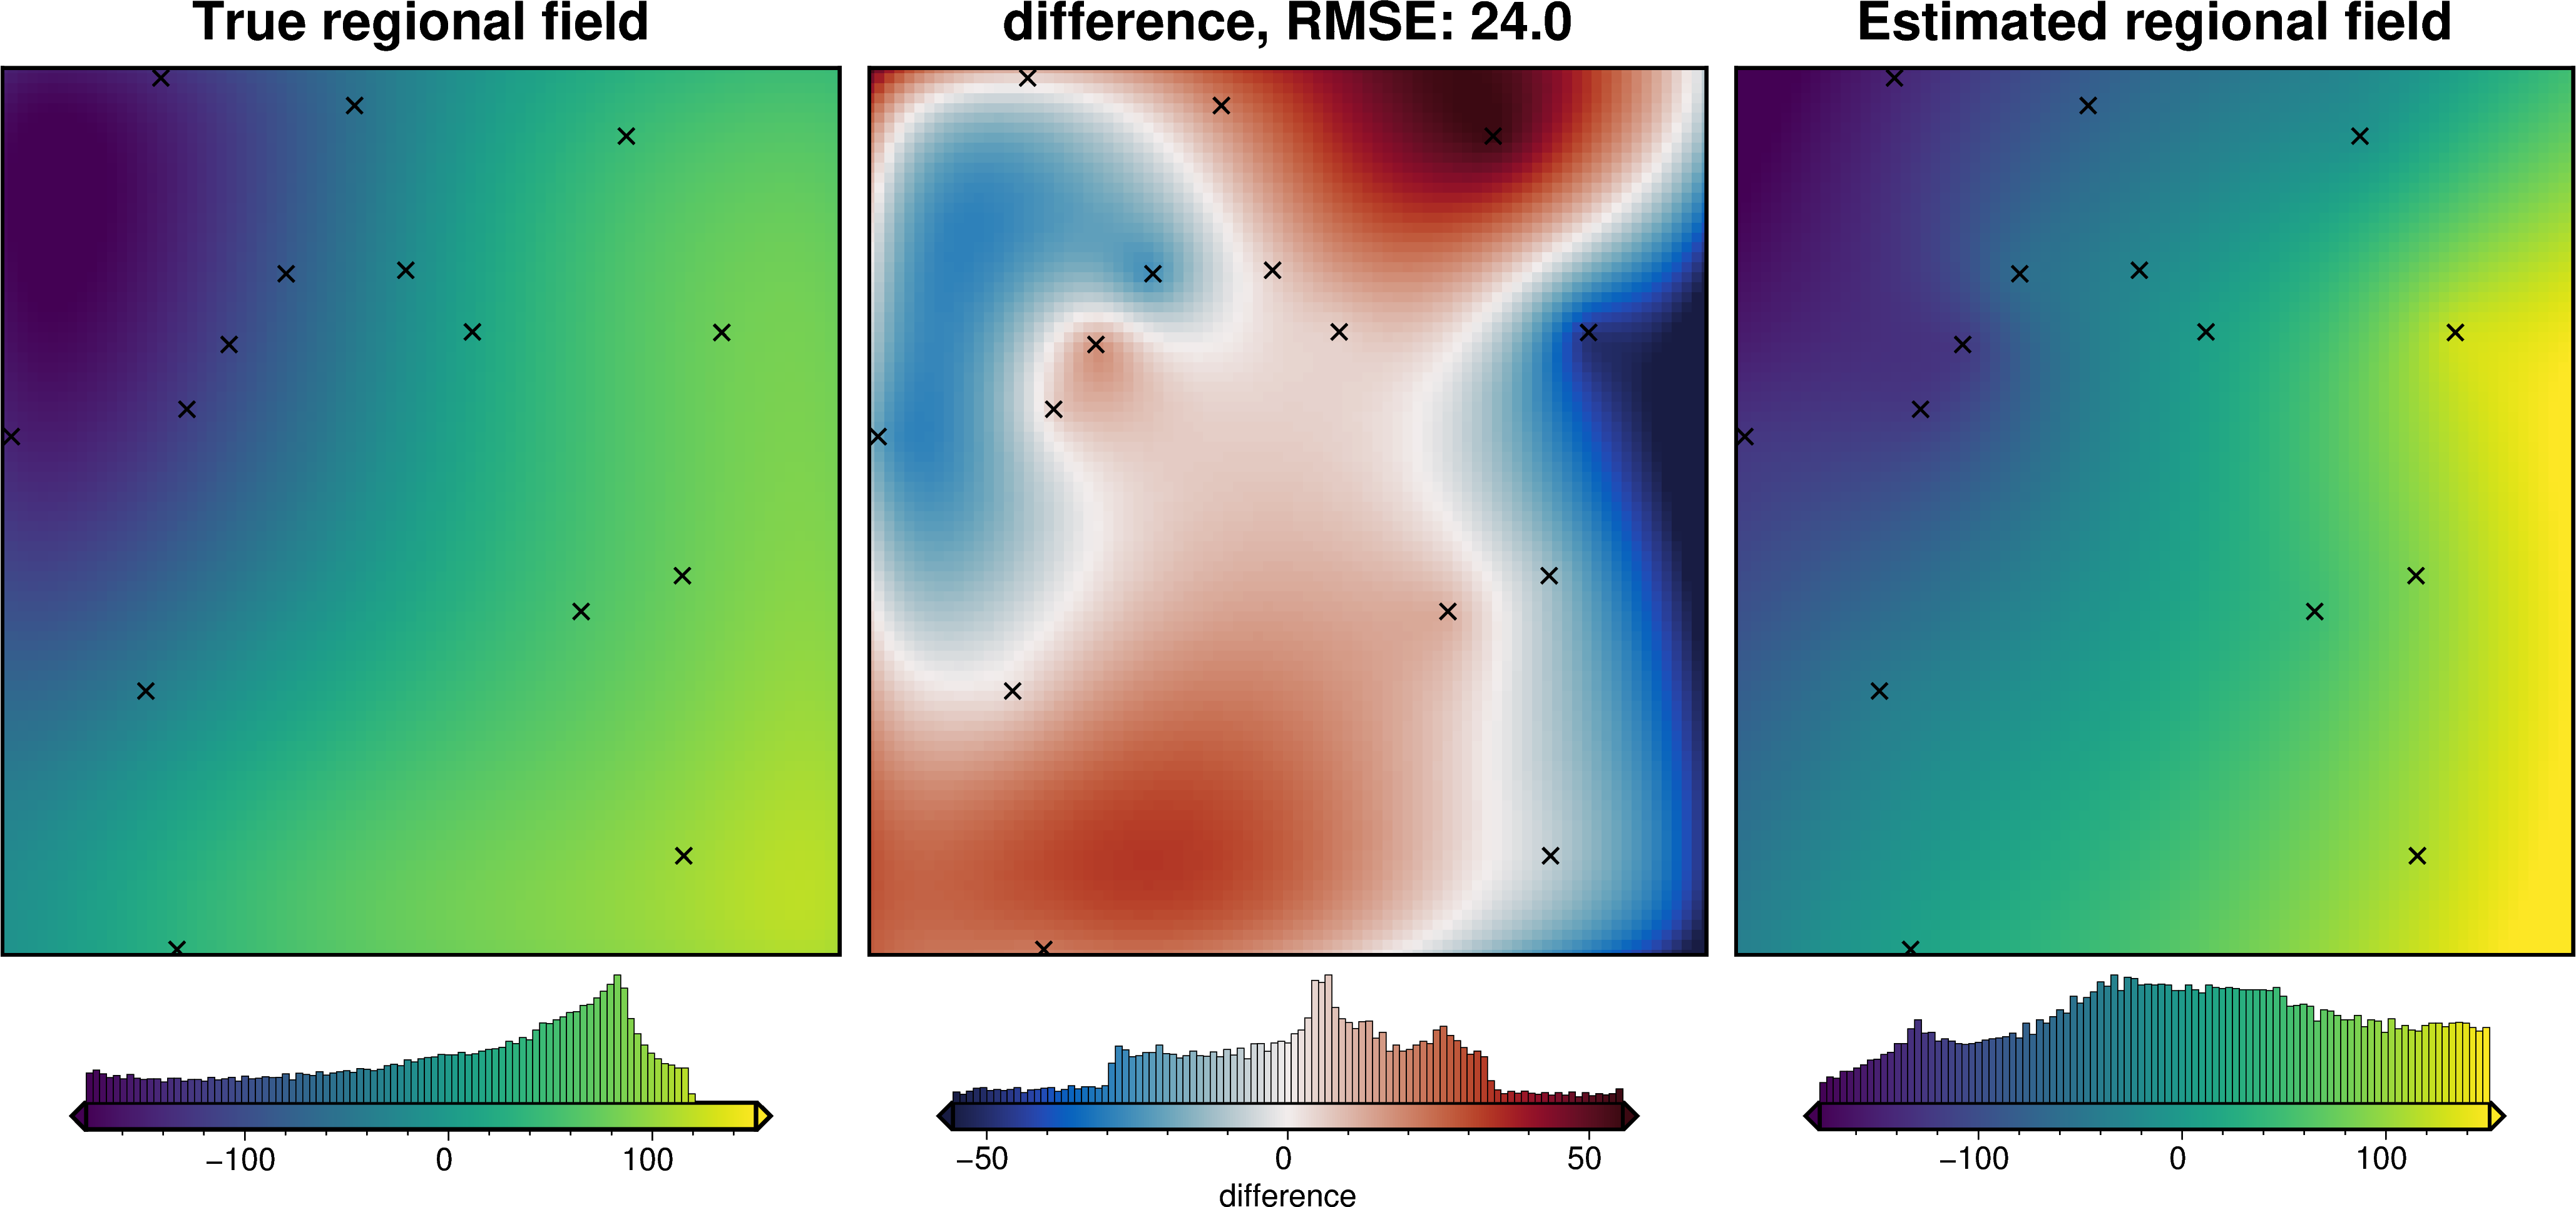

In [34]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization_kfolds(
        testing_training_df=block_kfold_split_df,
        grid_method="pygmt",
        tension_factor_limits=[0, 1],
        n_trials=20,
        plot=True,
        plot_grid=False,
        fold_progressbar=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

##### Bi-Harmonic Splines with Verde

INFO:root:training and testing data supplied as lists of dataframe, using them for a K-Folds cross validation


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 13
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 16
INFO:root:	parameter: {'spline_damping': 8.204226005743303}
INFO:root:	scores: [30.90691545151658, 51.18133418053391]


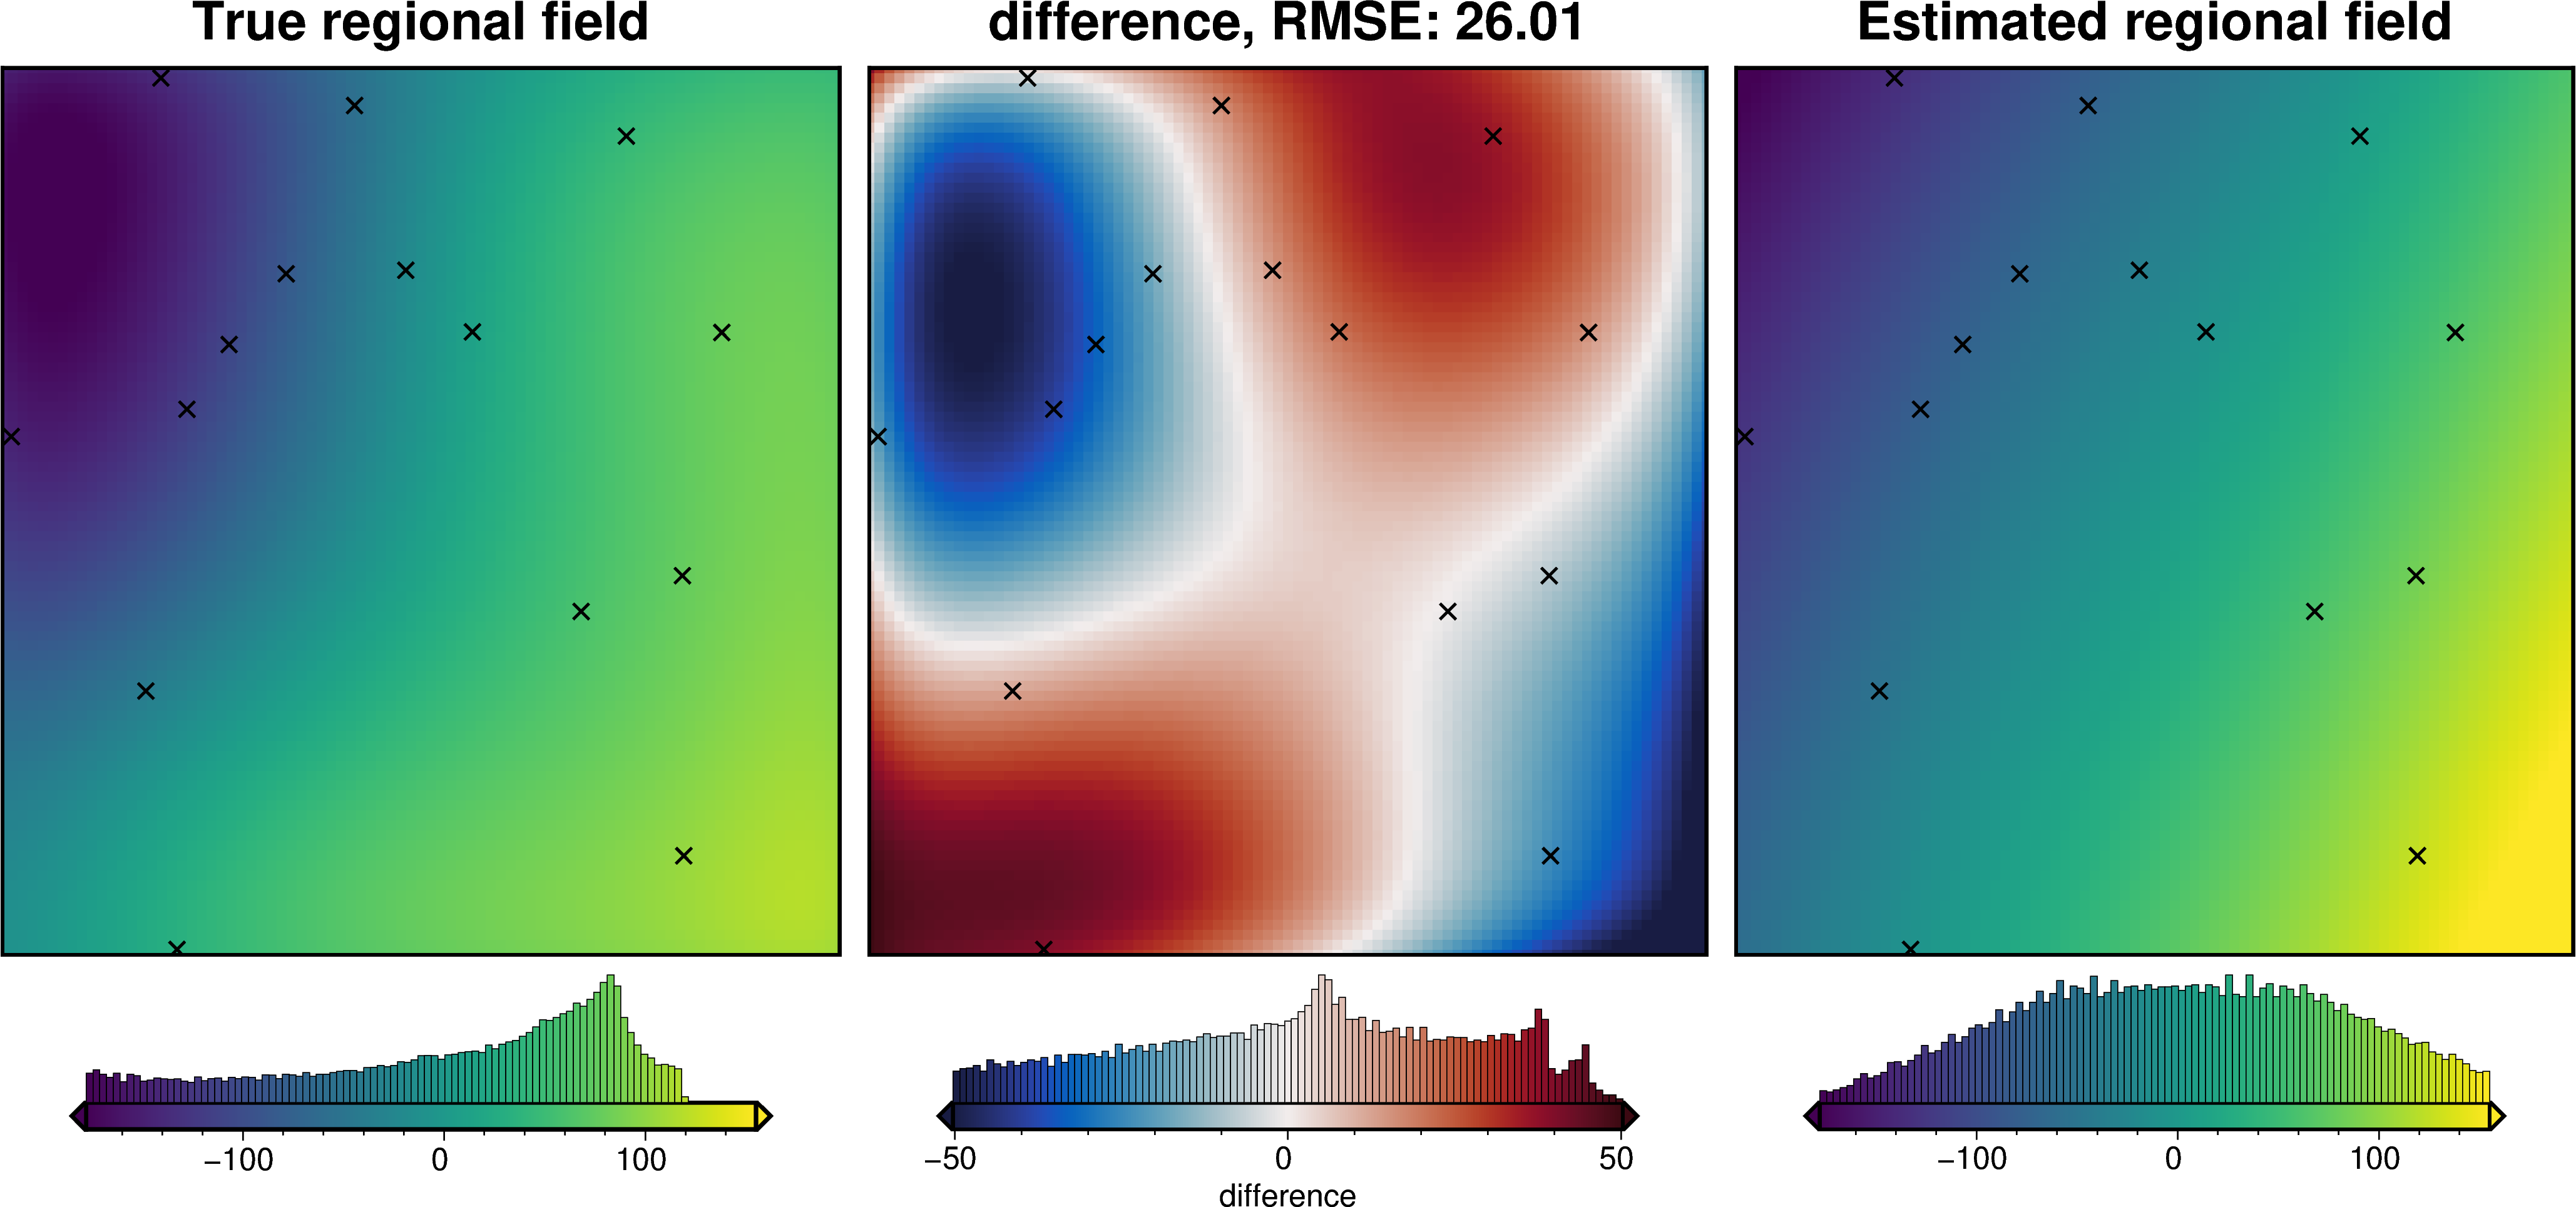

In [35]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization_kfolds(
        testing_training_df=block_kfold_split_df,
        grid_method="verde",
        spline_damping_limits=[1e-10, 1e3],
        n_trials=20,
        plot=True,
        plot_grid=False,
        fold_progressbar=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)
regional_comparison(grav_df)

##### Equivalent Sources with Harmonica

INFO:root:training and testing data supplied as lists of dataframe, using them for a K-Folds cross validation


  0%|          | 0/60 [00:00<?, ?it/s]

INFO:root:Number of trials on the Pareto front: 24
INFO:root:Trial with lowest residual at constraint points: 
INFO:root:	trial number: 20
INFO:root:	parameter: {'source_depth': 222007.24467199313, 'eq_damping': 5.102917433971368e-06}
INFO:root:	scores: [31.270042793954577, 57.501296467102144]


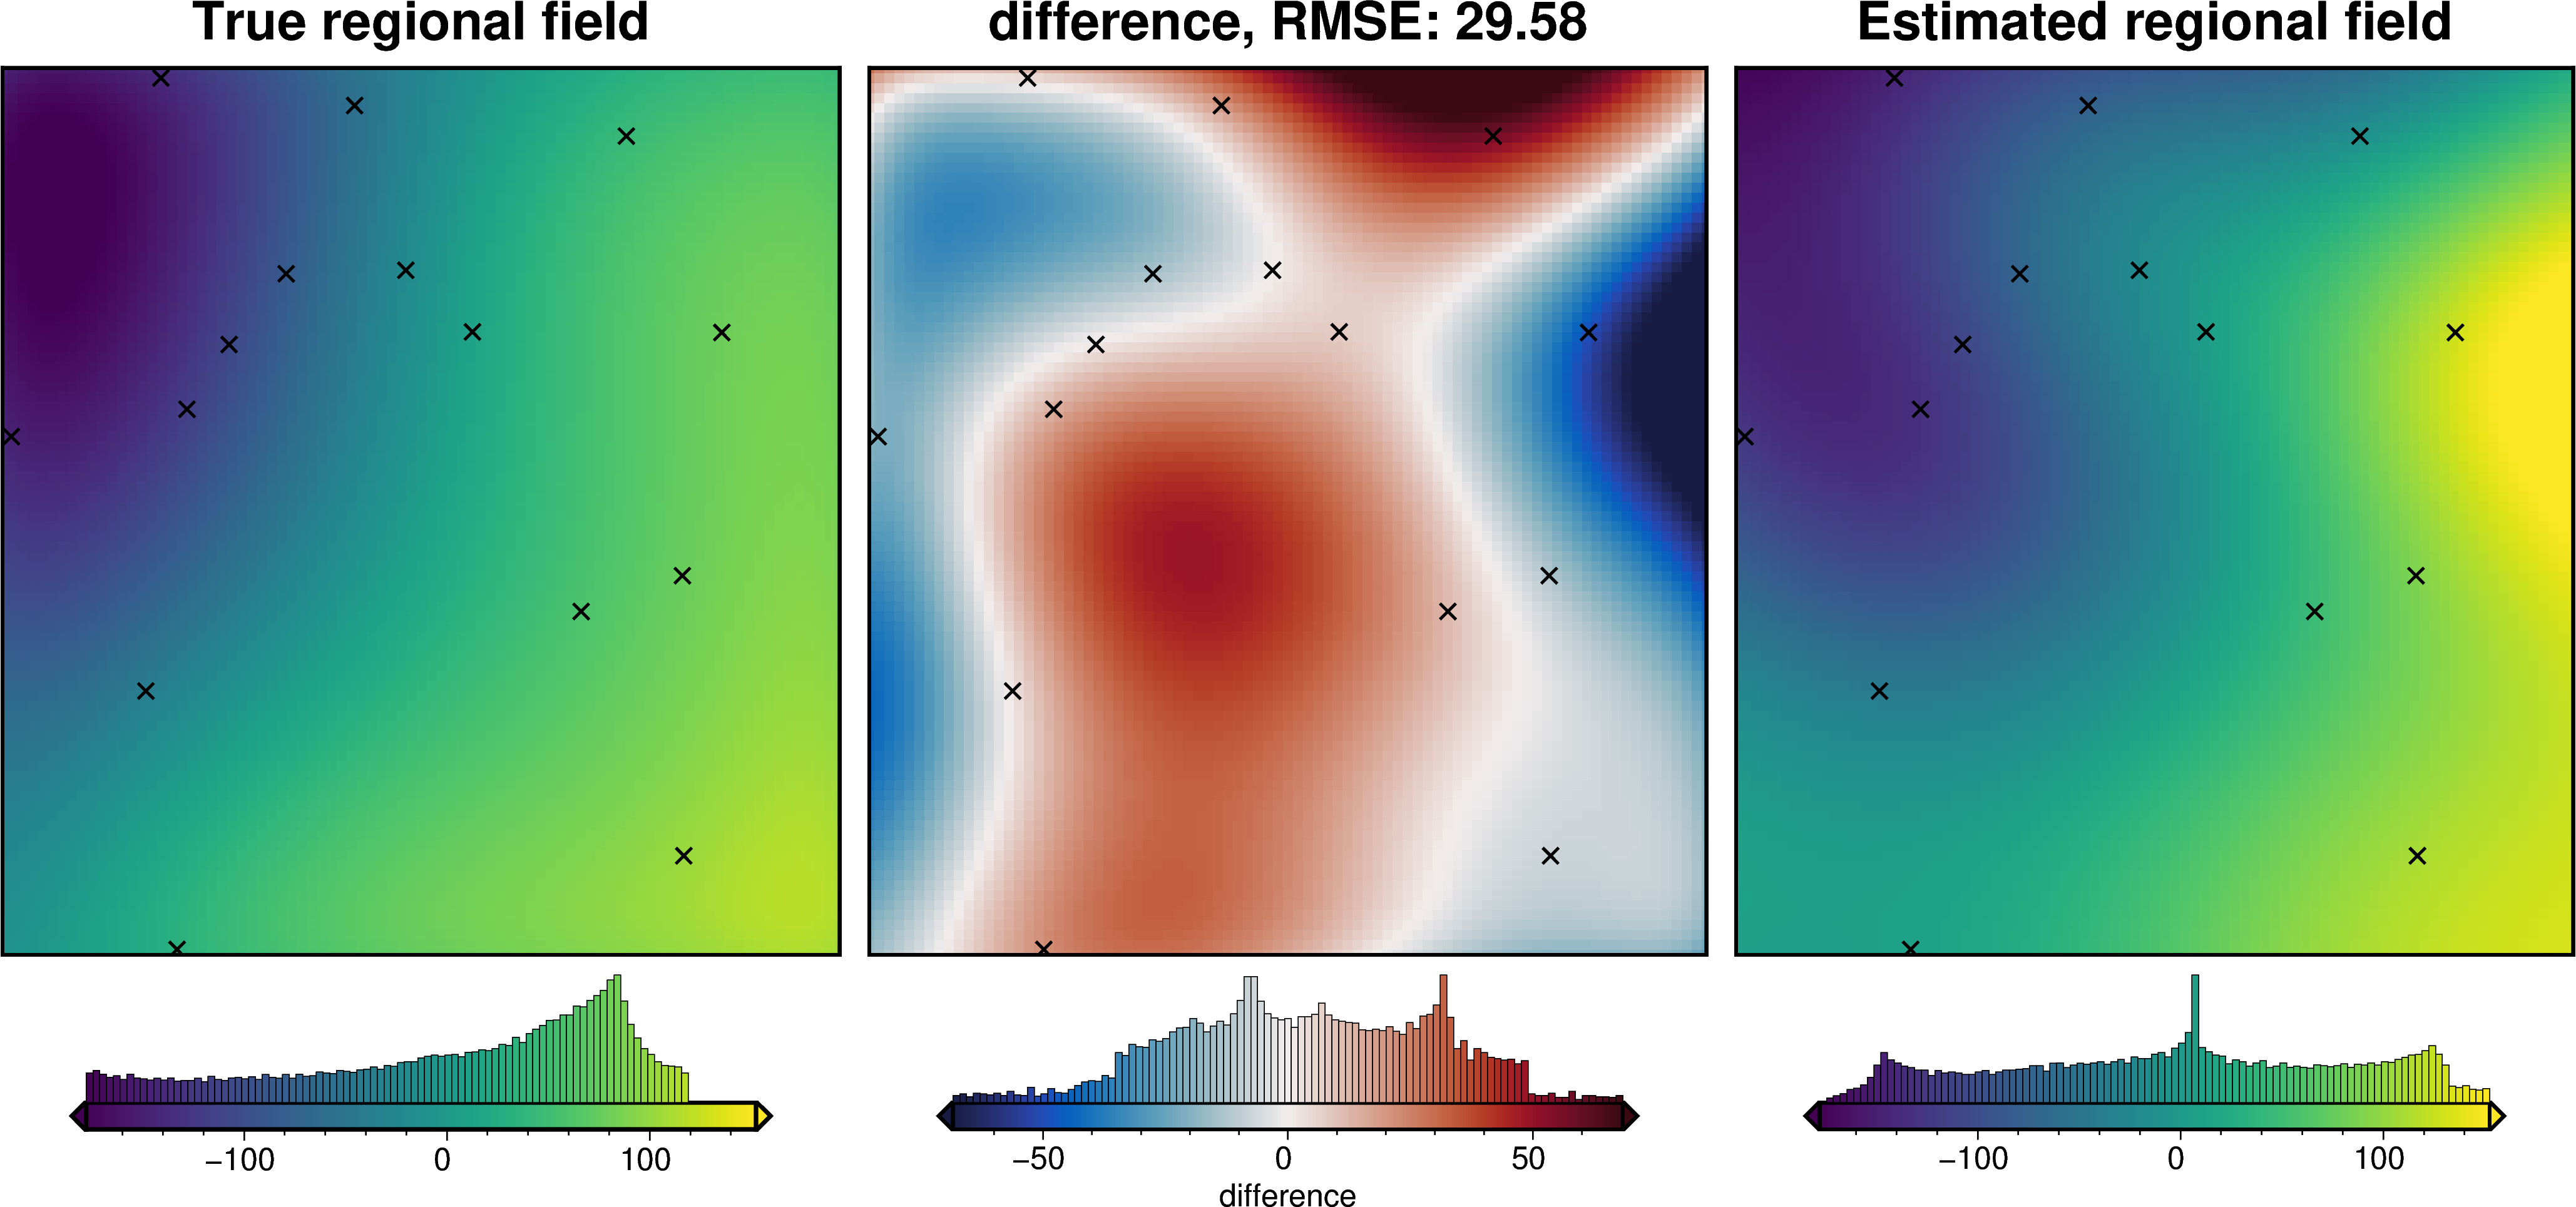

In [36]:
study, grav_df, best_trial = (
    optimization.optimize_regional_constraint_point_minimization_kfolds(
        testing_training_df=block_kfold_split_df,
        grid_method="eq_sources",
        source_depth_limits=[spacing * 20, spacing * 60],
        eq_damping_limits=[1e-10, 10],
        # if limits are omitted, must provide constant values
        block_size=spacing * 10,
        grav_obs_height=1e3,
        n_trials=60,  # more trials needed since more parameters
        plot=True,
        plot_grid=False,
        fold_progressbar=False,
        # optimize_on_true_regional_misfit=True,
        **kwargs,
    )
)

regional_comparison(grav_df)

# Uncertainty Analysis

We can use a stochastic approach to estimate the uncertainty of the regional separation. 

STILL TO COME!